## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


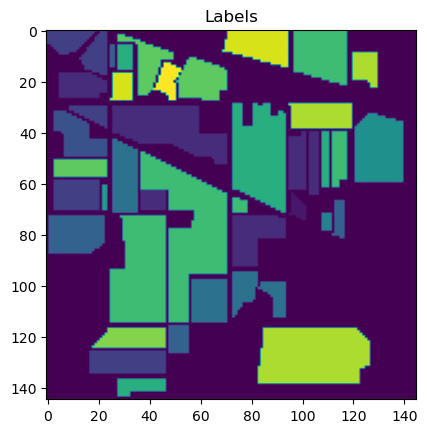

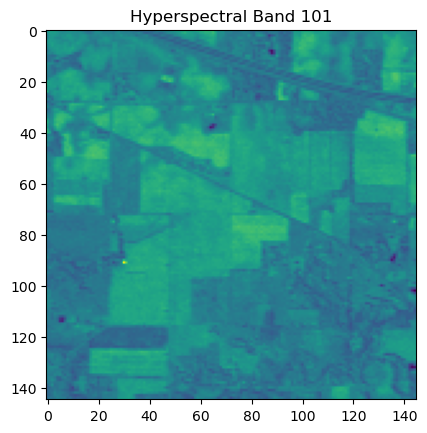

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(160, 5, 5, 200)
(80, 5, 5, 200)
(10009, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0792, PSNR: 10.6393


Epoch [1/50] Training Loss: 0.0658, PSNR: 11.4047
	[Val]   Batch [1/33] Loss: 0.0503, PSNR: 12.6454
	[Val]   Batch [10/33] Loss: 0.0498, PSNR: 12.2944
	[Val]   Batch [20/33] Loss: 0.0494, PSNR: 11.8952
	[Val]   Batch [30/33] Loss: 0.0480, PSNR: 12.2636
Epoch [1/50] Validation Loss: 0.0501, PSNR: 12.4600

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0492, PSNR: 12.3480


Epoch [2/50] Training Loss: 0.0398, PSNR: 13.5743
	[Val]   Batch [1/33] Loss: 0.0293, PSNR: 15.0027
	[Val]   Batch [10/33] Loss: 0.0288, PSNR: 14.6746
	[Val]   Batch [20/33] Loss: 0.0285, PSNR: 14.2824
	[Val]   Batch [30/33] Loss: 0.0277, PSNR: 14.6463
Epoch [2/50] Validation Loss: 0.0292, PSNR: 14.8108

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0301, PSNR: 14.4427


Epoch [3/50] Training Loss: 0.0232, PSNR: 15.9125
	[Val]   Batch [1/33] Loss: 0.0178, PSNR: 17.1644
	[Val]   Batch [10/33] Loss: 0.0173, PSNR: 16.8800
	[Val]   Batch [20/33] Loss: 0.0170, PSNR: 16.5152
	[Val]   Batch [30/33] Loss: 0.0166, PSNR: 16.8745
Epoch [3/50] Validation Loss: 0.0177, PSNR: 16.9714

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0160, PSNR: 17.2183


Epoch [4/50] Training Loss: 0.0143, PSNR: 18.0431
	[Val]   Batch [1/33] Loss: 0.0118, PSNR: 18.9282
	[Val]   Batch [10/33] Loss: 0.0114, PSNR: 18.7014
	[Val]   Batch [20/33] Loss: 0.0111, PSNR: 18.3750
	[Val]   Batch [30/33] Loss: 0.0108, PSNR: 18.7496
Epoch [4/50] Validation Loss: 0.0118, PSNR: 18.7442

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0121, PSNR: 18.8532


Epoch [5/50] Training Loss: 0.0097, PSNR: 19.7246
	[Val]   Batch [1/33] Loss: 0.0085, PSNR: 20.3915
	[Val]   Batch [10/33] Loss: 0.0080, PSNR: 20.2323
	[Val]   Batch [20/33] Loss: 0.0077, PSNR: 19.9498
	[Val]   Batch [30/33] Loss: 0.0075, PSNR: 20.3462
Epoch [5/50] Validation Loss: 0.0084, PSNR: 20.2150

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0090, PSNR: 20.4698


Epoch [6/50] Training Loss: 0.0072, PSNR: 20.9868
	[Val]   Batch [1/33] Loss: 0.0066, PSNR: 21.4754
	[Val]   Batch [10/33] Loss: 0.0061, PSNR: 21.3781
	[Val]   Batch [20/33] Loss: 0.0059, PSNR: 21.1385
	[Val]   Batch [30/33] Loss: 0.0057, PSNR: 21.5383
Epoch [6/50] Validation Loss: 0.0066, PSNR: 21.3014

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0062, PSNR: 21.8442


Epoch [7/50] Training Loss: 0.0057, PSNR: 21.9856
	[Val]   Batch [1/33] Loss: 0.0054, PSNR: 22.3661
	[Val]   Batch [10/33] Loss: 0.0049, PSNR: 22.3499
	[Val]   Batch [20/33] Loss: 0.0047, PSNR: 22.1487
	[Val]   Batch [30/33] Loss: 0.0045, PSNR: 22.5509
Epoch [7/50] Validation Loss: 0.0053, PSNR: 22.2088

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0052, PSNR: 22.2190


Epoch [8/50] Training Loss: 0.0048, PSNR: 22.7946
	[Val]   Batch [1/33] Loss: 0.0045, PSNR: 23.1043
	[Val]   Batch [10/33] Loss: 0.0041, PSNR: 23.1588
	[Val]   Batch [20/33] Loss: 0.0038, PSNR: 22.9951
	[Val]   Batch [30/33] Loss: 0.0037, PSNR: 23.4204
Epoch [8/50] Validation Loss: 0.0045, PSNR: 22.9650

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0042, PSNR: 23.4308


Epoch [9/50] Training Loss: 0.0041, PSNR: 23.4688
	[Val]   Batch [1/33] Loss: 0.0039, PSNR: 23.7885
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 23.9260
	[Val]   Batch [20/33] Loss: 0.0032, PSNR: 23.7985
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2459
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.6817

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0042, PSNR: 23.1956


Epoch [10/50] Training Loss: 0.0036, PSNR: 24.0550
	[Val]   Batch [1/33] Loss: 0.0034, PSNR: 24.3405
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.5637
	[Val]   Batch [20/33] Loss: 0.0027, PSNR: 24.4753
	[Val]   Batch [30/33] Loss: 0.0026, PSNR: 24.9505
Epoch [10/50] Validation Loss: 0.0033, PSNR: 24.2766

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.0011


Epoch [11/50] Training Loss: 0.0031, PSNR: 24.6134
	[Val]   Batch [1/33] Loss: 0.0030, PSNR: 24.9122
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2186
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1606
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6835
Epoch [11/50] Validation Loss: 0.0029, PSNR: 24.8959

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 25.0346


Epoch [12/50] Training Loss: 0.0028, PSNR: 25.1354
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3374
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.7367
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.7180
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2824
Epoch [12/50] Validation Loss: 0.0026, PSNR: 25.3867

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.4597


Epoch [13/50] Training Loss: 0.0025, PSNR: 25.5846
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.7874
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2503
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.2499
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.8176
Epoch [13/50] Validation Loss: 0.0023, PSNR: 25.8659

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.3264


Epoch [14/50] Training Loss: 0.0023, PSNR: 25.9739
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.0747
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.5279
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.5373
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 27.1387
Epoch [14/50] Validation Loss: 0.0022, PSNR: 26.1542

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.6949


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.3470
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.5195
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9578
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 26.9805
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6027
Epoch [15/50] Validation Loss: 0.0020, PSNR: 26.5989

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.2670


Epoch [16/50] Training Loss: 0.0020, PSNR: 26.6635
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.1021
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5338
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5671
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.2286
Epoch [16/50] Validation Loss: 0.0017, PSNR: 27.1776

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.2028


Epoch [17/50] Training Loss: 0.0018, PSNR: 26.9739
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4361
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7855
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8315
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.5233
Epoch [17/50] Validation Loss: 0.0016, PSNR: 27.4867

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.1734


Epoch [18/50] Training Loss: 0.0017, PSNR: 27.3798
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.9783
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.3166
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.3721
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.0768
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.0077

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.3578


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.7293
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.3098
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5663
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6190
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3459
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.3060

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.6811


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.0253
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7789
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9775
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 29.0355
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7626
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.7348

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.6200


Epoch [21/50] Training Loss: 0.0014, PSNR: 28.2692
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.1977
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3750
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4779
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2022
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1545

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.7818


Epoch [22/50] Training Loss: 0.0013, PSNR: 28.5660
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.4959
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6571
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7808
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5055
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.4400

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.4907


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.7794
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5827
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7284
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.8693
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6021
Epoch [23/50] Validation Loss: 0.0010, PSNR: 29.5478

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.6660


Epoch [24/50] Training Loss: 0.0012, PSNR: 28.9585
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6943
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8198
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9695
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7446
Epoch [24/50] Validation Loss: 0.0010, PSNR: 29.6499

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.7668


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.1661
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1551
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3089
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4781
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2099
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.1598

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.7503


Epoch [26/50] Training Loss: 0.0011, PSNR: 29.3458
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3329
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4835
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6961
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4277
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.3251

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.2672


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.4970
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4357
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5631
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7815
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5801
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.4294

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.1821


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6144
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6238
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7864
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0205
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.8551
Epoch [28/50] Validation Loss: 0.0008, PSNR: 30.6559
Early stopping triggered at epoch 28. No improvement for 3 epochs.


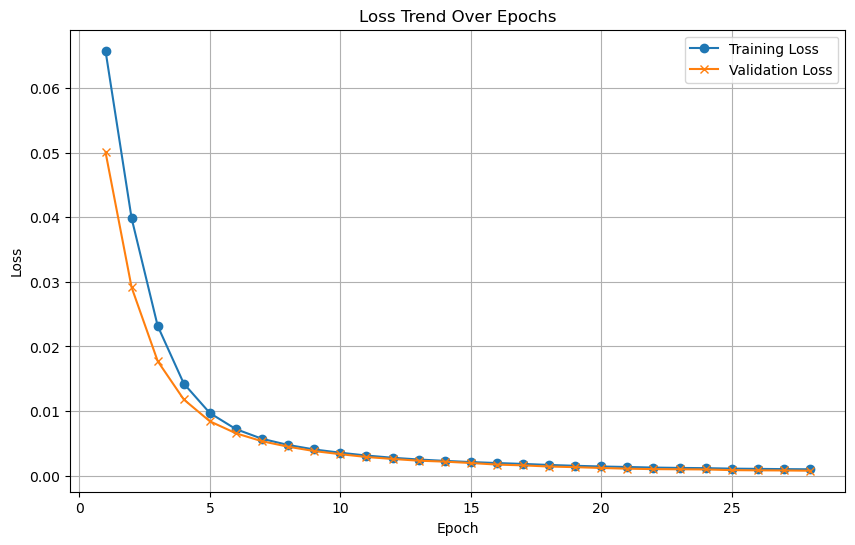

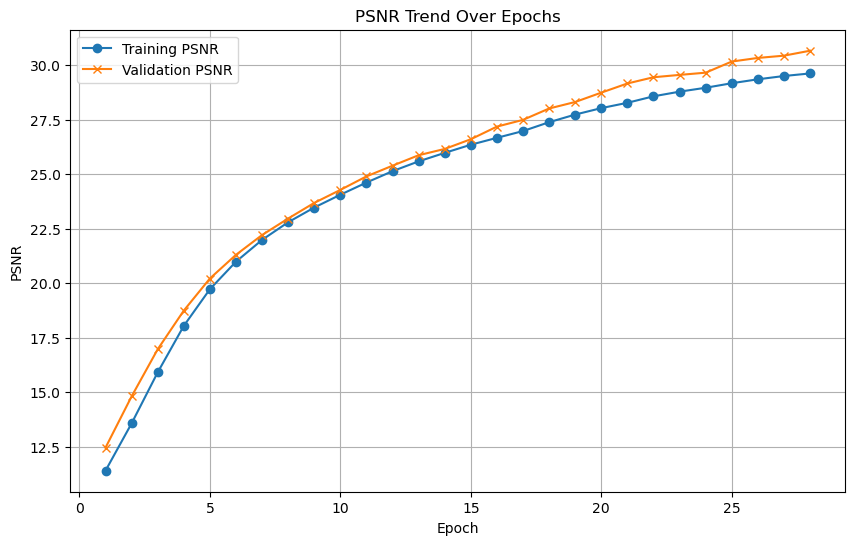

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7684
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7762. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7406
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 6.25%
Validation loss improved from 2.7762 to 2.7762. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7203
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7762 to 2.7761. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7091
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7761. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7761. Saving model...

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 2.6910
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7761. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.6713
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7761. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6647
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7761. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6574
    Validation Batch

    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 6.25%
Validation loss improved from 2.7760 to 2.7759. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5871
    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 6.25%
Validation loss improved from 2.7759 to 2.7759. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5658
    Validation Batch [1/1], Loss: 2.7758
Validation Loss: 2.7758, Validation Accuracy: 6.25%
Validation loss improved from 2.7759 to 2.7758. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5778
    Validation Batch [1/1], Loss: 2.7756
Validation Loss: 2.7756, Validation Accuracy: 6.25%
Validation loss improved from 2.7758 to 2.7756. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5645
    Validati

    Validation Batch [1/1], Loss: 2.7650
Validation Loss: 2.7650, Validation Accuracy: 12.50%
Validation loss improved from 2.7663 to 2.7650. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4686
    Validation Batch [1/1], Loss: 2.7638
Validation Loss: 2.7638, Validation Accuracy: 12.50%
Validation loss improved from 2.7650 to 2.7638. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4693
    Validation Batch [1/1], Loss: 2.7622
Validation Loss: 2.7622, Validation Accuracy: 12.50%
Validation loss improved from 2.7638 to 2.7622. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4488
    Validation Batch [1/1], Loss: 2.7604
Validation Loss: 2.7604, Validation Accuracy: 11.25%
Validation loss improved from 2.7622 to 2.7604. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.4243
    Vali

Epoch [42/1000] completed, Average Training Loss: 2.4076
    Validation Batch [1/1], Loss: 2.7172
Validation Loss: 2.7172, Validation Accuracy: 22.50%
Validation loss improved from 2.7254 to 2.7172. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3755
    Validation Batch [1/1], Loss: 2.7087
Validation Loss: 2.7087, Validation Accuracy: 21.25%
Validation loss improved from 2.7172 to 2.7087. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.3711
    Validation Batch [1/1], Loss: 2.6988
Validation Loss: 2.6988, Validation Accuracy: 22.50%
Validation loss improved from 2.7087 to 2.6988. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.3697
    Validation Batch [1/1], Loss: 2.6854
Validation Loss: 2.6854, Validation Accuracy: 21.25%
Validation loss improved from 2.6988 to 2.6854. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [4

Epoch [59/1000] completed, Average Training Loss: 2.2568
    Validation Batch [1/1], Loss: 2.4999
Validation Loss: 2.4999, Validation Accuracy: 38.75%
Validation loss improved from 2.5113 to 2.4999. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.2266
    Validation Batch [1/1], Loss: 2.4919
Validation Loss: 2.4919, Validation Accuracy: 37.50%
Validation loss improved from 2.4999 to 2.4919. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.2333
    Validation Batch [1/1], Loss: 2.4897
Validation Loss: 2.4897, Validation Accuracy: 33.75%
Validation loss improved from 2.4919 to 2.4897. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.2202
    Validation Batch [1/1], Loss: 2.4822
Validation Loss: 2.4822, Validation Accuracy: 33.75%
Validation loss improved from 2.4897 to 2.4822. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [6

Epoch [70/1000] completed, Average Training Loss: 2.1414
    Validation Batch [1/1], Loss: 2.3999
Validation Loss: 2.3999, Validation Accuracy: 31.25%
Validation loss improved from 2.4151 to 2.3999. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.1334
    Validation Batch [1/1], Loss: 2.3650
Validation Loss: 2.3650, Validation Accuracy: 40.00%
Validation loss improved from 2.3999 to 2.3650. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.1403
    Validation Batch [1/1], Loss: 2.3404
Validation Loss: 2.3404, Validation Accuracy: 43.75%
Validation loss improved from 2.3650 to 2.3404. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.1292
    Validation Batch [1/1], Loss: 2.3266
Validation Loss: 2.3266, Validation Accuracy: 46.25%
Validation loss improved from 2.3404 to 2.3266. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [7

Epoch [85/1000] completed, Average Training Loss: 2.0020
    Validation Batch [1/1], Loss: 2.2721
Validation Loss: 2.2721, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.0074
    Validation Batch [1/1], Loss: 2.2642
Validation Loss: 2.2642, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0046
    Validation Batch [1/1], Loss: 2.2313
Validation Loss: 2.2313, Validation Accuracy: 48.75%
Validation loss improved from 2.2340 to 2.2313. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9768
    Validation Batch [1/1], Loss: 2.2270
Validation Loss: 2.2270, Validation Accuracy: 45.00%
Validation loss improved from 2.2313 to 2.2270. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Tra

Epoch [97/1000] completed, Average Training Loss: 1.8640
    Validation Batch [1/1], Loss: 2.1640
Validation Loss: 2.1640, Validation Accuracy: 45.00%
Validation loss improved from 2.1829 to 2.1640. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8661
    Validation Batch [1/1], Loss: 2.1509
Validation Loss: 2.1509, Validation Accuracy: 50.00%
Validation loss improved from 2.1640 to 2.1509. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8812
    Validation Batch [1/1], Loss: 2.1441
Validation Loss: 2.1441, Validation Accuracy: 55.00%
Validation loss improved from 2.1509 to 2.1441. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8766
    Validation Batch [1/1], Loss: 2.1454
Validation Loss: 2.1454, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] com

Epoch [111/1000] completed, Average Training Loss: 1.7644
    Validation Batch [1/1], Loss: 2.1396
Validation Loss: 2.1396, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7560
    Validation Batch [1/1], Loss: 2.0993
Validation Loss: 2.0993, Validation Accuracy: 48.75%
Validation loss improved from 2.1070 to 2.0993. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7435
    Validation Batch [1/1], Loss: 2.1022
Validation Loss: 2.1022, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7440
    Validation Batch [1/1], Loss: 2.1545
Validation Loss: 2.1545, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training 

Epoch [125/1000] completed, Average Training Loss: 1.6074
    Validation Batch [1/1], Loss: 1.9628
Validation Loss: 1.9628, Validation Accuracy: 47.50%
Validation loss improved from 1.9794 to 1.9628. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6075
    Validation Batch [1/1], Loss: 1.9992
Validation Loss: 1.9992, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6196
    Validation Batch [1/1], Loss: 2.0383
Validation Loss: 2.0383, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.5792
    Validation Batch [1/1], Loss: 1.9809
Validation Loss: 1.9809, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training 

Epoch [139/1000] completed, Average Training Loss: 1.4983
    Validation Batch [1/1], Loss: 1.8923
Validation Loss: 1.8923, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5002
    Validation Batch [1/1], Loss: 1.8749
Validation Loss: 1.8749, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.4969
    Validation Batch [1/1], Loss: 1.8933
Validation Loss: 1.8933, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4699
    Validation Batch [1/1], Loss: 1.9486
Validation Loss: 1.9486, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4647
  

Epoch [152/1000] completed, Average Training Loss: 1.4007
    Validation Batch [1/1], Loss: 1.8375
Validation Loss: 1.8375, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3887
    Validation Batch [1/1], Loss: 1.8082
Validation Loss: 1.8082, Validation Accuracy: 63.75%
Validation loss improved from 1.8158 to 1.8082. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3720
    Validation Batch [1/1], Loss: 1.7994
Validation Loss: 1.7994, Validation Accuracy: 61.25%
Validation loss improved from 1.8082 to 1.7994. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3405
    Validation Batch [1/1], Loss: 1.7846
Validation Loss: 1.7846, Validation Accuracy: 57.50%
Validation loss improved from 1.7994 to 1.7846. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000

    Validation Batch [1/1], Loss: 1.7412
Validation Loss: 1.7412, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.2620
    Validation Batch [1/1], Loss: 1.7351
Validation Loss: 1.7351, Validation Accuracy: 57.50%
Validation loss improved from 1.7409 to 1.7351. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2599
    Validation Batch [1/1], Loss: 1.7506
Validation Loss: 1.7506, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.2479
    Validation Batch [1/1], Loss: 1.6934
Validation Loss: 1.6934, Validation Accuracy: 61.25%
Validation loss improved from 1.7351 to 1.6934. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2828
    Validation Batch [1/1], Lo

Epoch [179/1000] completed, Average Training Loss: 1.1997
    Validation Batch [1/1], Loss: 1.6652
Validation Loss: 1.6652, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1550
    Validation Batch [1/1], Loss: 1.6415
Validation Loss: 1.6415, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1309
    Validation Batch [1/1], Loss: 1.6159
Validation Loss: 1.6159, Validation Accuracy: 65.00%
Validation loss improved from 1.6301 to 1.6159. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.1281
    Validation Batch [1/1], Loss: 1.6093
Validation Loss: 1.6093, Validation Accuracy: 57.50%
Validation loss improved from 1.6159 to 1.6093. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Av

Epoch [193/1000] completed, Average Training Loss: 1.0519
    Validation Batch [1/1], Loss: 1.5873
Validation Loss: 1.5873, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 1.0156
    Validation Batch [1/1], Loss: 1.5577
Validation Loss: 1.5577, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 1.0416
    Validation Batch [1/1], Loss: 1.5531
Validation Loss: 1.5531, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0455
    Validation Batch [1/1], Loss: 1.5852
Validation Loss: 1.5852, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.0573
  

    Validation Batch [1/1], Loss: 1.5256
Validation Loss: 1.5256, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.9295
    Validation Batch [1/1], Loss: 1.5688
Validation Loss: 1.5688, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.9621
    Validation Batch [1/1], Loss: 1.5003
Validation Loss: 1.5003, Validation Accuracy: 63.75%
Validation loss improved from 1.5093 to 1.5003. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.8909
    Validation Batch [1/1], Loss: 1.5001
Validation Loss: 1.5001, Validation Accuracy: 71.25%
Validation loss improved from 1.5003 to 1.5001. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.9454
    Validation Batch [1/1], Lo

Epoch [218/1000] completed, Average Training Loss: 0.8884
    Validation Batch [1/1], Loss: 1.5946
Validation Loss: 1.5946, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.8416
    Validation Batch [1/1], Loss: 1.5176
Validation Loss: 1.5176, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.8064
    Validation Batch [1/1], Loss: 1.4643
Validation Loss: 1.4643, Validation Accuracy: 68.75%
Validation loss improved from 1.4723 to 1.4643. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.8492
    Validation Batch [1/1], Loss: 1.4768
Validation Loss: 1.4768, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.4558
Validation Loss: 1.4558, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7097
    Validation Batch [1/1], Loss: 1.4187
Validation Loss: 1.4187, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7505
    Validation Batch [1/1], Loss: 1.4124
Validation Loss: 1.4124, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7251
    Validation Batch [1/1], Loss: 1.3943
Validation Loss: 1.3943, Validation Accuracy: 72.50%
Validation loss improved from 1.3969 to 1.3943. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.7435
    Validation Batch [1/1], Loss: 1.4122
V

Epoch [246/1000] completed, Average Training Loss: 0.6753
    Validation Batch [1/1], Loss: 1.3494
Validation Loss: 1.3494, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6981
    Validation Batch [1/1], Loss: 1.3490
Validation Loss: 1.3490, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.6569
    Validation Batch [1/1], Loss: 1.3450
Validation Loss: 1.3450, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.6452
    Validation Batch [1/1], Loss: 1.3458
Validation Loss: 1.3458, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.6273
  

Epoch [259/1000] completed, Average Training Loss: 0.6261
    Validation Batch [1/1], Loss: 1.4726
Validation Loss: 1.4726, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6106
    Validation Batch [1/1], Loss: 1.3058
Validation Loss: 1.3058, Validation Accuracy: 73.75%
Validation loss improved from 1.3128 to 1.3058. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6421
    Validation Batch [1/1], Loss: 1.3576
Validation Loss: 1.3576, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5496
    Validation Batch [1/1], Loss: 1.3338
Validation Loss: 1.3338, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training 

Epoch [275/1000] completed, Average Training Loss: 0.5152
    Validation Batch [1/1], Loss: 1.2545
Validation Loss: 1.2545, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.5088
    Validation Batch [1/1], Loss: 1.3333
Validation Loss: 1.3333, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.5014
    Validation Batch [1/1], Loss: 1.2777
Validation Loss: 1.2777, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.5028
    Validation Batch [1/1], Loss: 1.2410
Validation Loss: 1.2410, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4582
  

Epoch [284/1000] completed, Average Training Loss: 0.4796
    Validation Batch [1/1], Loss: 1.2216
Validation Loss: 1.2216, Validation Accuracy: 72.50%
Validation loss improved from 1.2241 to 1.2216. Saving model...

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.4675
    Validation Batch [1/1], Loss: 1.2141
Validation Loss: 1.2141, Validation Accuracy: 72.50%
Validation loss improved from 1.2216 to 1.2141. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.4469
    Validation Batch [1/1], Loss: 1.2054
Validation Loss: 1.2054, Validation Accuracy: 73.75%
Validation loss improved from 1.2141 to 1.2054. Saving model...

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.4881
    Validation Batch [1/1], Loss: 1.2563
Validation Loss: 1.2563, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000

Epoch [301/1000] completed, Average Training Loss: 0.4139
    Validation Batch [1/1], Loss: 1.1882
Validation Loss: 1.1882, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3929
    Validation Batch [1/1], Loss: 1.1826
Validation Loss: 1.1826, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3854
    Validation Batch [1/1], Loss: 1.2452
Validation Loss: 1.2452, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3946
    Validation Batch [1/1], Loss: 1.1874
Validation Loss: 1.1874, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3501
  

Epoch [312/1000] completed, Average Training Loss: 0.3990
    Validation Batch [1/1], Loss: 1.1915
Validation Loss: 1.1915, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.3372
    Validation Batch [1/1], Loss: 1.1957
Validation Loss: 1.1957, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3551
    Validation Batch [1/1], Loss: 1.2200
Validation Loss: 1.2200, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3514
    Validation Batch [1/1], Loss: 1.1568
Validation Loss: 1.1568, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3253
  

    Validation Batch [1/1], Loss: 1.2886
Validation Loss: 1.2886, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3248
    Validation Batch [1/1], Loss: 1.1712
Validation Loss: 1.1712, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3188
    Validation Batch [1/1], Loss: 1.1189
Validation Loss: 1.1189, Validation Accuracy: 72.50%
Validation loss improved from 1.1372 to 1.1189. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3155
    Validation Batch [1/1], Loss: 1.1201
Validation Loss: 1.1201, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3100
    Validation Batch [1/1], Loss: 1.1039
Vali

Epoch [337/1000] completed, Average Training Loss: 0.2742
    Validation Batch [1/1], Loss: 1.1190
Validation Loss: 1.1190, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2721
    Validation Batch [1/1], Loss: 1.1331
Validation Loss: 1.1331, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2715
    Validation Batch [1/1], Loss: 1.1262
Validation Loss: 1.1262, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2970
    Validation Batch [1/1], Loss: 1.1331
Validation Loss: 1.1331, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2456
  

    Validation Batch [1/1], Loss: 1.1471
Validation Loss: 1.1471, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2397
    Validation Batch [1/1], Loss: 1.1116
Validation Loss: 1.1116, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2446
    Validation Batch [1/1], Loss: 1.1718
Validation Loss: 1.1718, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.2398
    Validation Batch [1/1], Loss: 1.1270
Validation Loss: 1.1270, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.2484
    Validation Batch [1/1], Loss: 1.1493
Validation Loss

Epoch [363/1000] completed, Average Training Loss: 0.2439
    Validation Batch [1/1], Loss: 1.1399
Validation Loss: 1.1399, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2306
    Validation Batch [1/1], Loss: 1.0751
Validation Loss: 1.0751, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2377
    Validation Batch [1/1], Loss: 1.1966
Validation Loss: 1.1966, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2334
    Validation Batch [1/1], Loss: 1.0765
Validation Loss: 1.0765, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.229

Epoch [384/1000] completed, Average Training Loss: 0.2045
    Validation Batch [1/1], Loss: 1.1201
Validation Loss: 1.1201, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1761
    Validation Batch [1/1], Loss: 1.1698
Validation Loss: 1.1698, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1924
    Validation Batch [1/1], Loss: 1.1691
Validation Loss: 1.1691, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2175
    Validation Batch [1/1], Loss: 1.1421
Validation Loss: 1.1421, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.206

    Validation Batch [1/1], Loss: 1.0632
Validation Loss: 1.0632, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1686
    Validation Batch [1/1], Loss: 1.0981
Validation Loss: 1.0981, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1834
    Validation Batch [1/1], Loss: 1.1029
Validation Loss: 1.1029, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.2154
    Validation Batch [1/1], Loss: 1.1476
Validation Loss: 1.1476, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1995
    Validation Batch [1/1], Loss: 1.1373
Validation Loss

Epoch [411/1000] completed, Average Training Loss: 0.1558
    Validation Batch [1/1], Loss: 1.0648
Validation Loss: 1.0648, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1563
    Validation Batch [1/1], Loss: 1.0991
Validation Loss: 1.0991, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1482
    Validation Batch [1/1], Loss: 1.1180
Validation Loss: 1.1180, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1559
    Validation Batch [1/1], Loss: 1.1517
Validation Loss: 1.1517, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.150

    Validation Batch [1/1], Loss: 1.0860
Validation Loss: 1.0860, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1640
    Validation Batch [1/1], Loss: 1.0434
Validation Loss: 1.0434, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1618
    Validation Batch [1/1], Loss: 1.0475
Validation Loss: 1.0475, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1872
    Validation Batch [1/1], Loss: 1.0428
Validation Loss: 1.0428, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1561
    Validation Batch [1/1], Loss: 1.0696
Validation Loss

    Validation Batch [1/1], Loss: 1.0531
Validation Loss: 1.0531, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1363
    Validation Batch [1/1], Loss: 1.0432
Validation Loss: 1.0432, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 1.0638
Validation Loss: 1.0638, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1398
    Validation Batch [1/1], Loss: 1.0536
Validation Loss: 1.0536, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1492
    Validation Batch [1/1], Loss: 1.0376
Validation Loss

Epoch [443/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 1.0379
Validation Loss: 1.0379, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1632
    Validation Batch [1/1], Loss: 1.0196
Validation Loss: 1.0196, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 1.0251
Validation Loss: 1.0251, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1360
    Validation Batch [1/1], Loss: 1.0939
Validation Loss: 1.0939, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.132

Epoch [464/1000] completed, Average Training Loss: 0.1273
    Validation Batch [1/1], Loss: 1.1558
Validation Loss: 1.1558, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1044
    Validation Batch [1/1], Loss: 1.1494
Validation Loss: 1.1494, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1198
    Validation Batch [1/1], Loss: 1.0948
Validation Loss: 1.0948, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1104
    Validation Batch [1/1], Loss: 1.0869
Validation Loss: 1.0869, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.114

Epoch [470/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 1.0005
Validation Loss: 1.0005, Validation Accuracy: 71.25%
Validation loss improved from 1.0121 to 1.0005. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 1.0148
Validation Loss: 1.0148, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1212
    Validation Batch [1/1], Loss: 1.0533
Validation Loss: 1.0533, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1230
    Validation Batch [1/1], Loss: 1.0084
Validation Loss: 1.0084, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training 

Epoch [495/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 1.1561
Validation Loss: 1.1561, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 1.1287
Validation Loss: 1.1287, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 1.0956
Validation Loss: 1.0956, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 1.0640
Validation Loss: 1.0640, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.116

Epoch [521/1000] completed, Average Training Loss: 0.0763
    Validation Batch [1/1], Loss: 1.0355
Validation Loss: 1.0355, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.1031
    Validation Batch [1/1], Loss: 1.0304
Validation Loss: 1.0304, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0930
    Validation Batch [1/1], Loss: 1.1016
Validation Loss: 1.1016, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0843
    Validation Batch [1/1], Loss: 1.1254
Validation Loss: 1.1254, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.092

    Validation Batch [1/1], Loss: 1.1637
Validation Loss: 1.1637, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0769
    Validation Batch [1/1], Loss: 1.0686
Validation Loss: 1.0686, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0803
    Validation Batch [1/1], Loss: 1.0313
Validation Loss: 1.0313, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0837
    Validation Batch [1/1], Loss: 1.0611
Validation Loss: 1.0611, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0905
    Validation Batch [1/1], Loss: 1.0519
Validation Loss

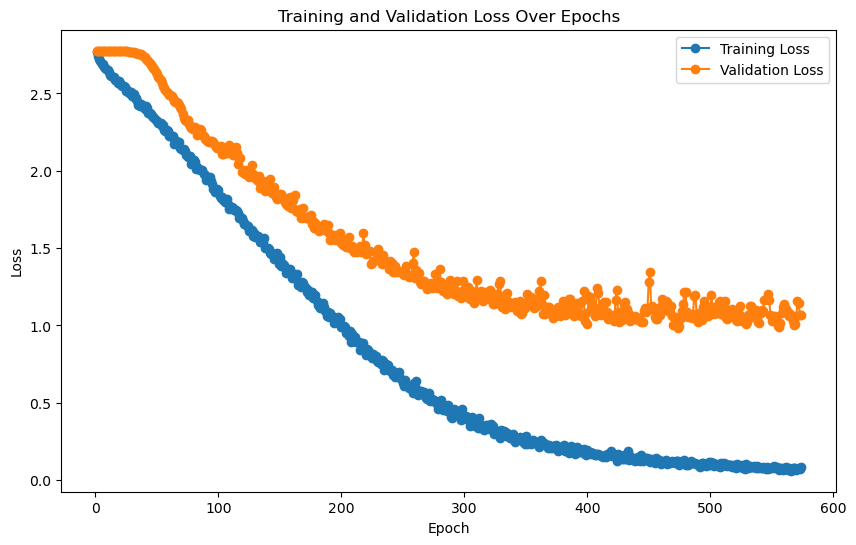

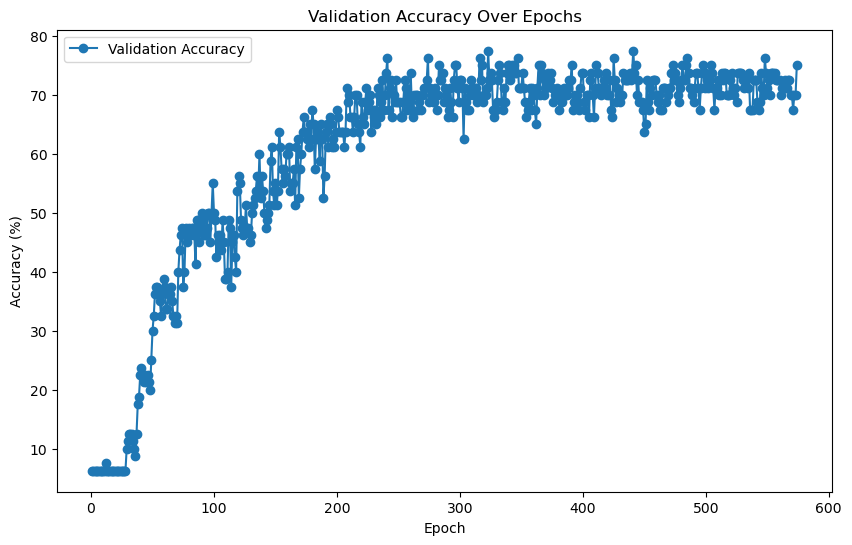


Evaluating on the test set...
    Test Batch [1/40], Loss: 2.1275

Final Test Loss: 1.5644, Test Accuracy: 60.66%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10009, 64), Test labels shape: (10009,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 56.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         5
           2       0.20      0.20      0.20         5
           3       1.00      0.60      0.75         5
           4       0.43      0.60      0.50         5
           5       0.50      0.40      0.44         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       0.71      1.

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10009, 64)
Test labels shape: (10009,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.2443  |  Val Loss: 2.9693
Validation loss improved from inf to 2.9693.
[Epoch 2/1000] Train Loss: 2.9103  |  Val Loss: 2.8039
Validation loss improved from 2.9693 to 2.8039.
[Epoch 3/1000] Train Loss: 2.7772  |  Val Loss: 2.7302
Validation loss improved from 2.8039 to 2.7302.
[Epoch 4/1000] Train Loss: 2.7049  |  Val Loss: 2.6842
Validation loss improved from 2.7302 to 2.6842.
[Epoch 5/1000] Train Loss: 2.6527  |  Val Loss: 2.6467
Validation loss improved from 2.6842 to 2.6467.
[Epoch 6/1000] Train Loss: 2.6106  |  Val Loss: 2.6204
Validation loss improved from 2.6467 to 2.6204.
[Epoch 7/1000] Train Loss: 2.5756  |  Val Loss: 2.5945
Validation loss improved from 2.6204 to 2.5945.
[Epoch 8/1000] Train Loss: 2.5427  |  Val Loss: 2.5672
Validation loss improved from 2.5945 to 2.5672.
[Epoch 9/1000] Train Loss: 2.5094  |  Val Loss: 2.5367
Validation loss improved from 2.5672 to 2.5367.


[Epoch 10/1000] Train Loss: 2.4741  |  Val Loss: 2.5013
Validation loss improved from 2.5367 to 2.5013.
[Epoch 11/1000] Train Loss: 2.4332  |  Val Loss: 2.4685
Validation loss improved from 2.5013 to 2.4685.
[Epoch 12/1000] Train Loss: 2.3916  |  Val Loss: 2.4384
Validation loss improved from 2.4685 to 2.4384.
[Epoch 13/1000] Train Loss: 2.3540  |  Val Loss: 2.4079
Validation loss improved from 2.4384 to 2.4079.
[Epoch 14/1000] Train Loss: 2.3097  |  Val Loss: 2.3688
Validation loss improved from 2.4079 to 2.3688.
[Epoch 15/1000] Train Loss: 2.2602  |  Val Loss: 2.3323
Validation loss improved from 2.3688 to 2.3323.
[Epoch 16/1000] Train Loss: 2.2159  |  Val Loss: 2.2965
Validation loss improved from 2.3323 to 2.2965.
[Epoch 17/1000] Train Loss: 2.1661  |  Val Loss: 2.2609
Validation loss improved from 2.2965 to 2.2609.
[Epoch 18/1000] Train Loss: 2.1199  |  Val Loss: 2.2214
Validation loss improved from 2.2609 to 2.2214.
[Epoch 19/1000] Train Loss: 2.0697  |  Val Loss: 2.1828
Validati

[Epoch 23/1000] Train Loss: 1.8929  |  Val Loss: 2.0542
Validation loss improved from 2.0875 to 2.0542.
[Epoch 24/1000] Train Loss: 1.8511  |  Val Loss: 2.0255
Validation loss improved from 2.0542 to 2.0255.
[Epoch 25/1000] Train Loss: 1.8174  |  Val Loss: 1.9921
Validation loss improved from 2.0255 to 1.9921.
[Epoch 26/1000] Train Loss: 1.7750  |  Val Loss: 1.9638
Validation loss improved from 1.9921 to 1.9638.
[Epoch 27/1000] Train Loss: 1.7422  |  Val Loss: 1.9329
Validation loss improved from 1.9638 to 1.9329.
[Epoch 28/1000] Train Loss: 1.7051  |  Val Loss: 1.8976
Validation loss improved from 1.9329 to 1.8976.
[Epoch 29/1000] Train Loss: 1.6674  |  Val Loss: 1.8682
Validation loss improved from 1.8976 to 1.8682.
[Epoch 30/1000] Train Loss: 1.6333  |  Val Loss: 1.8361
Validation loss improved from 1.8682 to 1.8361.


[Epoch 31/1000] Train Loss: 1.5953  |  Val Loss: 1.8090
Validation loss improved from 1.8361 to 1.8090.
[Epoch 32/1000] Train Loss: 1.5624  |  Val Loss: 1.7766
Validation loss improved from 1.8090 to 1.7766.
[Epoch 33/1000] Train Loss: 1.5276  |  Val Loss: 1.7490
Validation loss improved from 1.7766 to 1.7490.
[Epoch 34/1000] Train Loss: 1.4936  |  Val Loss: 1.7234
Validation loss improved from 1.7490 to 1.7234.
[Epoch 35/1000] Train Loss: 1.4605  |  Val Loss: 1.6928
Validation loss improved from 1.7234 to 1.6928.
[Epoch 36/1000] Train Loss: 1.4296  |  Val Loss: 1.6639
Validation loss improved from 1.6928 to 1.6639.


[Epoch 37/1000] Train Loss: 1.3946  |  Val Loss: 1.6414
Validation loss improved from 1.6639 to 1.6414.
[Epoch 38/1000] Train Loss: 1.3677  |  Val Loss: 1.6233
Validation loss improved from 1.6414 to 1.6233.
[Epoch 39/1000] Train Loss: 1.3499  |  Val Loss: 1.6001
Validation loss improved from 1.6233 to 1.6001.
[Epoch 40/1000] Train Loss: 1.3311  |  Val Loss: 1.6064
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 1.2987  |  Val Loss: 1.5678
Validation loss improved from 1.6001 to 1.5678.
[Epoch 42/1000] Train Loss: 1.2627  |  Val Loss: 1.5581
Validation loss improved from 1.5678 to 1.5581.
[Epoch 43/1000] Train Loss: 1.2489  |  Val Loss: 1.5361
Validation loss improved from 1.5581 to 1.5361.
[Epoch 44/1000] Train Loss: 1.2176  |  Val Loss: 1.5257
Validation loss improved from 1.5361 to 1.5257.
[Epoch 45/1000] Train Loss: 1.2007  |  Val Loss: 1.4919
Validation loss improved from 1.5257 to 1.4919.
[Epoch 46/1000] Train Loss: 1.1666  |  Val Loss: 1.4919
!!

[Epoch 52/1000] Train Loss: 1.0746  |  Val Loss: 1.4361
Validation loss improved from 1.4469 to 1.4361.
[Epoch 53/1000] Train Loss: 1.0523  |  Val Loss: 1.4202
Validation loss improved from 1.4361 to 1.4202.
[Epoch 54/1000] Train Loss: 1.0294  |  Val Loss: 1.4189
Validation loss improved from 1.4202 to 1.4189.
[Epoch 55/1000] Train Loss: 1.0355  |  Val Loss: 1.4104
Validation loss improved from 1.4189 to 1.4104.
[Epoch 56/1000] Train Loss: 1.0000  |  Val Loss: 1.4341
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.0143  |  Val Loss: 1.4162
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.9876  |  Val Loss: 1.3876
Validation loss improved from 1.4104 to 1.3876.
[Epoch 59/1000] Train Loss: 0.9615  |  Val Loss: 1.3872
Validation loss improved from 1.3876 to 1.3872.


[Epoch 60/1000] Train Loss: 0.9522  |  Val Loss: 1.3878
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 0.9423  |  Val Loss: 1.3857
Validation loss improved from 1.3872 to 1.3857.
[Epoch 62/1000] Train Loss: 0.9278  |  Val Loss: 1.3749
Validation loss improved from 1.3857 to 1.3749.
[Epoch 63/1000] Train Loss: 0.9119  |  Val Loss: 1.3861
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.9095  |  Val Loss: 1.3783
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 0.8993  |  Val Loss: 1.3926
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 66/1000] Train Loss: 0.8748  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 67/1000] Train Loss: 0.8874  |  Val Loss: 1.3658
Validation loss improved from 1.3749 to 1.3658.
[Epoch 68/1000] Train Loss: 0.8681  |  Val Loss: 1.3723
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.8624  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 0.8318  |  Val Loss: 1.3774
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 71/1000] Train Loss: 0.8346  |  Val Loss: 1.3611
Validation loss improved from 1.3658 to 1.3611.
[Epoch 72/1000] Train Loss: 0.8205  |  Val Loss: 1.3453
Validation loss improved from 1.3611 to 1.3453.
[Epoch 73/1000] Train Loss: 0.8096  |  Val Loss: 1.3609
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 0.7933  |  Val Loss: 1.3350
Validation loss improved from 1.3453 to 1.3350.
[Epoch 75/1000] Train Loss: 0.7772

[Epoch 81/1000] Train Loss: 0.7277  |  Val Loss: 1.3545
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 82/1000] Train Loss: 0.7192  |  Val Loss: 1.3514
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 83/1000] Train Loss: 0.6951  |  Val Loss: 1.3481
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 84/1000] Train Loss: 0.6947  |  Val Loss: 1.3403
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 85/1000] Train Loss: 0.6877  |  Val Loss: 1.3502
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 86/1000] Train Loss: 0.6689  |  Val Loss: 1.3735
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 87/1000] Train Loss: 0.6709  |  Val Loss: 1.3656
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 88/1000] Train Loss: 0.6537  |  Val Loss: 1.3485
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 89/1000] Train Loss: 0.6525  |  Val Loss: 1.3477
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 90/1000] Train Loss: 0.6388  |  Val Loss: 1.3604
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 91/1000] Train Loss: 0.6252  |  Val Loss: 1.3501
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 92/1000] Train Loss: 0.6180  |  Val Loss: 1.3376
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 93/1000] Train Loss: 0.6069  |  Val Loss: 1.3502
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 94/1000] Train Loss: 0.6125  |  Val Loss: 1.3772
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 95/1000] Train Loss: 0.5978  |  Val Loss: 1.3467
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 96/1000] Train Loss: 0.5856  |  Val Loss: 1.3632
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 97/1000] Train Loss: 0.5844  |  Val Loss: 1.3713
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 98/1000] Train Loss: 0.5729  |  Val Loss: 1.3741
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 99/1000] Train Loss: 0.5747  |  Val Loss: 1.3622
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 100/1000] Train Loss: 0.5649  |  Val Loss: 1.3598
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 101/1000] Train Loss: 0.5554  |  Val Loss: 1.3661
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 102/1000] Train Loss: 0.5560  |  Val Loss: 1.3584
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 103/1000] Train Loss: 0.5398  |  Val Loss: 1.3409
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 104/1000] Train Loss: 0.5372  |  Val Loss: 1.3649
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 105/1000] Train Loss: 0.5216  |  Val Loss: 1.4249
!! Validation loss did NOT improve !! Patience: 30

[Epoch 113/1000] Train Loss: 0.4710  |  Val Loss: 1.3917
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 114/1000] Train Loss: 0.4586  |  Val Loss: 1.4175
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 115/1000] Train Loss: 0.4680  |  Val Loss: 1.3916
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 116/1000] Train Loss: 0.4492  |  Val Loss: 1.3781
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 117/1000] Train Loss: 0.4495  |  Val Loss: 1.4028
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 118/1000] Train Loss: 0.4366  |  Val Loss: 1.4224
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 119/1000] Train Loss: 0.4329  |  Val Loss: 1.3880
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 120/1000] Train Loss: 0.4345  |  Val Loss: 1.3744
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 121/1000] Train Loss: 0.4235  |  Val Loss: 1.4006
!! Validation loss did NOT improve !! Patience:

[Epoch 122/1000] Train Loss: 0.4219  |  Val Loss: 1.4204
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 123/1000] Train Loss: 0.4092  |  Val Loss: 1.4262
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 124/1000] Train Loss: 0.4148  |  Val Loss: 1.4374
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 125/1000] Train Loss: 0.4022  |  Val Loss: 1.4363
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 126/1000] Train Loss: 0.3989  |  Val Loss: 1.4179
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 127/1000] Train Loss: 0.3879  |  Val Loss: 1.4452
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 128/1000] Train Loss: 0.3967  |  Val Loss: 1.4644
!! Validation loss did NOT improve !! Patience: 53/100


[Epoch 129/1000] Train Loss: 0.3833  |  Val Loss: 1.4623
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 130/1000] Train Loss: 0.3733  |  Val Loss: 1.4312
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 131/1000] Train Loss: 0.3709  |  Val Loss: 1.4446
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 132/1000] Train Loss: 0.3675  |  Val Loss: 1.4677
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 133/1000] Train Loss: 0.3547  |  Val Loss: 1.4693
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 134/1000] Train Loss: 0.3535  |  Val Loss: 1.4525
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 135/1000] Train Loss: 0.3483  |  Val Loss: 1.4736
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 136/1000] Train Loss: 0.3400  |  Val Loss: 1.4981
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 137/1000] Train Loss: 0.3411  |  Val Loss: 1.5007
!! Validation loss did NOT improve !! Patience:

[Epoch 141/1000] Train Loss: 0.3307  |  Val Loss: 1.4901
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 142/1000] Train Loss: 0.3184  |  Val Loss: 1.5112
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 143/1000] Train Loss: 0.3140  |  Val Loss: 1.5208
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 144/1000] Train Loss: 0.3169  |  Val Loss: 1.5165
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 145/1000] Train Loss: 0.3052  |  Val Loss: 1.5089
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 146/1000] Train Loss: 0.3044  |  Val Loss: 1.4934
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 147/1000] Train Loss: 0.3057  |  Val Loss: 1.5256
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 148/1000] Train Loss: 0.3036  |  Val Loss: 1.5705
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 149/1000] Train Loss: 0.2945  |  Val Loss: 1.5486
!! Validation loss did NOT improve !! Patience:

[Epoch 151/1000] Train Loss: 0.2859  |  Val Loss: 1.5719
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 152/1000] Train Loss: 0.2818  |  Val Loss: 1.5903
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 153/1000] Train Loss: 0.2784  |  Val Loss: 1.5865
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 154/1000] Train Loss: 0.2735  |  Val Loss: 1.5860
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 155/1000] Train Loss: 0.2742  |  Val Loss: 1.5591
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 156/1000] Train Loss: 0.2698  |  Val Loss: 1.5623
!! Validation loss did NOT improve !! Patience: 81/100


[Epoch 157/1000] Train Loss: 0.2611  |  Val Loss: 1.5987
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 158/1000] Train Loss: 0.2592  |  Val Loss: 1.6235
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 159/1000] Train Loss: 0.2505  |  Val Loss: 1.5889
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 160/1000] Train Loss: 0.2651  |  Val Loss: 1.6092
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 161/1000] Train Loss: 0.2490  |  Val Loss: 1.6739
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 162/1000] Train Loss: 0.2548  |  Val Loss: 1.6383
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 163/1000] Train Loss: 0.2408  |  Val Loss: 1.6000
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 164/1000] Train Loss: 0.2444  |  Val Loss: 1.6096
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 165/1000] Train Loss: 0.2397  |  Val Loss: 1.6498
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.2298  |  Val Loss: 1.6518
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 170/1000] Train Loss: 0.2241  |  Val Loss: 1.6616
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 171/1000] Train Loss: 0.2190  |  Val Loss: 1.6490
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 172/1000] Train Loss: 0.2179  |  Val Loss: 1.6636
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 173/1000] Train Loss: 0.2207  |  Val Loss: 1.6736
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 174/1000] Train Loss: 0.2129  |  Val Loss: 1.6586
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 175/1000] Train Loss: 0.2190  |  Val Loss: 1.6804
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 175 !!
No improvement for 100 epochs.


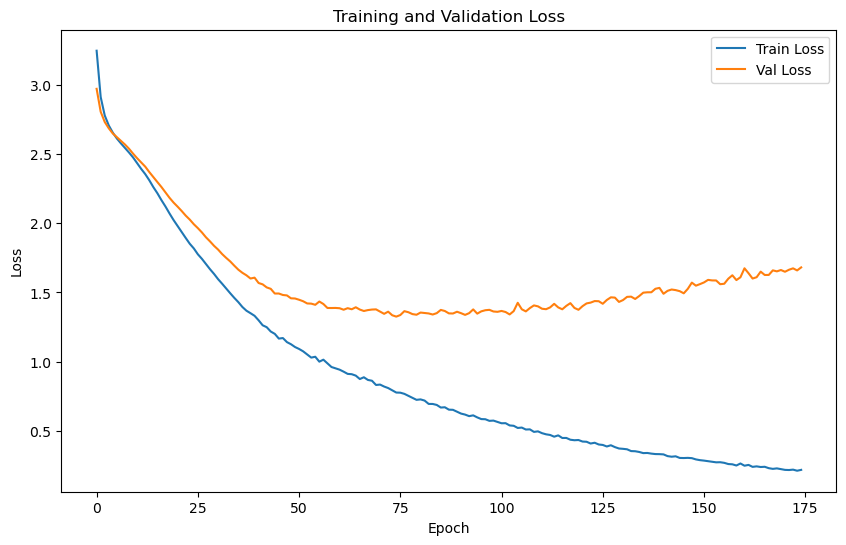

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6596 | Test Accuracy: 45.81%


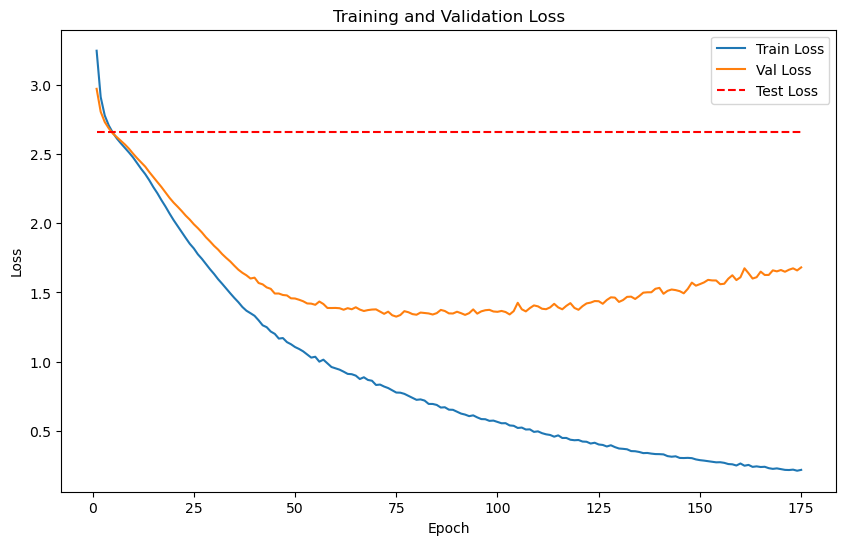

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.2635
Epoch [1/2000], Avg Train Loss: 9.2635
Epoch [1/2000], Avg Val Loss: 5.1190
Validation loss improved from inf to 5.1190. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.1189
Epoch [2/2000], Avg Train Loss: 9.1189
Epoch [2/2000], Avg Val Loss: 5.0677
Validation loss improved from 5.1190 to 5.0677. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.9212
Epoch [3/2000], Avg Train Loss: 8.9212
Epoch [3/2000], Avg Val Loss: 5.0177
Validation loss improved from 5.0677 to 5.0177. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1539
Epoch [4/2000], Avg Train Loss: 9.1539
Epoch [4/2000], Avg Val Loss: 4.9693
Validation loss improved from 5.0177 to 4.9693. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7888
Epoch [5/2000], Avg Train Loss: 8.7888
Epoch [5/2000], Avg Val Loss: 4.9221
Validation loss improved from 4.9693 to 4.9221. Saving mode

    Batch [1/1], Train Loss: 8.1911
Epoch [13/2000], Avg Train Loss: 8.1911
Epoch [13/2000], Avg Val Loss: 4.5846
Validation loss improved from 4.6230 to 4.5846. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.1297
Epoch [14/2000], Avg Train Loss: 8.1297
Epoch [14/2000], Avg Val Loss: 4.5473
Validation loss improved from 4.5846 to 4.5473. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.1118
Epoch [15/2000], Avg Train Loss: 8.1118
Epoch [15/2000], Avg Val Loss: 4.5108
Validation loss improved from 4.5473 to 4.5108. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.2278
Epoch [16/2000], Avg Train Loss: 8.2278
Epoch [16/2000], Avg Val Loss: 4.4755
Validation loss improved from 4.5108 to 4.4755. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.9592
Epoch [17/2000], Avg Train Loss: 7.9592
Epoch [17/2000], Avg Val Loss: 4.4413
Validation loss improved from 4.4755 to 4.

Epoch [22/2000], Avg Val Loss: 4.2845
Validation loss improved from 4.3140 to 4.2845. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.6864
Epoch [23/2000], Avg Train Loss: 7.6864
Epoch [23/2000], Avg Val Loss: 4.2560
Validation loss improved from 4.2845 to 4.2560. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.4442
Epoch [24/2000], Avg Train Loss: 7.4442
Epoch [24/2000], Avg Val Loss: 4.2282
Validation loss improved from 4.2560 to 4.2282. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.3972
Epoch [25/2000], Avg Train Loss: 7.3972
Epoch [25/2000], Avg Val Loss: 4.2014
Validation loss improved from 4.2282 to 4.2014. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.3693
Epoch [26/2000], Avg Train Loss: 7.3693
Epoch [26/2000], Avg Val Loss: 4.1753
Validation loss improved from 4.2014 to 4.1753. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Trai

Epoch [43/2000], Avg Val Loss: 3.8478
Validation loss improved from 3.8617 to 3.8478. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.4108
Epoch [44/2000], Avg Train Loss: 6.4108
Epoch [44/2000], Avg Val Loss: 3.8345
Validation loss improved from 3.8478 to 3.8345. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.2482
Epoch [45/2000], Avg Train Loss: 6.2482
Epoch [45/2000], Avg Val Loss: 3.8218
Validation loss improved from 3.8345 to 3.8218. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.2364
Epoch [46/2000], Avg Train Loss: 6.2364
Epoch [46/2000], Avg Val Loss: 3.8096
Validation loss improved from 3.8218 to 3.8096. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2490
Epoch [47/2000], Avg Train Loss: 6.2490
Epoch [47/2000], Avg Val Loss: 3.7979
Validation loss improved from 3.8096 to 3.7979. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Trai

Epoch [55/2000], Avg Val Loss: 3.7203
Validation loss improved from 3.7286 to 3.7203. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.9386
Epoch [56/2000], Avg Train Loss: 5.9386
Epoch [56/2000], Avg Val Loss: 3.7124
Validation loss improved from 3.7203 to 3.7124. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.9127
Epoch [57/2000], Avg Train Loss: 5.9127
Epoch [57/2000], Avg Val Loss: 3.7049
Validation loss improved from 3.7124 to 3.7049. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.8076
Epoch [58/2000], Avg Train Loss: 5.8076
Epoch [58/2000], Avg Val Loss: 3.6977
Validation loss improved from 3.7049 to 3.6977. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.7307
Epoch [59/2000], Avg Train Loss: 5.7307
Epoch [59/2000], Avg Val Loss: 3.6908
Validation loss improved from 3.6977 to 3.6908. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Trai

Epoch [67/2000], Avg Val Loss: 3.6461
Validation loss improved from 3.6507 to 3.6461. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.6290
Epoch [68/2000], Avg Train Loss: 5.6290
Epoch [68/2000], Avg Val Loss: 3.6416
Validation loss improved from 3.6461 to 3.6416. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.6087
Epoch [69/2000], Avg Train Loss: 5.6087
Epoch [69/2000], Avg Val Loss: 3.6374
Validation loss improved from 3.6416 to 3.6374. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.4548
Epoch [70/2000], Avg Train Loss: 5.4548
Epoch [70/2000], Avg Val Loss: 3.6333
Validation loss improved from 3.6374 to 3.6333. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.5132
Epoch [71/2000], Avg Train Loss: 5.5132
Epoch [71/2000], Avg Val Loss: 3.6295
Validation loss improved from 3.6333 to 3.6295. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0998
Epoch [89/2000], Avg Train Loss: 5.0998
Epoch [89/2000], Avg Val Loss: 3.5818
Validation loss improved from 3.5837 to 3.5818. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2730
Epoch [90/2000], Avg Train Loss: 5.2730
Epoch [90/2000], Avg Val Loss: 3.5801
Validation loss improved from 3.5818 to 3.5801. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.1188
Epoch [91/2000], Avg Train Loss: 5.1188
Epoch [91/2000], Avg Val Loss: 3.5783
Validation loss improved from 3.5801 to 3.5783. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.1811
Epoch [92/2000], Avg Train Loss: 5.1811
Epoch [92/2000], Avg Val Loss: 3.5767
Validation loss improved from 3.5783 to 3.5767. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.1062
Epoch [93/2000], Avg Train Loss: 5.1062
Epoch [93/2000], Avg Val Loss: 3.5751
Validation loss improved from 3.5767 to 3.

Epoch [98/2000], Avg Val Loss: 3.5679
Validation loss improved from 3.5692 to 3.5679. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.0406
Epoch [99/2000], Avg Train Loss: 5.0406
Epoch [99/2000], Avg Val Loss: 3.5666
Validation loss improved from 3.5679 to 3.5666. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 5.0278
Epoch [100/2000], Avg Train Loss: 5.0278
Epoch [100/2000], Avg Val Loss: 3.5653
Validation loss improved from 3.5666 to 3.5653. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 5.0214
Epoch [101/2000], Avg Train Loss: 5.0214
Epoch [101/2000], Avg Val Loss: 3.5640
Validation loss improved from 3.5653 to 3.5640. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 5.0233
Epoch [102/2000], Avg Train Loss: 5.0233
Epoch [102/2000], Avg Val Loss: 3.5627
Validation loss improved from 3.5640 to 3.5627. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [

    Batch [1/1], Train Loss: 4.9998
Epoch [108/2000], Avg Train Loss: 4.9998
Epoch [108/2000], Avg Val Loss: 3.5557
Validation loss improved from 3.5568 to 3.5557. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9482
Epoch [109/2000], Avg Train Loss: 4.9482
Epoch [109/2000], Avg Val Loss: 3.5546
Validation loss improved from 3.5557 to 3.5546. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.9324
Epoch [110/2000], Avg Train Loss: 4.9324
Epoch [110/2000], Avg Val Loss: 3.5536
Validation loss improved from 3.5546 to 3.5536. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9582
Epoch [111/2000], Avg Train Loss: 4.9582
Epoch [111/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5536 to 3.5525. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.9858
Epoch [112/2000], Avg Train Loss: 4.9858
Epoch [112/2000], Avg Val Loss: 3.5515
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7852
Epoch [133/2000], Avg Train Loss: 4.7852
Epoch [133/2000], Avg Val Loss: 3.5319
Validation loss improved from 3.5329 to 3.5319. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.7693
Epoch [134/2000], Avg Train Loss: 4.7693
Epoch [134/2000], Avg Val Loss: 3.5310
Validation loss improved from 3.5319 to 3.5310. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.7861
Epoch [135/2000], Avg Train Loss: 4.7861
Epoch [135/2000], Avg Val Loss: 3.5301
Validation loss improved from 3.5310 to 3.5301. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.8052
Epoch [136/2000], Avg Train Loss: 4.8052
Epoch [136/2000], Avg Val Loss: 3.5292
Validation loss improved from 3.5301 to 3.5292. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.8147
Epoch [137/2000], Avg Train Loss: 4.8147
Epoch [137/2000], Avg Val Loss: 3.5283
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8739
Epoch [141/2000], Avg Train Loss: 4.8739
Epoch [141/2000], Avg Val Loss: 3.5245
Validation loss improved from 3.5255 to 3.5245. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.7172
Epoch [142/2000], Avg Train Loss: 4.7172
Epoch [142/2000], Avg Val Loss: 3.5236
Validation loss improved from 3.5245 to 3.5236. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.7755
Epoch [143/2000], Avg Train Loss: 4.7755
Epoch [143/2000], Avg Val Loss: 3.5227
Validation loss improved from 3.5236 to 3.5227. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.8094
Epoch [144/2000], Avg Train Loss: 4.8094
Epoch [144/2000], Avg Val Loss: 3.5217
Validation loss improved from 3.5227 to 3.5217. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.7529
Epoch [145/2000], Avg Train Loss: 4.7529
Epoch [145/2000], Avg Val Loss: 3.5208
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7837
Epoch [146/2000], Avg Train Loss: 4.7837
Epoch [146/2000], Avg Val Loss: 3.5199
Validation loss improved from 3.5208 to 3.5199. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.7186
Epoch [147/2000], Avg Train Loss: 4.7186
Epoch [147/2000], Avg Val Loss: 3.5190
Validation loss improved from 3.5199 to 3.5190. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6853
Epoch [148/2000], Avg Train Loss: 4.6853
Epoch [148/2000], Avg Val Loss: 3.5180
Validation loss improved from 3.5190 to 3.5180. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.8128
Epoch [149/2000], Avg Train Loss: 4.8128
Epoch [149/2000], Avg Val Loss: 3.5171
Validation loss improved from 3.5180 to 3.5171. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.7741
Epoch [150/2000], Avg Train Loss: 4.7741
Epoch [150/2000], Avg Val Loss: 3.5161
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6814
Epoch [170/2000], Avg Train Loss: 4.6814
Epoch [170/2000], Avg Val Loss: 3.4976
Validation loss improved from 3.4985 to 3.4976. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.7063
Epoch [171/2000], Avg Train Loss: 4.7063
Epoch [171/2000], Avg Val Loss: 3.4967
Validation loss improved from 3.4976 to 3.4967. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.6717
Epoch [172/2000], Avg Train Loss: 4.6717
Epoch [172/2000], Avg Val Loss: 3.4958
Validation loss improved from 3.4967 to 3.4958. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.6782
Epoch [173/2000], Avg Train Loss: 4.6782
Epoch [173/2000], Avg Val Loss: 3.4949
Validation loss improved from 3.4958 to 3.4949. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.7134
Epoch [174/2000], Avg Train Loss: 4.7134
Epoch [174/2000], Avg Val Loss: 3.4941
Validation loss improved fro

Epoch [180/2000], Avg Val Loss: 3.4882
Validation loss improved from 3.4892 to 3.4882. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.6734
Epoch [181/2000], Avg Train Loss: 4.6734
Epoch [181/2000], Avg Val Loss: 3.4873
Validation loss improved from 3.4882 to 3.4873. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.6220
Epoch [182/2000], Avg Train Loss: 4.6220
Epoch [182/2000], Avg Val Loss: 3.4863
Validation loss improved from 3.4873 to 3.4863. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.6541
Epoch [183/2000], Avg Train Loss: 4.6541
Epoch [183/2000], Avg Val Loss: 3.4853
Validation loss improved from 3.4863 to 3.4853. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.6821
Epoch [184/2000], Avg Train Loss: 4.6821
Epoch [184/2000], Avg Val Loss: 3.4843
Validation loss improved from 3.4853 to 3.4843. Saving model...

LOG: Epoch [185/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6330
Epoch [186/2000], Avg Train Loss: 4.6330
Epoch [186/2000], Avg Val Loss: 3.4824
Validation loss improved from 3.4833 to 3.4824. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.5605
Epoch [187/2000], Avg Train Loss: 4.5605
Epoch [187/2000], Avg Val Loss: 3.4814
Validation loss improved from 3.4824 to 3.4814. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.6742
Epoch [188/2000], Avg Train Loss: 4.6742
Epoch [188/2000], Avg Val Loss: 3.4804
Validation loss improved from 3.4814 to 3.4804. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.6060
Epoch [189/2000], Avg Train Loss: 4.6060
Epoch [189/2000], Avg Val Loss: 3.4794
Validation loss improved from 3.4804 to 3.4794. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.6081
Epoch [190/2000], Avg Train Loss: 4.6081
Epoch [190/2000], Avg Val Loss: 3.4784
Validation loss improved fro

Epoch [211/2000], Avg Val Loss: 3.4561
Validation loss improved from 3.4572 to 3.4561. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.5511
Epoch [212/2000], Avg Train Loss: 4.5511
Epoch [212/2000], Avg Val Loss: 3.4550
Validation loss improved from 3.4561 to 3.4550. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.5650
Epoch [213/2000], Avg Train Loss: 4.5650
Epoch [213/2000], Avg Val Loss: 3.4539
Validation loss improved from 3.4550 to 3.4539. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.5220
Epoch [214/2000], Avg Train Loss: 4.5220
Epoch [214/2000], Avg Val Loss: 3.4528
Validation loss improved from 3.4539 to 3.4528. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.5443
Epoch [215/2000], Avg Train Loss: 4.5443
Epoch [215/2000], Avg Val Loss: 3.4516
Validation loss improved from 3.4528 to 3.4516. Saving model...

LOG: Epoch [216/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5004
Epoch [224/2000], Avg Train Loss: 4.5004
Epoch [224/2000], Avg Val Loss: 3.4419
Validation loss improved from 3.4430 to 3.4419. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 4.4851
Epoch [225/2000], Avg Train Loss: 4.4851
Epoch [225/2000], Avg Val Loss: 3.4408
Validation loss improved from 3.4419 to 3.4408. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.4770
Epoch [226/2000], Avg Train Loss: 4.4770
Epoch [226/2000], Avg Val Loss: 3.4397
Validation loss improved from 3.4408 to 3.4397. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.5062
Epoch [227/2000], Avg Train Loss: 4.5062
Epoch [227/2000], Avg Val Loss: 3.4386
Validation loss improved from 3.4397 to 3.4386. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.4936
Epoch [228/2000], Avg Train Loss: 4.4936
Epoch [228/2000], Avg Val Loss: 3.4375
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5053
Epoch [253/2000], Avg Train Loss: 4.5053
Epoch [253/2000], Avg Val Loss: 3.4083
Validation loss improved from 3.4094 to 3.4083. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.4395
Epoch [254/2000], Avg Train Loss: 4.4395
Epoch [254/2000], Avg Val Loss: 3.4072
Validation loss improved from 3.4083 to 3.4072. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.4541
Epoch [255/2000], Avg Train Loss: 4.4541
Epoch [255/2000], Avg Val Loss: 3.4061
Validation loss improved from 3.4072 to 3.4061. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.4228
Epoch [256/2000], Avg Train Loss: 4.4228
Epoch [256/2000], Avg Val Loss: 3.4049
Validation loss improved from 3.4061 to 3.4049. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.4405
Epoch [257/2000], Avg Train Loss: 4.4405
Epoch [257/2000], Avg Val Loss: 3.4038
Validation loss improved fro

Epoch [263/2000], Avg Val Loss: 3.3973
Validation loss improved from 3.3983 to 3.3973. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.5018
Epoch [264/2000], Avg Train Loss: 4.5018
Epoch [264/2000], Avg Val Loss: 3.3962
Validation loss improved from 3.3973 to 3.3962. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.4188
Epoch [265/2000], Avg Train Loss: 4.4188
Epoch [265/2000], Avg Val Loss: 3.3952
Validation loss improved from 3.3962 to 3.3952. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.3995
Epoch [266/2000], Avg Train Loss: 4.3995
Epoch [266/2000], Avg Val Loss: 3.3941
Validation loss improved from 3.3952 to 3.3941. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.4141
Epoch [267/2000], Avg Train Loss: 4.4141
Epoch [267/2000], Avg Val Loss: 3.3930
Validation loss improved from 3.3941 to 3.3930. Saving model...

LOG: Epoch [268/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3290
Epoch [297/2000], Avg Train Loss: 4.3290
Epoch [297/2000], Avg Val Loss: 3.3622
Validation loss improved from 3.3631 to 3.3622. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.3855
Epoch [298/2000], Avg Train Loss: 4.3855
Epoch [298/2000], Avg Val Loss: 3.3612
Validation loss improved from 3.3622 to 3.3612. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.3607
Epoch [299/2000], Avg Train Loss: 4.3607
Epoch [299/2000], Avg Val Loss: 3.3603
Validation loss improved from 3.3612 to 3.3603. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.3236
Epoch [300/2000], Avg Train Loss: 4.3236
Epoch [300/2000], Avg Val Loss: 3.3593
Validation loss improved from 3.3603 to 3.3593. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.3075
Epoch [301/2000], Avg Train Loss: 4.3075
Epoch [301/2000], Avg Val Loss: 3.3583
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3894
Epoch [311/2000], Avg Train Loss: 4.3894
Epoch [311/2000], Avg Val Loss: 3.3490
Validation loss improved from 3.3500 to 3.3490. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 4.3732
Epoch [312/2000], Avg Train Loss: 4.3732
Epoch [312/2000], Avg Val Loss: 3.3481
Validation loss improved from 3.3490 to 3.3481. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.3564
Epoch [313/2000], Avg Train Loss: 4.3564
Epoch [313/2000], Avg Val Loss: 3.3472
Validation loss improved from 3.3481 to 3.3472. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.3311
Epoch [314/2000], Avg Train Loss: 4.3311
Epoch [314/2000], Avg Val Loss: 3.3463
Validation loss improved from 3.3472 to 3.3463. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.2765
Epoch [315/2000], Avg Train Loss: 4.2765
Epoch [315/2000], Avg Val Loss: 3.3455
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3374
Epoch [338/2000], Avg Train Loss: 4.3374
Epoch [338/2000], Avg Val Loss: 3.3263
Validation loss improved from 3.3272 to 3.3263. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.2897
Epoch [339/2000], Avg Train Loss: 4.2897
Epoch [339/2000], Avg Val Loss: 3.3255
Validation loss improved from 3.3263 to 3.3255. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.2916
Epoch [340/2000], Avg Train Loss: 4.2916
Epoch [340/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3255 to 3.3247. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.3256
Epoch [341/2000], Avg Train Loss: 4.3256
Epoch [341/2000], Avg Val Loss: 3.3239
Validation loss improved from 3.3247 to 3.3239. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.3198
Epoch [342/2000], Avg Train Loss: 4.3198
Epoch [342/2000], Avg Val Loss: 3.3231
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2630
Epoch [351/2000], Avg Train Loss: 4.2630
Epoch [351/2000], Avg Val Loss: 3.3156
Validation loss improved from 3.3164 to 3.3156. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.2213
Epoch [352/2000], Avg Train Loss: 4.2213
Epoch [352/2000], Avg Val Loss: 3.3148
Validation loss improved from 3.3156 to 3.3148. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.2876
Epoch [353/2000], Avg Train Loss: 4.2876
Epoch [353/2000], Avg Val Loss: 3.3139
Validation loss improved from 3.3148 to 3.3139. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 4.2562
Epoch [354/2000], Avg Train Loss: 4.2562
Epoch [354/2000], Avg Val Loss: 3.3131
Validation loss improved from 3.3139 to 3.3131. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.3548
Epoch [355/2000], Avg Train Loss: 4.3548
Epoch [355/2000], Avg Val Loss: 3.3123
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2843
Epoch [377/2000], Avg Train Loss: 4.2843
Epoch [377/2000], Avg Val Loss: 3.2952
Validation loss improved from 3.2960 to 3.2952. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.2726
Epoch [378/2000], Avg Train Loss: 4.2726
Epoch [378/2000], Avg Val Loss: 3.2945
Validation loss improved from 3.2952 to 3.2945. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.2563
Epoch [379/2000], Avg Train Loss: 4.2563
Epoch [379/2000], Avg Val Loss: 3.2937
Validation loss improved from 3.2945 to 3.2937. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.2300
Epoch [380/2000], Avg Train Loss: 4.2300
Epoch [380/2000], Avg Val Loss: 3.2929
Validation loss improved from 3.2937 to 3.2929. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.2125
Epoch [381/2000], Avg Train Loss: 4.2125
Epoch [381/2000], Avg Val Loss: 3.2921
Validation loss improved fro

Epoch [389/2000], Avg Val Loss: 3.2865
Validation loss improved from 3.2872 to 3.2865. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.1802
Epoch [390/2000], Avg Train Loss: 4.1802
Epoch [390/2000], Avg Val Loss: 3.2858
Validation loss improved from 3.2865 to 3.2858. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.1938
Epoch [391/2000], Avg Train Loss: 4.1938
Epoch [391/2000], Avg Val Loss: 3.2851
Validation loss improved from 3.2858 to 3.2851. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.2321
Epoch [392/2000], Avg Train Loss: 4.2321
Epoch [392/2000], Avg Val Loss: 3.2844
Validation loss improved from 3.2851 to 3.2844. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.1607
Epoch [393/2000], Avg Train Loss: 4.1607
Epoch [393/2000], Avg Val Loss: 3.2837
Validation loss improved from 3.2844 to 3.2837. Saving model...

LOG: Epoch [394/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1453
Epoch [421/2000], Avg Train Loss: 4.1453
Epoch [421/2000], Avg Val Loss: 3.2649
Validation loss improved from 3.2656 to 3.2649. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.1477
Epoch [422/2000], Avg Train Loss: 4.1477
Epoch [422/2000], Avg Val Loss: 3.2643
Validation loss improved from 3.2649 to 3.2643. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.1737
Epoch [423/2000], Avg Train Loss: 4.1737
Epoch [423/2000], Avg Val Loss: 3.2637
Validation loss improved from 3.2643 to 3.2637. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.1768
Epoch [424/2000], Avg Train Loss: 4.1768
Epoch [424/2000], Avg Val Loss: 3.2630
Validation loss improved from 3.2637 to 3.2630. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.1222
Epoch [425/2000], Avg Train Loss: 4.1222
Epoch [425/2000], Avg Val Loss: 3.2624
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1972
Epoch [430/2000], Avg Train Loss: 4.1972
Epoch [430/2000], Avg Val Loss: 3.2595
Validation loss improved from 3.2601 to 3.2595. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.1707
Epoch [431/2000], Avg Train Loss: 4.1707
Epoch [431/2000], Avg Val Loss: 3.2589
Validation loss improved from 3.2595 to 3.2589. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.1424
Epoch [432/2000], Avg Train Loss: 4.1424
Epoch [432/2000], Avg Val Loss: 3.2583
Validation loss improved from 3.2589 to 3.2583. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.2214
Epoch [433/2000], Avg Train Loss: 4.2214
Epoch [433/2000], Avg Val Loss: 3.2577
Validation loss improved from 3.2583 to 3.2577. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.1744
Epoch [434/2000], Avg Train Loss: 4.1744
Epoch [434/2000], Avg Val Loss: 3.2572
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0937
Epoch [462/2000], Avg Train Loss: 4.0937
Epoch [462/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2422 to 3.2417. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.1431
Epoch [463/2000], Avg Train Loss: 4.1431
Epoch [463/2000], Avg Val Loss: 3.2413
Validation loss improved from 3.2417 to 3.2413. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.1163
Epoch [464/2000], Avg Train Loss: 4.1163
Epoch [464/2000], Avg Val Loss: 3.2408
Validation loss improved from 3.2413 to 3.2408. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.0755
Epoch [465/2000], Avg Train Loss: 4.0755
Epoch [465/2000], Avg Val Loss: 3.2404
Validation loss improved from 3.2408 to 3.2404. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.1062
Epoch [466/2000], Avg Train Loss: 4.1062
Epoch [466/2000], Avg Val Loss: 3.2399
Validation loss improved fro

Epoch [470/2000], Avg Val Loss: 3.2381
Validation loss improved from 3.2385 to 3.2381. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.1101
Epoch [471/2000], Avg Train Loss: 4.1101
Epoch [471/2000], Avg Val Loss: 3.2377
Validation loss improved from 3.2381 to 3.2377. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.1060
Epoch [472/2000], Avg Train Loss: 4.1060
Epoch [472/2000], Avg Val Loss: 3.2372
Validation loss improved from 3.2377 to 3.2372. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.0519
Epoch [473/2000], Avg Train Loss: 4.0519
Epoch [473/2000], Avg Val Loss: 3.2368
Validation loss improved from 3.2372 to 3.2368. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.0910
Epoch [474/2000], Avg Train Loss: 4.0910
Epoch [474/2000], Avg Val Loss: 3.2363
Validation loss improved from 3.2368 to 3.2363. Saving model...

LOG: Epoch [475/2000] - Training
    Bat

Epoch [507/2000], Avg Val Loss: 3.2229
Validation loss improved from 3.2232 to 3.2229. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.0327
Epoch [508/2000], Avg Train Loss: 4.0327
Epoch [508/2000], Avg Val Loss: 3.2225
Validation loss improved from 3.2229 to 3.2225. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.0352
Epoch [509/2000], Avg Train Loss: 4.0352
Epoch [509/2000], Avg Val Loss: 3.2221
Validation loss improved from 3.2225 to 3.2221. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 4.0261
Epoch [510/2000], Avg Train Loss: 4.0261
Epoch [510/2000], Avg Val Loss: 3.2217
Validation loss improved from 3.2221 to 3.2217. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.1012
Epoch [511/2000], Avg Train Loss: 4.1012
Epoch [511/2000], Avg Val Loss: 3.2213
Validation loss improved from 3.2217 to 3.2213. Saving model...

LOG: Epoch [512/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9588
Epoch [548/2000], Avg Train Loss: 3.9588
Epoch [548/2000], Avg Val Loss: 3.2063
Validation loss improved from 3.2067 to 3.2063. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.0165
Epoch [549/2000], Avg Train Loss: 4.0165
Epoch [549/2000], Avg Val Loss: 3.2059
Validation loss improved from 3.2063 to 3.2059. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.0565
Epoch [550/2000], Avg Train Loss: 4.0565
Epoch [550/2000], Avg Val Loss: 3.2055
Validation loss improved from 3.2059 to 3.2055. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.9828
Epoch [551/2000], Avg Train Loss: 3.9828
Epoch [551/2000], Avg Val Loss: 3.2050
Validation loss improved from 3.2055 to 3.2050. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.9961
Epoch [552/2000], Avg Train Loss: 3.9961
Epoch [552/2000], Avg Val Loss: 3.2046
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9346
Epoch [592/2000], Avg Train Loss: 3.9346
Epoch [592/2000], Avg Val Loss: 3.1936
Validation loss improved from 3.1938 to 3.1936. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.9799
Epoch [593/2000], Avg Train Loss: 3.9799
Epoch [593/2000], Avg Val Loss: 3.1933
Validation loss improved from 3.1936 to 3.1933. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 3.9370
Epoch [594/2000], Avg Train Loss: 3.9370
Epoch [594/2000], Avg Val Loss: 3.1931
Validation loss improved from 3.1933 to 3.1931. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.9645
Epoch [595/2000], Avg Train Loss: 3.9645
Epoch [595/2000], Avg Val Loss: 3.1929
Validation loss improved from 3.1931 to 3.1929. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.9634
Epoch [596/2000], Avg Train Loss: 3.9634
Epoch [596/2000], Avg Val Loss: 3.1926
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9055
Epoch [637/2000], Avg Train Loss: 3.9055
Epoch [637/2000], Avg Val Loss: 3.1854
Validation loss improved from 3.1856 to 3.1854. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.8758
Epoch [638/2000], Avg Train Loss: 3.8758
Epoch [638/2000], Avg Val Loss: 3.1852
Validation loss improved from 3.1854 to 3.1852. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.9428
Epoch [639/2000], Avg Train Loss: 3.9428
Epoch [639/2000], Avg Val Loss: 3.1849
Validation loss improved from 3.1852 to 3.1849. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.8935
Epoch [640/2000], Avg Train Loss: 3.8935
Epoch [640/2000], Avg Val Loss: 3.1847
Validation loss improved from 3.1849 to 3.1847. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.9362
Epoch [641/2000], Avg Train Loss: 3.9362
Epoch [641/2000], Avg Val Loss: 3.1844
Validation loss improved fro

Epoch [681/2000], Avg Val Loss: 3.1777
Validation loss improved from 3.1779 to 3.1777. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.8749
Epoch [682/2000], Avg Train Loss: 3.8749
Epoch [682/2000], Avg Val Loss: 3.1775
Validation loss improved from 3.1777 to 3.1775. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.8921
Epoch [683/2000], Avg Train Loss: 3.8921
Epoch [683/2000], Avg Val Loss: 3.1773
Validation loss improved from 3.1775 to 3.1773. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.8824
Epoch [684/2000], Avg Train Loss: 3.8824
Epoch [684/2000], Avg Val Loss: 3.1772
Validation loss improved from 3.1773 to 3.1772. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.8513
Epoch [685/2000], Avg Train Loss: 3.8513
Epoch [685/2000], Avg Val Loss: 3.1771
Validation loss improved from 3.1772 to 3.1771. Saving model...

LOG: Epoch [686/2000] - Training
    Bat

Epoch [723/2000], Avg Val Loss: 3.1717
Validation loss did not improve. Patience: 4/100

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.8049
Epoch [724/2000], Avg Train Loss: 3.8049
Epoch [724/2000], Avg Val Loss: 3.1718
Validation loss did not improve. Patience: 5/100

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.8115
Epoch [725/2000], Avg Train Loss: 3.8115
Epoch [725/2000], Avg Val Loss: 3.1719
Validation loss did not improve. Patience: 6/100

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.8271
Epoch [726/2000], Avg Train Loss: 3.8271
Epoch [726/2000], Avg Val Loss: 3.1719
Validation loss did not improve. Patience: 7/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.8427
Epoch [727/2000], Avg Train Loss: 3.8427
Epoch [727/2000], Avg Val Loss: 3.1719
Validation loss did not improve. Patience: 8/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.8245
Epoch [728/2000], Avg Train Loss: 3.8245
Epoch

Epoch [767/2000], Avg Val Loss: 3.1676
Validation loss improved from 3.1677 to 3.1676. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.8463
Epoch [768/2000], Avg Train Loss: 3.8463
Epoch [768/2000], Avg Val Loss: 3.1674
Validation loss improved from 3.1676 to 3.1674. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.8273
Epoch [769/2000], Avg Train Loss: 3.8273
Epoch [769/2000], Avg Val Loss: 3.1673
Validation loss improved from 3.1674 to 3.1673. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.7619
Epoch [770/2000], Avg Train Loss: 3.7619
Epoch [770/2000], Avg Val Loss: 3.1671
Validation loss improved from 3.1673 to 3.1671. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.7704
Epoch [771/2000], Avg Train Loss: 3.7704
Epoch [771/2000], Avg Val Loss: 3.1669
Validation loss improved from 3.1671 to 3.1669. Saving model...

LOG: Epoch [772/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7889
Epoch [811/2000], Avg Train Loss: 3.7889
Epoch [811/2000], Avg Val Loss: 3.1650
Validation loss improved from 3.1651 to 3.1650. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.7426
Epoch [812/2000], Avg Train Loss: 3.7426
Epoch [812/2000], Avg Val Loss: 3.1648
Validation loss improved from 3.1650 to 3.1648. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.7814
Epoch [813/2000], Avg Train Loss: 3.7814
Epoch [813/2000], Avg Val Loss: 3.1646
Validation loss improved from 3.1648 to 3.1646. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.7172
Epoch [814/2000], Avg Train Loss: 3.7172
Epoch [814/2000], Avg Val Loss: 3.1645
Validation loss improved from 3.1646 to 3.1645. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.7993
Epoch [815/2000], Avg Train Loss: 3.7993
Epoch [815/2000], Avg Val Loss: 3.1643
Validation loss improved fro

Epoch [855/2000], Avg Val Loss: 3.1584
Validation loss improved from 3.1585 to 3.1584. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.7782
Epoch [856/2000], Avg Train Loss: 3.7782
Epoch [856/2000], Avg Val Loss: 3.1584
Validation loss improved from 3.1584 to 3.1584. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.7163
Epoch [857/2000], Avg Train Loss: 3.7163
Epoch [857/2000], Avg Val Loss: 3.1584
Validation loss did not improve. Patience: 1/100

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [858/2000], Avg Train Loss: 3.7437
Epoch [858/2000], Avg Val Loss: 3.1584
Validation loss improved from 3.1584 to 3.1584. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.7399
Epoch [859/2000], Avg Train Loss: 3.7399
Epoch [859/2000], Avg Val Loss: 3.1583
Validation loss improved from 3.1584 to 3.1583. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train

Epoch [895/2000], Avg Val Loss: 3.1557
Validation loss did not improve. Patience: 10/100

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.7622
Epoch [896/2000], Avg Train Loss: 3.7622
Epoch [896/2000], Avg Val Loss: 3.1557
Validation loss did not improve. Patience: 11/100

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.7330
Epoch [897/2000], Avg Train Loss: 3.7330
Epoch [897/2000], Avg Val Loss: 3.1557
Validation loss did not improve. Patience: 12/100

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.7250
Epoch [898/2000], Avg Train Loss: 3.7250
Epoch [898/2000], Avg Val Loss: 3.1556
Validation loss did not improve. Patience: 13/100

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.7246
Epoch [899/2000], Avg Train Loss: 3.7246
Epoch [899/2000], Avg Val Loss: 3.1556
Validation loss did not improve. Patience: 14/100

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.6858
Epoch [900/2000], Avg Train Loss: 3.6858


Epoch [936/2000], Avg Val Loss: 3.1461
Validation loss improved from 3.1464 to 3.1461. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.6602
Epoch [937/2000], Avg Train Loss: 3.6602
Epoch [937/2000], Avg Val Loss: 3.1458
Validation loss improved from 3.1461 to 3.1458. Saving model...

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 3.7366
Epoch [938/2000], Avg Train Loss: 3.7366
Epoch [938/2000], Avg Val Loss: 3.1455
Validation loss improved from 3.1458 to 3.1455. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.6813
Epoch [939/2000], Avg Train Loss: 3.6813
Epoch [939/2000], Avg Val Loss: 3.1453
Validation loss improved from 3.1455 to 3.1453. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 3.6786
Epoch [940/2000], Avg Train Loss: 3.6786
Epoch [940/2000], Avg Val Loss: 3.1451
Validation loss improved from 3.1453 to 3.1451. Saving model...

LOG: Epoch [941/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6849
Epoch [976/2000], Avg Train Loss: 3.6849
Epoch [976/2000], Avg Val Loss: 3.1416
Validation loss did not improve. Patience: 6/100

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.6633
Epoch [977/2000], Avg Train Loss: 3.6633
Epoch [977/2000], Avg Val Loss: 3.1417
Validation loss did not improve. Patience: 7/100

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.6860
Epoch [978/2000], Avg Train Loss: 3.6860
Epoch [978/2000], Avg Val Loss: 3.1418
Validation loss did not improve. Patience: 8/100

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.7019
Epoch [979/2000], Avg Train Loss: 3.7019
Epoch [979/2000], Avg Val Loss: 3.1418
Validation loss did not improve. Patience: 9/100

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.6766
Epoch [980/2000], Avg Train Loss: 3.6766
Epoch [980/2000], Avg Val Loss: 3.1419
Validation loss did not improve. Patience: 10/100

LOG: Epoch [981/2000] - Training
    

    Batch [1/1], Train Loss: 3.5985
Epoch [1020/2000], Avg Train Loss: 3.5985
Epoch [1020/2000], Avg Val Loss: 3.1379
Validation loss improved from 3.1379 to 3.1379. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 3.6582
Epoch [1021/2000], Avg Train Loss: 3.6582
Epoch [1021/2000], Avg Val Loss: 3.1377
Validation loss improved from 3.1379 to 3.1377. Saving model...

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 3.6785
Epoch [1022/2000], Avg Train Loss: 3.6785
Epoch [1022/2000], Avg Val Loss: 3.1376
Validation loss improved from 3.1377 to 3.1376. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 3.6369
Epoch [1023/2000], Avg Train Loss: 3.6369
Epoch [1023/2000], Avg Val Loss: 3.1375
Validation loss improved from 3.1376 to 3.1375. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 3.5972
Epoch [1024/2000], Avg Train Loss: 3.5972
Epoch [1024/2000], Avg Val Loss: 3.1373
Validation los

    Batch [1/1], Train Loss: 3.6119
Epoch [1064/2000], Avg Train Loss: 3.6119
Epoch [1064/2000], Avg Val Loss: 3.1330
Validation loss improved from 3.1331 to 3.1330. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 3.6315
Epoch [1065/2000], Avg Train Loss: 3.6315
Epoch [1065/2000], Avg Val Loss: 3.1329
Validation loss improved from 3.1330 to 3.1329. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 3.6471
Epoch [1066/2000], Avg Train Loss: 3.6471
Epoch [1066/2000], Avg Val Loss: 3.1329
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.6740
Epoch [1067/2000], Avg Train Loss: 3.6740
Epoch [1067/2000], Avg Val Loss: 3.1330
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.6107
Epoch [1068/2000], Avg Train Loss: 3.6107
Epoch [1068/2000], Avg Val Loss: 3.1330
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.6360
Epoch [1104/2000], Avg Train Loss: 3.6360
Epoch [1104/2000], Avg Val Loss: 3.1297
Validation loss improved from 3.1297 to 3.1297. Saving model...

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 3.5743
Epoch [1105/2000], Avg Train Loss: 3.5743
Epoch [1105/2000], Avg Val Loss: 3.1296
Validation loss improved from 3.1297 to 3.1296. Saving model...

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 3.6113
Epoch [1106/2000], Avg Train Loss: 3.6113
Epoch [1106/2000], Avg Val Loss: 3.1295
Validation loss improved from 3.1296 to 3.1295. Saving model...

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 3.6314
Epoch [1107/2000], Avg Train Loss: 3.6314
Epoch [1107/2000], Avg Val Loss: 3.1294
Validation loss improved from 3.1295 to 3.1294. Saving model...

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 3.5883
Epoch [1108/2000], Avg Train Loss: 3.5883
Epoch [1108/2000], Avg Val Loss: 3.1293
Validation los

    Batch [1/1], Train Loss: 3.6006
Epoch [1148/2000], Avg Train Loss: 3.6006
Epoch [1148/2000], Avg Val Loss: 3.1229
Validation loss improved from 3.1230 to 3.1229. Saving model...

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 3.6114
Epoch [1149/2000], Avg Train Loss: 3.6114
Epoch [1149/2000], Avg Val Loss: 3.1229
Validation loss improved from 3.1229 to 3.1229. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 3.5341
Epoch [1150/2000], Avg Train Loss: 3.5341
Epoch [1150/2000], Avg Val Loss: 3.1229
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.5797
Epoch [1151/2000], Avg Train Loss: 3.5797
Epoch [1151/2000], Avg Val Loss: 3.1231
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.5409
Epoch [1152/2000], Avg Train Loss: 3.5409
Epoch [1152/2000], Avg Val Loss: 3.1233
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.5783
Epoch [1193/2000], Avg Train Loss: 3.5783
Epoch [1193/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 3.5624
Epoch [1194/2000], Avg Train Loss: 3.5624
Epoch [1194/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 3.5893
Epoch [1195/2000], Avg Train Loss: 3.5893
Epoch [1195/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.5708
Epoch [1196/2000], Avg Train Loss: 3.5708
Epoch [1196/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.5579
Epoch [1197/2000], Avg Train Loss: 3.5579
Epoch [1197/2000], Avg Val Loss: 3.1237
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1198/20

Epoch [1236/2000], Avg Val Loss: 3.1215
Validation loss improved from 3.1219 to 3.1215. Saving model...

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 3.5749
Epoch [1237/2000], Avg Train Loss: 3.5749
Epoch [1237/2000], Avg Val Loss: 3.1210
Validation loss improved from 3.1215 to 3.1210. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 3.5727
Epoch [1238/2000], Avg Train Loss: 3.5727
Epoch [1238/2000], Avg Val Loss: 3.1205
Validation loss improved from 3.1210 to 3.1205. Saving model...

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.5165
Epoch [1239/2000], Avg Train Loss: 3.5165
Epoch [1239/2000], Avg Val Loss: 3.1200
Validation loss improved from 3.1205 to 3.1200. Saving model...

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 3.5432
Epoch [1240/2000], Avg Train Loss: 3.5432
Epoch [1240/2000], Avg Val Loss: 3.1196
Validation loss improved from 3.1200 to 3.1196. Saving model...

LOG: Epoch [1241/2000] - Tr

Epoch [1278/2000], Avg Val Loss: 3.1143
Validation loss improved from 3.1143 to 3.1143. Saving model...

LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 3.4876
Epoch [1279/2000], Avg Train Loss: 3.4876
Epoch [1279/2000], Avg Val Loss: 3.1143
Validation loss improved from 3.1143 to 3.1143. Saving model...

LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 3.4963
Epoch [1280/2000], Avg Train Loss: 3.4963
Epoch [1280/2000], Avg Val Loss: 3.1143
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 3.5186
Epoch [1281/2000], Avg Train Loss: 3.5186
Epoch [1281/2000], Avg Val Loss: 3.1144
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 3.5602
Epoch [1282/2000], Avg Train Loss: 3.5602
Epoch [1282/2000], Avg Val Loss: 3.1145
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 3.5551
Ep

    Batch [1/1], Train Loss: 3.5085
Epoch [1316/2000], Avg Train Loss: 3.5085
Epoch [1316/2000], Avg Val Loss: 3.1131
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 3.5290
Epoch [1317/2000], Avg Train Loss: 3.5290
Epoch [1317/2000], Avg Val Loss: 3.1132
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 3.5286
Epoch [1318/2000], Avg Train Loss: 3.5286
Epoch [1318/2000], Avg Val Loss: 3.1133
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 3.5968
Epoch [1319/2000], Avg Train Loss: 3.5968
Epoch [1319/2000], Avg Val Loss: 3.1134
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 3.5318
Epoch [1320/2000], Avg Train Loss: 3.5318
Epoch [1320/2000], Avg Val Loss: 3.1136
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1321/2000

    Batch [1/1], Train Loss: 3.5071
Epoch [1361/2000], Avg Train Loss: 3.5071
Epoch [1361/2000], Avg Val Loss: 3.1184
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 3.4706
Epoch [1362/2000], Avg Train Loss: 3.4706
Epoch [1362/2000], Avg Val Loss: 3.1182
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.4927
Epoch [1363/2000], Avg Train Loss: 3.4927
Epoch [1363/2000], Avg Val Loss: 3.1181
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.5766
Epoch [1364/2000], Avg Train Loss: 3.5766
Epoch [1364/2000], Avg Val Loss: 3.1178
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.4926
Epoch [1365/2000], Avg Train Loss: 3.4926
Epoch [1365/2000], Avg Val Loss: 3.1176
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1366/20

    Batch [1/1], Train Loss: 3.4958
Epoch [1402/2000], Avg Train Loss: 3.4958
Epoch [1402/2000], Avg Val Loss: 3.1120
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [1403/2000], Avg Train Loss: 3.4914
Epoch [1403/2000], Avg Val Loss: 3.1122
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 3.4642
Epoch [1404/2000], Avg Train Loss: 3.4642
Epoch [1404/2000], Avg Val Loss: 3.1125
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 3.4526
Epoch [1405/2000], Avg Train Loss: 3.4526
Epoch [1405/2000], Avg Val Loss: 3.1126
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 3.4458
Epoch [1406/2000], Avg Train Loss: 3.4458
Epoch [1406/2000], Avg Val Loss: 3.1127
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1407/20

    Batch [1/1], Train Loss: 3.4766
Epoch [1445/2000], Avg Train Loss: 3.4766
Epoch [1445/2000], Avg Val Loss: 3.1121
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 3.4678
Epoch [1446/2000], Avg Train Loss: 3.4678
Epoch [1446/2000], Avg Val Loss: 3.1123
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 3.5028
Epoch [1447/2000], Avg Train Loss: 3.5028
Epoch [1447/2000], Avg Val Loss: 3.1124
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 3.4926
Epoch [1448/2000], Avg Train Loss: 3.4926
Epoch [1448/2000], Avg Val Loss: 3.1122
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 3.4934
Epoch [1449/2000], Avg Train Loss: 3.4934
Epoch [1449/2000], Avg Val Loss: 3.1122
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1450/20

    Batch [1/1], Train Loss: 3.4286
Epoch [1486/2000], Avg Train Loss: 3.4286
Epoch [1486/2000], Avg Val Loss: 3.1140
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 3.4666
Epoch [1487/2000], Avg Train Loss: 3.4666
Epoch [1487/2000], Avg Val Loss: 3.1142
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 3.5319
Epoch [1488/2000], Avg Train Loss: 3.5319
Epoch [1488/2000], Avg Val Loss: 3.1143
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 3.4233
Epoch [1489/2000], Avg Train Loss: 3.4233
Epoch [1489/2000], Avg Val Loss: 3.1141
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 3.4656
Epoch [1490/2000], Avg Train Loss: 3.4656
Epoch [1490/2000], Avg Val Loss: 3.1141
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1491/20

    Batch [1/1], Train Loss: 3.4446
Epoch [1524/2000], Avg Train Loss: 3.4446
Epoch [1524/2000], Avg Val Loss: 3.1148
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 3.4114
Epoch [1525/2000], Avg Train Loss: 3.4114
Epoch [1525/2000], Avg Val Loss: 3.1147
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 3.4472
Epoch [1526/2000], Avg Train Loss: 3.4472
Epoch [1526/2000], Avg Val Loss: 3.1143
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 3.4142
Epoch [1527/2000], Avg Train Loss: 3.4142
Epoch [1527/2000], Avg Val Loss: 3.1140
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1527. No improvement for 100 epochs.


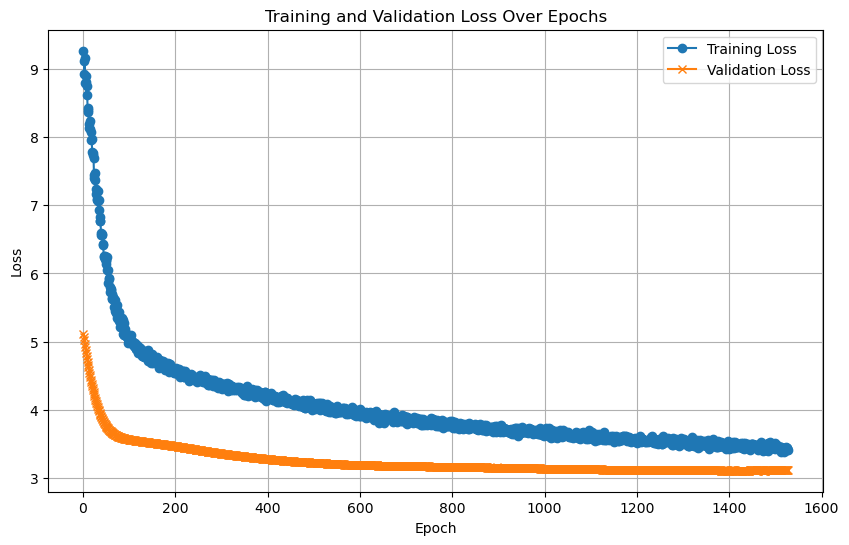

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.7093
Test Batch [20/40], Loss: 5.0247
Test Batch [30/40], Loss: 5.3065
Test Batch [40/40], Loss: 4.6974

Test Loss: 4.8598


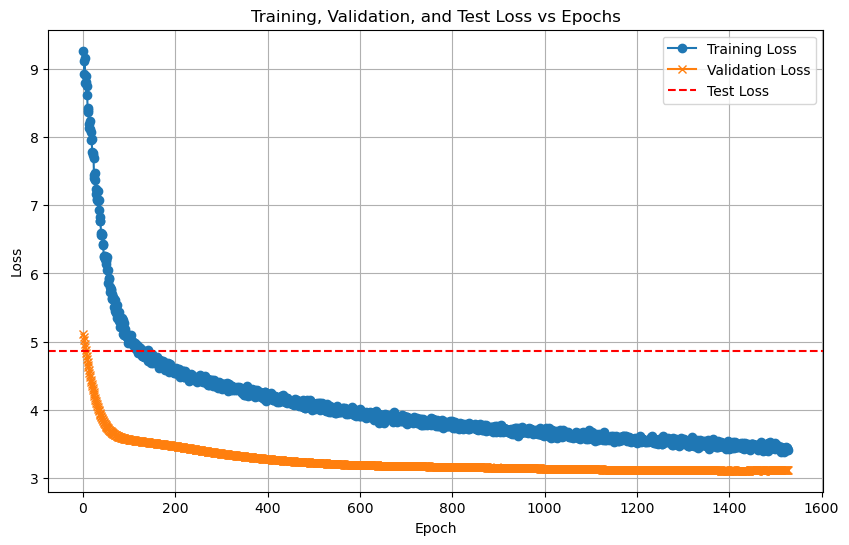

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 58.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.75      0.60      0.67         5
           4       0.38      0.60      0.46         5
           5       0.50      0.60      0.55         5
           6       0.60      0.60      0.60         5
           7       0.67      0.80      0.73         5
           8       0.83      1.00      0.91         5
           9       0.60      0.60      0.60         5
          10       0.45      1.00      0.62         5
          11       0.25      0.20      0.22         5
          12       1.00      1.00      1.00         5
          13       0.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9742  |  Val Loss: 2.9384
Validation loss improved from inf to 2.9384.
[Epoch 2/1000] Train Loss: 2.9429  |  Val Loss: 2.9127
Validation loss improved from 2.9384 to 2.9127.
[Epoch 3/1000] Train Loss: 2.9169  |  Val Loss: 2.8889
Validation loss improved from 2.9127 to 2.8889.
[Epoch 4/1000] Train Loss: 2.8920  |  Val Loss: 2.8661
Validation loss improved from 2.8889 to 2.8661.
[Epoch 5/1000] Train Loss: 2.8699  |  Val Loss: 2.8452
Validation loss improved from 2.8661 to 2.8452.
[Epoch 6/1000] Train Loss: 2.8475  |  Val Loss: 2.8258
Validation loss improved from 2.8452 to 2.8258.
[Epoch 7/1000] Train Loss: 2.8275  |  Val Loss: 2.8081
Validation loss improved from 2.8258 to 2.8081.
[Epoch 8/1000] Train Loss: 2.8096  |  Val Loss: 2.7912
Validation loss improved from 2.8081 to 2.7912.


[Epoch 9/1000] Train Loss: 2.7914  |  Val Loss: 2.7755
Validation loss improved from 2.7912 to 2.7755.
[Epoch 10/1000] Train Loss: 2.7757  |  Val Loss: 2.7606
Validation loss improved from 2.7755 to 2.7606.
[Epoch 11/1000] Train Loss: 2.7604  |  Val Loss: 2.7465
Validation loss improved from 2.7606 to 2.7465.
[Epoch 12/1000] Train Loss: 2.7448  |  Val Loss: 2.7330
Validation loss improved from 2.7465 to 2.7330.
[Epoch 13/1000] Train Loss: 2.7304  |  Val Loss: 2.7204
Validation loss improved from 2.7330 to 2.7204.
[Epoch 14/1000] Train Loss: 2.7163  |  Val Loss: 2.7089
Validation loss improved from 2.7204 to 2.7089.
[Epoch 15/1000] Train Loss: 2.7032  |  Val Loss: 2.6975
Validation loss improved from 2.7089 to 2.6975.
[Epoch 16/1000] Train Loss: 2.6899  |  Val Loss: 2.6862
Validation loss improved from 2.6975 to 2.6862.
[Epoch 17/1000] Train Loss: 2.6778  |  Val Loss: 2.6764
Validation loss improved from 2.6862 to 2.6764.
[Epoch 18/1000] Train Loss: 2.6655  |  Val Loss: 2.6665
Validatio

[Epoch 28/1000] Train Loss: 2.5511  |  Val Loss: 2.5718
Validation loss improved from 2.5807 to 2.5718.
[Epoch 29/1000] Train Loss: 2.5403  |  Val Loss: 2.5626
Validation loss improved from 2.5718 to 2.5626.
[Epoch 30/1000] Train Loss: 2.5287  |  Val Loss: 2.5534
Validation loss improved from 2.5626 to 2.5534.
[Epoch 31/1000] Train Loss: 2.5180  |  Val Loss: 2.5442
Validation loss improved from 2.5534 to 2.5442.
[Epoch 32/1000] Train Loss: 2.5072  |  Val Loss: 2.5350
Validation loss improved from 2.5442 to 2.5350.
[Epoch 33/1000] Train Loss: 2.4958  |  Val Loss: 2.5259
Validation loss improved from 2.5350 to 2.5259.
[Epoch 34/1000] Train Loss: 2.4841  |  Val Loss: 2.5170
Validation loss improved from 2.5259 to 2.5170.
[Epoch 35/1000] Train Loss: 2.4725  |  Val Loss: 2.5082
Validation loss improved from 2.5170 to 2.5082.
[Epoch 36/1000] Train Loss: 2.4620  |  Val Loss: 2.4997
Validation loss improved from 2.5082 to 2.4997.
[Epoch 37/1000] Train Loss: 2.4496  |  Val Loss: 2.4914
Validati

[Epoch 40/1000] Train Loss: 2.4149  |  Val Loss: 2.4660
Validation loss improved from 2.4742 to 2.4660.
[Epoch 41/1000] Train Loss: 2.4038  |  Val Loss: 2.4576
Validation loss improved from 2.4660 to 2.4576.
[Epoch 42/1000] Train Loss: 2.3934  |  Val Loss: 2.4492
Validation loss improved from 2.4576 to 2.4492.
[Epoch 43/1000] Train Loss: 2.3822  |  Val Loss: 2.4408
Validation loss improved from 2.4492 to 2.4408.
[Epoch 44/1000] Train Loss: 2.3711  |  Val Loss: 2.4326
Validation loss improved from 2.4408 to 2.4326.
[Epoch 45/1000] Train Loss: 2.3612  |  Val Loss: 2.4245
Validation loss improved from 2.4326 to 2.4245.
[Epoch 46/1000] Train Loss: 2.3504  |  Val Loss: 2.4168
Validation loss improved from 2.4245 to 2.4168.
[Epoch 47/1000] Train Loss: 2.3402  |  Val Loss: 2.4098
Validation loss improved from 2.4168 to 2.4098.
[Epoch 48/1000] Train Loss: 2.3305  |  Val Loss: 2.4029
Validation loss improved from 2.4098 to 2.4029.
[Epoch 49/1000] Train Loss: 2.3208  |  Val Loss: 2.3961
Validati

[Epoch 59/1000] Train Loss: 2.2273  |  Val Loss: 2.3279
Validation loss improved from 2.3350 to 2.3279.
[Epoch 60/1000] Train Loss: 2.2178  |  Val Loss: 2.3209
Validation loss improved from 2.3279 to 2.3209.
[Epoch 61/1000] Train Loss: 2.2085  |  Val Loss: 2.3140
Validation loss improved from 2.3209 to 2.3140.
[Epoch 62/1000] Train Loss: 2.1989  |  Val Loss: 2.3074
Validation loss improved from 2.3140 to 2.3074.
[Epoch 63/1000] Train Loss: 2.1895  |  Val Loss: 2.3009
Validation loss improved from 2.3074 to 2.3009.
[Epoch 64/1000] Train Loss: 2.1802  |  Val Loss: 2.2945
Validation loss improved from 2.3009 to 2.2945.
[Epoch 65/1000] Train Loss: 2.1706  |  Val Loss: 2.2877
Validation loss improved from 2.2945 to 2.2877.
[Epoch 66/1000] Train Loss: 2.1612  |  Val Loss: 2.2810
Validation loss improved from 2.2877 to 2.2810.
[Epoch 67/1000] Train Loss: 2.1520  |  Val Loss: 2.2748
Validation loss improved from 2.2810 to 2.2748.
[Epoch 68/1000] Train Loss: 2.1424  |  Val Loss: 2.2688
Validati

[Epoch 71/1000] Train Loss: 2.1139  |  Val Loss: 2.2509
Validation loss improved from 2.2568 to 2.2509.
[Epoch 72/1000] Train Loss: 2.1047  |  Val Loss: 2.2447
Validation loss improved from 2.2509 to 2.2447.
[Epoch 73/1000] Train Loss: 2.0955  |  Val Loss: 2.2384
Validation loss improved from 2.2447 to 2.2384.
[Epoch 74/1000] Train Loss: 2.0862  |  Val Loss: 2.2318
Validation loss improved from 2.2384 to 2.2318.
[Epoch 75/1000] Train Loss: 2.0767  |  Val Loss: 2.2255
Validation loss improved from 2.2318 to 2.2255.
[Epoch 76/1000] Train Loss: 2.0677  |  Val Loss: 2.2192
Validation loss improved from 2.2255 to 2.2192.
[Epoch 77/1000] Train Loss: 2.0582  |  Val Loss: 2.2130
Validation loss improved from 2.2192 to 2.2130.
[Epoch 78/1000] Train Loss: 2.0487  |  Val Loss: 2.2069
Validation loss improved from 2.2130 to 2.2069.
[Epoch 79/1000] Train Loss: 2.0391  |  Val Loss: 2.2014
Validation loss improved from 2.2069 to 2.2014.
[Epoch 80/1000] Train Loss: 2.0299  |  Val Loss: 2.1955
Validati

[Epoch 90/1000] Train Loss: 1.9403  |  Val Loss: 2.1367
Validation loss improved from 2.1425 to 2.1367.
[Epoch 91/1000] Train Loss: 1.9316  |  Val Loss: 2.1314
Validation loss improved from 2.1367 to 2.1314.
[Epoch 92/1000] Train Loss: 1.9229  |  Val Loss: 2.1263
Validation loss improved from 2.1314 to 2.1263.
[Epoch 93/1000] Train Loss: 1.9142  |  Val Loss: 2.1213
Validation loss improved from 2.1263 to 2.1213.
[Epoch 94/1000] Train Loss: 1.9058  |  Val Loss: 2.1163
Validation loss improved from 2.1213 to 2.1163.
[Epoch 95/1000] Train Loss: 1.8973  |  Val Loss: 2.1107
Validation loss improved from 2.1163 to 2.1107.
[Epoch 96/1000] Train Loss: 1.8890  |  Val Loss: 2.1053
Validation loss improved from 2.1107 to 2.1053.
[Epoch 97/1000] Train Loss: 1.8805  |  Val Loss: 2.1003
Validation loss improved from 2.1053 to 2.1003.
[Epoch 98/1000] Train Loss: 1.8722  |  Val Loss: 2.0953
Validation loss improved from 2.1003 to 2.0953.
[Epoch 99/1000] Train Loss: 1.8641  |  Val Loss: 2.0899
Validati

[Epoch 103/1000] Train Loss: 1.8322  |  Val Loss: 2.0702
Validation loss improved from 2.0754 to 2.0702.
[Epoch 104/1000] Train Loss: 1.8241  |  Val Loss: 2.0651
Validation loss improved from 2.0702 to 2.0651.
[Epoch 105/1000] Train Loss: 1.8161  |  Val Loss: 2.0600
Validation loss improved from 2.0651 to 2.0600.
[Epoch 106/1000] Train Loss: 1.8083  |  Val Loss: 2.0551
Validation loss improved from 2.0600 to 2.0551.
[Epoch 107/1000] Train Loss: 1.8003  |  Val Loss: 2.0506
Validation loss improved from 2.0551 to 2.0506.
[Epoch 108/1000] Train Loss: 1.7924  |  Val Loss: 2.0469
Validation loss improved from 2.0506 to 2.0469.
[Epoch 109/1000] Train Loss: 1.7848  |  Val Loss: 2.0428
Validation loss improved from 2.0469 to 2.0428.
[Epoch 110/1000] Train Loss: 1.7769  |  Val Loss: 2.0390
Validation loss improved from 2.0428 to 2.0390.
[Epoch 111/1000] Train Loss: 1.7692  |  Val Loss: 2.0347
Validation loss improved from 2.0390 to 2.0347.
[Epoch 112/1000] Train Loss: 1.7617  |  Val Loss: 2.030

[Epoch 117/1000] Train Loss: 1.7239  |  Val Loss: 2.0059
Validation loss improved from 2.0112 to 2.0059.
[Epoch 118/1000] Train Loss: 1.7167  |  Val Loss: 2.0012
Validation loss improved from 2.0059 to 2.0012.
[Epoch 119/1000] Train Loss: 1.7091  |  Val Loss: 1.9968
Validation loss improved from 2.0012 to 1.9968.
[Epoch 120/1000] Train Loss: 1.7016  |  Val Loss: 1.9926
Validation loss improved from 1.9968 to 1.9926.
[Epoch 121/1000] Train Loss: 1.6944  |  Val Loss: 1.9887
Validation loss improved from 1.9926 to 1.9887.
[Epoch 122/1000] Train Loss: 1.6866  |  Val Loss: 1.9854
Validation loss improved from 1.9887 to 1.9854.
[Epoch 123/1000] Train Loss: 1.6786  |  Val Loss: 1.9815
Validation loss improved from 1.9854 to 1.9815.
[Epoch 124/1000] Train Loss: 1.6711  |  Val Loss: 1.9779
Validation loss improved from 1.9815 to 1.9779.
[Epoch 125/1000] Train Loss: 1.6640  |  Val Loss: 1.9750
Validation loss improved from 1.9779 to 1.9750.
[Epoch 126/1000] Train Loss: 1.6564  |  Val Loss: 1.971

[Epoch 131/1000] Train Loss: 1.6206  |  Val Loss: 1.9524
Validation loss improved from 1.9567 to 1.9524.
[Epoch 132/1000] Train Loss: 1.6135  |  Val Loss: 1.9476
Validation loss improved from 1.9524 to 1.9476.
[Epoch 133/1000] Train Loss: 1.6059  |  Val Loss: 1.9437
Validation loss improved from 1.9476 to 1.9437.
[Epoch 134/1000] Train Loss: 1.5991  |  Val Loss: 1.9399
Validation loss improved from 1.9437 to 1.9399.
[Epoch 135/1000] Train Loss: 1.5921  |  Val Loss: 1.9367
Validation loss improved from 1.9399 to 1.9367.
[Epoch 136/1000] Train Loss: 1.5852  |  Val Loss: 1.9330
Validation loss improved from 1.9367 to 1.9330.
[Epoch 137/1000] Train Loss: 1.5784  |  Val Loss: 1.9285
Validation loss improved from 1.9330 to 1.9285.
[Epoch 138/1000] Train Loss: 1.5717  |  Val Loss: 1.9243
Validation loss improved from 1.9285 to 1.9243.
[Epoch 139/1000] Train Loss: 1.5648  |  Val Loss: 1.9207
Validation loss improved from 1.9243 to 1.9207.
[Epoch 140/1000] Train Loss: 1.5584  |  Val Loss: 1.916

[Epoch 143/1000] Train Loss: 1.5378  |  Val Loss: 1.9086
Validation loss improved from 1.9107 to 1.9086.
[Epoch 144/1000] Train Loss: 1.5315  |  Val Loss: 1.9064
Validation loss improved from 1.9086 to 1.9064.
[Epoch 145/1000] Train Loss: 1.5247  |  Val Loss: 1.9037
Validation loss improved from 1.9064 to 1.9037.
[Epoch 146/1000] Train Loss: 1.5180  |  Val Loss: 1.9005
Validation loss improved from 1.9037 to 1.9005.
[Epoch 147/1000] Train Loss: 1.5116  |  Val Loss: 1.8973
Validation loss improved from 1.9005 to 1.8973.
[Epoch 148/1000] Train Loss: 1.5050  |  Val Loss: 1.8936
Validation loss improved from 1.8973 to 1.8936.
[Epoch 149/1000] Train Loss: 1.4988  |  Val Loss: 1.8908
Validation loss improved from 1.8936 to 1.8908.
[Epoch 150/1000] Train Loss: 1.4923  |  Val Loss: 1.8882
Validation loss improved from 1.8908 to 1.8882.
[Epoch 151/1000] Train Loss: 1.4856  |  Val Loss: 1.8856
Validation loss improved from 1.8882 to 1.8856.
[Epoch 152/1000] Train Loss: 1.4794  |  Val Loss: 1.882

[Epoch 161/1000] Train Loss: 1.4225  |  Val Loss: 1.8532
Validation loss improved from 1.8564 to 1.8532.
[Epoch 162/1000] Train Loss: 1.4164  |  Val Loss: 1.8503
Validation loss improved from 1.8532 to 1.8503.
[Epoch 163/1000] Train Loss: 1.4107  |  Val Loss: 1.8480
Validation loss improved from 1.8503 to 1.8480.
[Epoch 164/1000] Train Loss: 1.4046  |  Val Loss: 1.8455
Validation loss improved from 1.8480 to 1.8455.
[Epoch 165/1000] Train Loss: 1.3986  |  Val Loss: 1.8427
Validation loss improved from 1.8455 to 1.8427.
[Epoch 166/1000] Train Loss: 1.3924  |  Val Loss: 1.8401
Validation loss improved from 1.8427 to 1.8401.
[Epoch 167/1000] Train Loss: 1.3864  |  Val Loss: 1.8376
Validation loss improved from 1.8401 to 1.8376.
[Epoch 168/1000] Train Loss: 1.3800  |  Val Loss: 1.8356
Validation loss improved from 1.8376 to 1.8356.
[Epoch 169/1000] Train Loss: 1.3746  |  Val Loss: 1.8342
Validation loss improved from 1.8356 to 1.8342.
[Epoch 170/1000] Train Loss: 1.3691  |  Val Loss: 1.831

[Epoch 174/1000] Train Loss: 1.3458  |  Val Loss: 1.8209
Validation loss improved from 1.8233 to 1.8209.
[Epoch 175/1000] Train Loss: 1.3399  |  Val Loss: 1.8184
Validation loss improved from 1.8209 to 1.8184.
[Epoch 176/1000] Train Loss: 1.3343  |  Val Loss: 1.8159
Validation loss improved from 1.8184 to 1.8159.
[Epoch 177/1000] Train Loss: 1.3283  |  Val Loss: 1.8143
Validation loss improved from 1.8159 to 1.8143.
[Epoch 178/1000] Train Loss: 1.3228  |  Val Loss: 1.8122
Validation loss improved from 1.8143 to 1.8122.
[Epoch 179/1000] Train Loss: 1.3168  |  Val Loss: 1.8101
Validation loss improved from 1.8122 to 1.8101.
[Epoch 180/1000] Train Loss: 1.3116  |  Val Loss: 1.8083
Validation loss improved from 1.8101 to 1.8083.
[Epoch 181/1000] Train Loss: 1.3064  |  Val Loss: 1.8058
Validation loss improved from 1.8083 to 1.8058.
[Epoch 182/1000] Train Loss: 1.3009  |  Val Loss: 1.8035
Validation loss improved from 1.8058 to 1.8035.
[Epoch 183/1000] Train Loss: 1.2960  |  Val Loss: 1.800

[Epoch 192/1000] Train Loss: 1.2468  |  Val Loss: 1.7865
Validation loss improved from 1.7884 to 1.7865.
[Epoch 193/1000] Train Loss: 1.2416  |  Val Loss: 1.7849
Validation loss improved from 1.7865 to 1.7849.
[Epoch 194/1000] Train Loss: 1.2370  |  Val Loss: 1.7838
Validation loss improved from 1.7849 to 1.7838.
[Epoch 195/1000] Train Loss: 1.2311  |  Val Loss: 1.7812
Validation loss improved from 1.7838 to 1.7812.
[Epoch 196/1000] Train Loss: 1.2263  |  Val Loss: 1.7777
Validation loss improved from 1.7812 to 1.7777.
[Epoch 197/1000] Train Loss: 1.2206  |  Val Loss: 1.7751
Validation loss improved from 1.7777 to 1.7751.
[Epoch 198/1000] Train Loss: 1.2156  |  Val Loss: 1.7735
Validation loss improved from 1.7751 to 1.7735.
[Epoch 199/1000] Train Loss: 1.2103  |  Val Loss: 1.7718
Validation loss improved from 1.7735 to 1.7718.
[Epoch 200/1000] Train Loss: 1.2052  |  Val Loss: 1.7702
Validation loss improved from 1.7718 to 1.7702.
[Epoch 201/1000] Train Loss: 1.2002  |  Val Loss: 1.768

[Epoch 203/1000] Train Loss: 1.1896  |  Val Loss: 1.7655
Validation loss improved from 1.7668 to 1.7655.
[Epoch 204/1000] Train Loss: 1.1847  |  Val Loss: 1.7638
Validation loss improved from 1.7655 to 1.7638.
[Epoch 205/1000] Train Loss: 1.1794  |  Val Loss: 1.7617
Validation loss improved from 1.7638 to 1.7617.
[Epoch 206/1000] Train Loss: 1.1747  |  Val Loss: 1.7602
Validation loss improved from 1.7617 to 1.7602.
[Epoch 207/1000] Train Loss: 1.1697  |  Val Loss: 1.7595
Validation loss improved from 1.7602 to 1.7595.
[Epoch 208/1000] Train Loss: 1.1644  |  Val Loss: 1.7578
Validation loss improved from 1.7595 to 1.7578.
[Epoch 209/1000] Train Loss: 1.1595  |  Val Loss: 1.7556
Validation loss improved from 1.7578 to 1.7556.
[Epoch 210/1000] Train Loss: 1.1542  |  Val Loss: 1.7525
Validation loss improved from 1.7556 to 1.7525.
[Epoch 211/1000] Train Loss: 1.1492  |  Val Loss: 1.7502
Validation loss improved from 1.7525 to 1.7502.
[Epoch 212/1000] Train Loss: 1.1442  |  Val Loss: 1.749

[Epoch 220/1000] Train Loss: 1.1053  |  Val Loss: 1.7382
Validation loss improved from 1.7402 to 1.7382.
[Epoch 221/1000] Train Loss: 1.1000  |  Val Loss: 1.7369
Validation loss improved from 1.7382 to 1.7369.
[Epoch 222/1000] Train Loss: 1.0953  |  Val Loss: 1.7363
Validation loss improved from 1.7369 to 1.7363.
[Epoch 223/1000] Train Loss: 1.0907  |  Val Loss: 1.7361
Validation loss improved from 1.7363 to 1.7361.
[Epoch 224/1000] Train Loss: 1.0863  |  Val Loss: 1.7352
Validation loss improved from 1.7361 to 1.7352.
[Epoch 225/1000] Train Loss: 1.0820  |  Val Loss: 1.7338
Validation loss improved from 1.7352 to 1.7338.
[Epoch 226/1000] Train Loss: 1.0774  |  Val Loss: 1.7307
Validation loss improved from 1.7338 to 1.7307.
[Epoch 227/1000] Train Loss: 1.0721  |  Val Loss: 1.7290
Validation loss improved from 1.7307 to 1.7290.
[Epoch 228/1000] Train Loss: 1.0675  |  Val Loss: 1.7285
Validation loss improved from 1.7290 to 1.7285.


[Epoch 229/1000] Train Loss: 1.0632  |  Val Loss: 1.7287
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 1.0584  |  Val Loss: 1.7280
Validation loss improved from 1.7285 to 1.7280.
[Epoch 231/1000] Train Loss: 1.0536  |  Val Loss: 1.7272
Validation loss improved from 1.7280 to 1.7272.
[Epoch 232/1000] Train Loss: 1.0491  |  Val Loss: 1.7261
Validation loss improved from 1.7272 to 1.7261.
[Epoch 233/1000] Train Loss: 1.0460  |  Val Loss: 1.7253
Validation loss improved from 1.7261 to 1.7253.
[Epoch 234/1000] Train Loss: 1.0401  |  Val Loss: 1.7257
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 1.0355  |  Val Loss: 1.7259
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 1.0315  |  Val Loss: 1.7261
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 237/1000] Train Loss: 1.0275  |  Val Loss: 1.7252
Validation loss improved from 1.7253 to 1.7252.
[Epoch 238/1000] Train Loss: 1.

[Epoch 246/1000] Train Loss: 0.9885  |  Val Loss: 1.7155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 0.9845  |  Val Loss: 1.7159
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 248/1000] Train Loss: 0.9804  |  Val Loss: 1.7163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 249/1000] Train Loss: 0.9764  |  Val Loss: 1.7164
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 250/1000] Train Loss: 0.9726  |  Val Loss: 1.7152
Validation loss improved from 1.7155 to 1.7152.
[Epoch 251/1000] Train Loss: 0.9684  |  Val Loss: 1.7135
Validation loss improved from 1.7152 to 1.7135.
[Epoch 252/1000] Train Loss: 0.9639  |  Val Loss: 1.7125
Validation loss improved from 1.7135 to 1.7125.
[Epoch 253/1000] Train Loss: 0.9602  |  Val Loss: 1.7120
Validation loss improved from 1.7125 to 1.7120.
[Epoch 254/1000] Train Loss: 0.9558  |  Val Loss: 1.7106
Validation loss improved from 1.7120 to 1.7106.
[Epoch 255/1000] Train Loss: 0.

[Epoch 258/1000] Train Loss: 0.9400  |  Val Loss: 1.7111
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 259/1000] Train Loss: 0.9364  |  Val Loss: 1.7115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 260/1000] Train Loss: 0.9327  |  Val Loss: 1.7115
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 261/1000] Train Loss: 0.9286  |  Val Loss: 1.7111
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 262/1000] Train Loss: 0.9247  |  Val Loss: 1.7112
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 263/1000] Train Loss: 0.9210  |  Val Loss: 1.7103
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 264/1000] Train Loss: 0.9173  |  Val Loss: 1.7095
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 265/1000] Train Loss: 0.9132  |  Val Loss: 1.7081
Validation loss improved from 1.7089 to 1.7081.
[Epoch 266/1000] Train Loss: 0.9099  |  Val Loss: 1.7070
Validation loss improved from 1.7081 to 1.7070.
[Epoch 267/10

[Epoch 274/1000] Train Loss: 0.8814  |  Val Loss: 1.7105
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 275/1000] Train Loss: 0.8778  |  Val Loss: 1.7103
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 276/1000] Train Loss: 0.8741  |  Val Loss: 1.7090
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 277/1000] Train Loss: 0.8707  |  Val Loss: 1.7088
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 278/1000] Train Loss: 0.8680  |  Val Loss: 1.7089
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 279/1000] Train Loss: 0.8645  |  Val Loss: 1.7094
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 280/1000] Train Loss: 0.8611  |  Val Loss: 1.7097
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 281/1000] Train Loss: 0.8575  |  Val Loss: 1.7110
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 282/1000] Train Loss: 0.8539  |  Val Loss: 1.7122
!! Validation loss did NOT improve !! Patience: 1

[Epoch 288/1000] Train Loss: 0.8352  |  Val Loss: 1.7169
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 289/1000] Train Loss: 0.8318  |  Val Loss: 1.7172
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 290/1000] Train Loss: 0.8290  |  Val Loss: 1.7176
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 291/1000] Train Loss: 0.8264  |  Val Loss: 1.7186
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 292/1000] Train Loss: 0.8232  |  Val Loss: 1.7180
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 293/1000] Train Loss: 0.8201  |  Val Loss: 1.7165
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 294/1000] Train Loss: 0.8170  |  Val Loss: 1.7160
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 295/1000] Train Loss: 0.8139  |  Val Loss: 1.7168
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 296/1000] Train Loss: 0.8106  |  Val Loss: 1.7178
!! Validation loss did NOT improve !! Patience:

[Epoch 303/1000] Train Loss: 0.7912  |  Val Loss: 1.7268
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 304/1000] Train Loss: 0.7888  |  Val Loss: 1.7293
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 305/1000] Train Loss: 0.7851  |  Val Loss: 1.7304
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 306/1000] Train Loss: 0.7828  |  Val Loss: 1.7315
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 307/1000] Train Loss: 0.7798  |  Val Loss: 1.7330
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 308/1000] Train Loss: 0.7770  |  Val Loss: 1.7339
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 309/1000] Train Loss: 0.7741  |  Val Loss: 1.7330
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 310/1000] Train Loss: 0.7718  |  Val Loss: 1.7334
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 311/1000] Train Loss: 0.7688  |  Val Loss: 1.7348
!! Validation loss did NOT improve !! Patience:

[Epoch 320/1000] Train Loss: 0.7452  |  Val Loss: 1.7485
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 321/1000] Train Loss: 0.7431  |  Val Loss: 1.7494
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 322/1000] Train Loss: 0.7401  |  Val Loss: 1.7499
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 323/1000] Train Loss: 0.7377  |  Val Loss: 1.7506
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 324/1000] Train Loss: 0.7350  |  Val Loss: 1.7514
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 325/1000] Train Loss: 0.7330  |  Val Loss: 1.7522
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 326/1000] Train Loss: 0.7301  |  Val Loss: 1.7536
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 327/1000] Train Loss: 0.7276  |  Val Loss: 1.7546
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 328/1000] Train Loss: 0.7246  |  Val Loss: 1.7565
!! Validation loss did NOT improve !! Patience:

[Epoch 332/1000] Train Loss: 0.7159  |  Val Loss: 1.7640
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 333/1000] Train Loss: 0.7145  |  Val Loss: 1.7656
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 334/1000] Train Loss: 0.7109  |  Val Loss: 1.7672
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 335/1000] Train Loss: 0.7085  |  Val Loss: 1.7686
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 336/1000] Train Loss: 0.7061  |  Val Loss: 1.7700
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 337/1000] Train Loss: 0.7041  |  Val Loss: 1.7710
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 338/1000] Train Loss: 0.7012  |  Val Loss: 1.7729
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 339/1000] Train Loss: 0.7002  |  Val Loss: 1.7752
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 340/1000] Train Loss: 0.6970  |  Val Loss: 1.7774
!! Validation loss did NOT improve !! Patience:

[Epoch 348/1000] Train Loss: 0.6782  |  Val Loss: 1.7951
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 349/1000] Train Loss: 0.6763  |  Val Loss: 1.7969
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 350/1000] Train Loss: 0.6742  |  Val Loss: 1.7994
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 351/1000] Train Loss: 0.6716  |  Val Loss: 1.8013
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 352/1000] Train Loss: 0.6698  |  Val Loss: 1.8025
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 353/1000] Train Loss: 0.6665  |  Val Loss: 1.8042
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 354/1000] Train Loss: 0.6645  |  Val Loss: 1.8044
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 355/1000] Train Loss: 0.6625  |  Val Loss: 1.8043
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 356/1000] Train Loss: 0.6603  |  Val Loss: 1.8040
!! Validation loss did NOT improve !! Patience:

[Epoch 362/1000] Train Loss: 0.6476  |  Val Loss: 1.8091
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 363/1000] Train Loss: 0.6459  |  Val Loss: 1.8113
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 364/1000] Train Loss: 0.6452  |  Val Loss: 1.8150
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 365/1000] Train Loss: 0.6421  |  Val Loss: 1.8187
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 366/1000] Train Loss: 0.6409  |  Val Loss: 1.8225
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 366 !!
No improvement for 100 epochs.


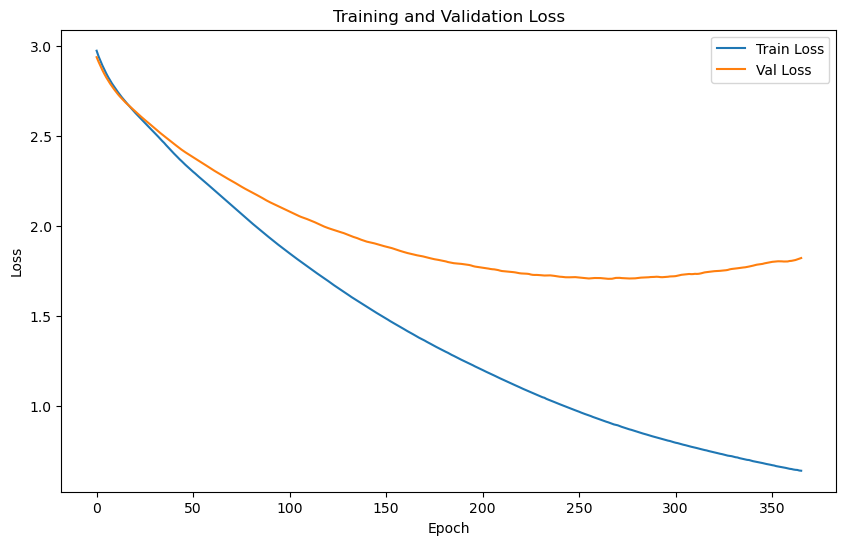

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.4650 | Test Accuracy: 41.39%


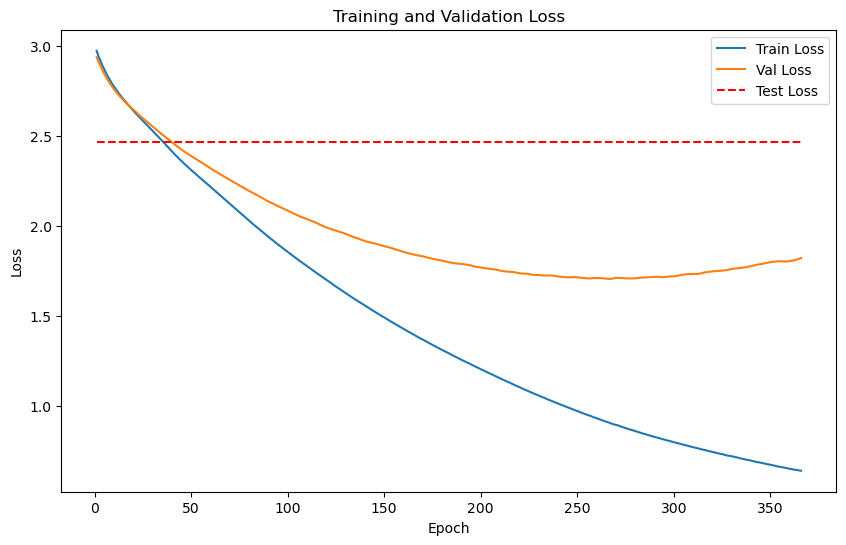

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.2991
Epoch [1/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.4078

Validation loss improved from inf to 0.4078. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.2993
Epoch [2/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.4072

Validation loss improved from 0.4078 to 0.4072. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.2995
Epoch [3/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.4065

Validation loss improved from 0.4072 to 0.4065. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.2999
Epoch [4/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.4059

Validation loss improved from 0.4065 to 0.4059. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.3003
Epoch [5/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.4052

Validation loss improved from 0.4059 to 0.4052. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.3005
Epoch [6/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4042

Validation loss improved from 0.4052 to 0.4042. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3009
Epoch [7/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.4033

Validation loss improved from 0.4042 to 0.4033. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.3010
Epoch [8/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.4023

Validation loss improved from 0.4033 to 0.4023. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5019
    Batch [2/2], Val Loss: 0.3010
Epoch [9/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.4014

Validation loss improved from 0.4023 to 0.4014. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3009
Epoch [10/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.4008

Validation loss improved from 0.4014 to 0.4008. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.3010
Epoch [11/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.4004

Validation loss improved from 0.4008 to 0.4004. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.3017
Epoch [12/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.3027
Epoch [13/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.3038
Epoch [14/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.3045
Epoch [15/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.3052
Epoch [16/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.3998

Validation loss improved from 0.4001 to 0.3998. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.3059
Epoch [17/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.3995

Validation loss improved from 0.3998 to 0.3995. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.3066
Epoch [18/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.3993

Validation loss improved from 0.3995 to 0.3993. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.3073
Epoch [19/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.3991

Validation loss improved from 0.3993 to 0.3991. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.3079
Epoch [20/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.3990

Validation loss improved from 0.3991 to 0.3990. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.3085
Epoch [21/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.3989

Validation loss improved from 0.3990 to 0.3989. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.3090
Epoch [22/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.3988

Validation loss improved from 0.3989 to 0.3988. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.3094
Epoch [23/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.3988

Validation loss improved from 0.3988 to 0.3988. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.3099
Epoch [24/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.3988

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.3103
Epoch [25/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.3989

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3107
Epoch [26/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3989

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3109
Epoch [27/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.3988

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.3111
Epoch [28/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.3987

Validation loss improved from 0.3988 to 0.3987. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.3112
Epoch [29/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.3985

Validation loss improved from 0.3987 to 0.3985. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.3114
Epoch [30/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.3984

Validation loss improved from 0.3985 to 0.3984. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.3115
Epoch [31/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.3983

Validation loss improved from 0.3984 to 0.3983. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.3116
Epoch [32/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.3981

Validation loss improved from 0.3983 to 0.3981. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3116
Epoch [33/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.3979

Validation loss improved from 0.3981 to 0.3979. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3117
Epoch [34/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.3977

Validation loss improved from 0.3979 to 0.3977. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.3117
Epoch [35/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.3975

Validation loss improved from 0.3977 to 0.3975. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3117
Epoch [36/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3973

Validation loss improved from 0.3975 to 0.3973. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.3117
Epoch [37/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.3972

Validation loss improved from 0.3973 to 0.3972. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3117
Epoch [38/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3970

Validation loss improved from 0.3972 to 0.3970. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.3117
Epoch [39/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.3968

Validation loss improved from 0.3970 to 0.3968. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.3117
Epoch [40/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.3967

Validation loss improved from 0.3968 to 0.3967. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3116
Epoch [41/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.3965

Validation loss improved from 0.3967 to 0.3965. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.3116
Epoch [42/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.3964

Validation loss improved from 0.3965 to 0.3964. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.3116
Epoch [43/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.3962

Validation loss improved from 0.3964 to 0.3962. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.3115
Epoch [44/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.3960

Validation loss improved from 0.3962 to 0.3960. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.3114
Epoch [45/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.3958

Validation loss improved from 0.3960 to 0.3958. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.3113
Epoch [46/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.3956

Validation loss improved from 0.3958 to 0.3956. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3113
Epoch [47/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.3955

Validation loss improved from 0.3956 to 0.3955. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3112
Epoch [48/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.3953

Validation loss improved from 0.3955 to 0.3953. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3111
Epoch [49/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.3111
Epoch [50/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3111
Epoch [51/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.3111
Epoch [52/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3949

Validation loss improved from 0.3950 to 0.3949. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3110
Epoch [53/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.3947

Validation loss improved from 0.3949 to 0.3947. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3110
Epoch [54/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3109
Epoch [55/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.3108
Epoch [56/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.3943

Validation loss improved from 0.3945 to 0.3943. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.3107
Epoch [57/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.3941

Validation loss improved from 0.3943 to 0.3941. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3105
Epoch [58/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.3940

Validation loss improved from 0.3941 to 0.3940. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3103
Epoch [59/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.3938

Validation loss improved from 0.3940 to 0.3938. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3101
Epoch [60/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.3936

Validation loss improved from 0.3938 to 0.3936. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3099
Epoch [61/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.3934

Validation loss improved from 0.3936 to 0.3934. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3097
Epoch [62/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.3931

Validation loss improved from 0.3934 to 0.3931. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3094
Epoch [63/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.3928

Validation loss improved from 0.3931 to 0.3928. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.3091
Epoch [64/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.3925

Validation loss improved from 0.3928 to 0.3925. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.3089
Epoch [65/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3086
Epoch [66/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.3920

Validation loss improved from 0.3923 to 0.3920. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.3084
Epoch [67/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.3918

Validation loss improved from 0.3920 to 0.3918. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.3082
Epoch [68/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.3916

Validation loss improved from 0.3918 to 0.3916. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.3079
Epoch [69/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.3913

Validation loss improved from 0.3916 to 0.3913. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.3077
Epoch [70/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.3910

Validation loss improved from 0.3913 to 0.3910. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3074
Epoch [71/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3908

Validation loss improved from 0.3910 to 0.3908. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.3072
Epoch [72/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.3071
Epoch [73/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.3904

Validation loss improved from 0.3906 to 0.3904. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3069
Epoch [74/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.3901

Validation loss improved from 0.3904 to 0.3901. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3067
Epoch [75/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.3899

Validation loss improved from 0.3901 to 0.3899. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3064
Epoch [76/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.3897

Validation loss improved from 0.3899 to 0.3897. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3062
Epoch [77/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3895

Validation loss improved from 0.3897 to 0.3895. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.3061
Epoch [78/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.3893

Validation loss improved from 0.3895 to 0.3893. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3059
Epoch [79/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.3891

Validation loss improved from 0.3893 to 0.3891. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.3059
Epoch [80/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.3058
Epoch [81/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3058
Epoch [82/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.3888

Validation loss improved from 0.3888 to 0.3888. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3058
Epoch [83/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3059
Epoch [84/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.3886

Validation loss improved from 0.3887 to 0.3886. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.3059
Epoch [85/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.3060
Epoch [86/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3061
Epoch [87/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.3884

Validation loss improved from 0.3884 to 0.3884. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3061
Epoch [88/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.3884

Validation loss improved from 0.3884 to 0.3884. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.3062
Epoch [89/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3061
Epoch [90/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.3060
Epoch [91/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.3880

Validation loss improved from 0.3882 to 0.3880. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3058
Epoch [92/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.3878

Validation loss improved from 0.3880 to 0.3878. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3056
Epoch [93/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.3055
Epoch [94/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.3875

Validation loss improved from 0.3877 to 0.3875. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.3054
Epoch [95/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.3873

Validation loss improved from 0.3875 to 0.3873. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.3052
Epoch [96/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.3871

Validation loss improved from 0.3873 to 0.3871. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3051
Epoch [97/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3869

Validation loss improved from 0.3871 to 0.3869. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3050
Epoch [98/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3049
Epoch [99/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.3866

Validation loss improved from 0.3868 to 0.3866. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.3048
Epoch [100/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3864

Validation loss improved from 0.3866 to 0.3864. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.3048
Epoch [101/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.3048
Epoch [102/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.3048
Epoch [103/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.3047
Epoch [104/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3860

Validation loss improved from 0.3861 to 0.3860. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3046
Epoch [105/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3858

Validation loss improved from 0.3860 to 0.3858. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3045
Epoch [106/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3044
Epoch [107/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3855

Validation loss improved from 0.3857 to 0.3855. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3044
Epoch [108/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.3853

Validation loss improved from 0.3855 to 0.3853. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3043
Epoch [109/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3851

Validation loss improved from 0.3853 to 0.3851. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.3042
Epoch [110/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3849

Validation loss improved from 0.3851 to 0.3849. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.3041
Epoch [111/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.3041
Epoch [112/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3042
Epoch [113/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.3043
Epoch [114/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.3044
Epoch [115/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.3845

Validation loss improved from 0.3845 to 0.3845. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.3045
Epoch [116/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.3045
Epoch [117/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3844

Validation loss improved from 0.3844 to 0.3844. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.3046
Epoch [118/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3047
Epoch [119/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3843

Validation loss improved from 0.3843 to 0.3843. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3048
Epoch [120/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3843

Validation loss improved from 0.3843 to 0.3843. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3049
Epoch [121/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3049
Epoch [122/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.3048
Epoch [123/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.3048
Epoch [124/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.3047
Epoch [125/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3837

Validation loss improved from 0.3839 to 0.3837. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.3046
Epoch [126/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.3046
Epoch [127/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.3046
Epoch [128/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.3833

Validation loss improved from 0.3835 to 0.3833. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3046
Epoch [129/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3832

Validation loss improved from 0.3833 to 0.3832. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3046
Epoch [130/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3046
Epoch [131/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.3829

Validation loss improved from 0.3831 to 0.3829. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3046
Epoch [132/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3828

Validation loss improved from 0.3829 to 0.3828. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3046
Epoch [133/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3045
Epoch [134/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.3045
Epoch [135/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.3825

Validation loss improved from 0.3826 to 0.3825. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.3046
Epoch [136/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3825

Validation loss improved from 0.3825 to 0.3825. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.3046
Epoch [137/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3824

Validation loss improved from 0.3825 to 0.3824. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.3046
Epoch [138/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.3046
Epoch [139/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3823

Validation loss improved from 0.3823 to 0.3823. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.3046
Epoch [140/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.3046
Epoch [141/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.3045
Epoch [142/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3819

Validation loss improved from 0.3820 to 0.3819. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.3046
Epoch [143/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.3819

Validation loss improved from 0.3819 to 0.3819. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.3046
Epoch [144/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3818

Validation loss improved from 0.3819 to 0.3818. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3046
Epoch [145/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.3818

Validation loss improved from 0.3818 to 0.3818. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3047
Epoch [146/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3817

Validation loss improved from 0.3818 to 0.3817. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.3046
Epoch [147/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3816

Validation loss improved from 0.3817 to 0.3816. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3045
Epoch [148/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3814

Validation loss improved from 0.3816 to 0.3814. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3044
Epoch [149/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.3812

Validation loss improved from 0.3814 to 0.3812. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3043
Epoch [150/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3043
Epoch [151/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3810

Validation loss improved from 0.3811 to 0.3810. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3042
Epoch [152/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3809

Validation loss improved from 0.3810 to 0.3809. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.3042
Epoch [153/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3807

Validation loss improved from 0.3809 to 0.3807. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.3042
Epoch [154/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3806

Validation loss improved from 0.3807 to 0.3806. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.3042
Epoch [155/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3042
Epoch [156/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3042
Epoch [157/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3803

Validation loss improved from 0.3804 to 0.3803. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3041
Epoch [158/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3802

Validation loss improved from 0.3803 to 0.3802. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.3041
Epoch [159/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3801

Validation loss improved from 0.3802 to 0.3801. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.3042
Epoch [160/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3800

Validation loss improved from 0.3801 to 0.3800. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.3042
Epoch [161/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.3043
Epoch [162/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3798

Validation loss improved from 0.3799 to 0.3798. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3043
Epoch [163/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3797

Validation loss improved from 0.3798 to 0.3797. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.3044
Epoch [164/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.3044
Epoch [165/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.3043
Epoch [166/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3795

Validation loss improved from 0.3796 to 0.3795. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.3043
Epoch [167/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3794

Validation loss improved from 0.3795 to 0.3794. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.3042
Epoch [168/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3793

Validation loss improved from 0.3794 to 0.3793. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.3042
Epoch [169/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3792

Validation loss improved from 0.3793 to 0.3792. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.3042
Epoch [170/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3791

Validation loss improved from 0.3792 to 0.3791. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3041
Epoch [171/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3790

Validation loss improved from 0.3791 to 0.3790. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.3041
Epoch [172/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.3041
Epoch [173/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3788

Validation loss improved from 0.3789 to 0.3788. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.3041
Epoch [174/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3787

Validation loss improved from 0.3788 to 0.3787. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3041
Epoch [175/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.3041
Epoch [176/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3786

Validation loss improved from 0.3786 to 0.3786. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.3042
Epoch [177/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.3042
Epoch [178/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.3042
Epoch [179/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.3043
Epoch [180/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3783

Validation loss improved from 0.3783 to 0.3783. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.3044
Epoch [181/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.3045
Epoch [182/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3782

Validation loss improved from 0.3782 to 0.3782. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.3045
Epoch [183/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.3044
Epoch [184/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.3044
Epoch [185/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.3044
Epoch [186/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3778

Validation loss improved from 0.3779 to 0.3778. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3044
Epoch [187/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.3044
Epoch [188/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3777

Validation loss improved from 0.3777 to 0.3777. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3045
Epoch [189/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3777

Validation loss improved from 0.3777 to 0.3777. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.3045
Epoch [190/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.3044
Epoch [191/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.3044
Epoch [192/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.3043
Epoch [193/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3772

Validation loss improved from 0.3774 to 0.3772. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.3042
Epoch [194/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3770

Validation loss improved from 0.3772 to 0.3770. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.3041
Epoch [195/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3768

Validation loss improved from 0.3770 to 0.3768. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3039
Epoch [196/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3766

Validation loss improved from 0.3768 to 0.3766. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3037
Epoch [197/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3763

Validation loss improved from 0.3766 to 0.3763. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3036
Epoch [198/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.3761

Validation loss improved from 0.3763 to 0.3761. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3035
Epoch [199/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3759

Validation loss improved from 0.3761 to 0.3759. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3034
Epoch [200/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3033
Epoch [201/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3756

Validation loss improved from 0.3758 to 0.3756. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.3033
Epoch [202/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.3033
Epoch [203/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3754

Validation loss improved from 0.3755 to 0.3754. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.3033
Epoch [204/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3753

Validation loss improved from 0.3754 to 0.3753. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.3032
Epoch [205/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.3751

Validation loss improved from 0.3753 to 0.3751. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.3031
Epoch [206/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4468
    Batch [2/2], Val Loss: 0.3030
Epoch [207/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3749

Validation loss improved from 0.3750 to 0.3749. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.3028
Epoch [208/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3747

Validation loss improved from 0.3749 to 0.3747. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.3026
Epoch [209/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3745

Validation loss improved from 0.3747 to 0.3745. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.3025
Epoch [210/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3743

Validation loss improved from 0.3745 to 0.3743. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.3025
Epoch [211/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3742

Validation loss improved from 0.3743 to 0.3742. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.3025
Epoch [212/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3741

Validation loss improved from 0.3742 to 0.3741. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.3025
Epoch [213/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3740

Validation loss improved from 0.3741 to 0.3740. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.3025
Epoch [214/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3739

Validation loss improved from 0.3740 to 0.3739. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.3025
Epoch [215/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3738

Validation loss improved from 0.3739 to 0.3738. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.3025
Epoch [216/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.3737

Validation loss improved from 0.3738 to 0.3737. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.3026
Epoch [217/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3736

Validation loss improved from 0.3737 to 0.3736. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4444
    Batch [2/2], Val Loss: 0.3026
Epoch [218/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3735

Validation loss improved from 0.3736 to 0.3735. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.3026
Epoch [219/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3734

Validation loss improved from 0.3735 to 0.3734. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.3026
Epoch [220/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3733

Validation loss improved from 0.3734 to 0.3733. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.3027
Epoch [221/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.3027
Epoch [222/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3732

Validation loss improved from 0.3733 to 0.3732. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4434
    Batch [2/2], Val Loss: 0.3026
Epoch [223/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3730

Validation loss improved from 0.3732 to 0.3730. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3025
Epoch [224/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3728

Validation loss improved from 0.3730 to 0.3728. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.3025
Epoch [225/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3727

Validation loss improved from 0.3728 to 0.3727. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.3024
Epoch [226/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3726

Validation loss improved from 0.3727 to 0.3726. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.3024
Epoch [227/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3725

Validation loss improved from 0.3726 to 0.3725. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.3024
Epoch [228/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3724

Validation loss improved from 0.3725 to 0.3724. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.3023
Epoch [229/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.3723

Validation loss improved from 0.3724 to 0.3723. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4423
    Batch [2/2], Val Loss: 0.3022
Epoch [230/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3723

Validation loss improved from 0.3723 to 0.3723. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.3022
Epoch [231/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3722

Validation loss improved from 0.3723 to 0.3722. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3021
Epoch [232/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3721

Validation loss improved from 0.3722 to 0.3721. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3021
Epoch [233/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3720

Validation loss improved from 0.3721 to 0.3720. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3021
Epoch [234/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3720

Validation loss improved from 0.3720 to 0.3720. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3021
Epoch [235/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3720

Validation loss improved from 0.3720 to 0.3720. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3021
Epoch [236/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.3719

Validation loss improved from 0.3720 to 0.3719. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3021
Epoch [237/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3720

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.3021
Epoch [238/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3719

Validation loss improved from 0.3719 to 0.3719. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3020
Epoch [239/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3718

Validation loss improved from 0.3719 to 0.3718. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3019
Epoch [240/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.3716

Validation loss improved from 0.3718 to 0.3716. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3018
Epoch [241/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.3714

Validation loss improved from 0.3716 to 0.3714. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3018
Epoch [242/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3712

Validation loss improved from 0.3714 to 0.3712. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.3017
Epoch [243/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3710

Validation loss improved from 0.3712 to 0.3710. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.3016
Epoch [244/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3707

Validation loss improved from 0.3710 to 0.3707. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.3017
Epoch [245/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.3016
Epoch [246/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3704

Validation loss improved from 0.3706 to 0.3704. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.3015
Epoch [247/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3702

Validation loss improved from 0.3704 to 0.3702. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.3012
Epoch [248/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.3699

Validation loss improved from 0.3702 to 0.3699. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.3009
Epoch [249/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3697

Validation loss improved from 0.3699 to 0.3697. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.3006
Epoch [250/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3694

Validation loss improved from 0.3697 to 0.3694. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.3004
Epoch [251/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3692

Validation loss improved from 0.3694 to 0.3692. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.3001
Epoch [252/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3689

Validation loss improved from 0.3692 to 0.3689. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.2997
Epoch [253/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3686

Validation loss improved from 0.3689 to 0.3686. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.2996
Epoch [254/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3684

Validation loss improved from 0.3686 to 0.3684. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.2994
Epoch [255/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.3681

Validation loss improved from 0.3684 to 0.3681. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.2992
Epoch [256/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3678

Validation loss improved from 0.3681 to 0.3678. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.2990
Epoch [257/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3676

Validation loss improved from 0.3678 to 0.3676. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.2989
Epoch [258/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3674

Validation loss improved from 0.3676 to 0.3674. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.2987
Epoch [259/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3671

Validation loss improved from 0.3674 to 0.3671. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.2985
Epoch [260/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3670

Validation loss improved from 0.3671 to 0.3670. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.2983
Epoch [261/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3668

Validation loss improved from 0.3670 to 0.3668. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.2982
Epoch [262/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.3666

Validation loss improved from 0.3668 to 0.3666. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.2981
Epoch [263/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3665

Validation loss improved from 0.3666 to 0.3665. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.2980
Epoch [264/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3664

Validation loss improved from 0.3665 to 0.3664. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.2979
Epoch [265/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3663

Validation loss improved from 0.3664 to 0.3663. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.2978
Epoch [266/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3663

Validation loss improved from 0.3663 to 0.3663. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.2978
Epoch [267/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3662

Validation loss improved from 0.3663 to 0.3662. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.2978
Epoch [268/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3662

Validation loss improved from 0.3662 to 0.3662. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.2978
Epoch [269/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.2977
Epoch [270/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.2977
Epoch [271/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.2975
Epoch [272/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3656

Validation loss improved from 0.3659 to 0.3656. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.2974
Epoch [273/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3653

Validation loss improved from 0.3656 to 0.3653. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.2971
Epoch [274/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3650

Validation loss improved from 0.3653 to 0.3650. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.2969
Epoch [275/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3647

Validation loss improved from 0.3650 to 0.3647. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.2967
Epoch [276/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.3645

Validation loss improved from 0.3647 to 0.3645. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.2966
Epoch [277/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3643

Validation loss improved from 0.3645 to 0.3643. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.2966
Epoch [278/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.2966
Epoch [279/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3640

Validation loss improved from 0.3642 to 0.3640. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.2966
Epoch [280/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3639

Validation loss improved from 0.3640 to 0.3639. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.2967
Epoch [281/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3638

Validation loss improved from 0.3639 to 0.3638. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.2967
Epoch [282/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3637

Validation loss improved from 0.3638 to 0.3637. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.2967
Epoch [283/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3636

Validation loss improved from 0.3637 to 0.3636. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.2965
Epoch [284/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3633

Validation loss improved from 0.3636 to 0.3633. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.2963
Epoch [285/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3630

Validation loss improved from 0.3633 to 0.3630. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.2961
Epoch [286/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3628

Validation loss improved from 0.3630 to 0.3628. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.2959
Epoch [287/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3625

Validation loss improved from 0.3628 to 0.3625. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.2959
Epoch [288/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3624

Validation loss improved from 0.3625 to 0.3624. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.2959
Epoch [289/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.2958
Epoch [290/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3622

Validation loss improved from 0.3623 to 0.3622. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.2957
Epoch [291/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3621

Validation loss improved from 0.3622 to 0.3621. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.2957
Epoch [292/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.2956
Epoch [293/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.2955
Epoch [294/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.2954
Epoch [295/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.2953
Epoch [296/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3621

Validation loss improved from 0.3621 to 0.3621. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.2953
Epoch [297/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.2953
Epoch [298/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.2953
Epoch [299/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3621

Validation loss improved from 0.3621 to 0.3621. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.2951
Epoch [300/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3619

Validation loss improved from 0.3621 to 0.3619. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.2949
Epoch [301/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.3616

Validation loss improved from 0.3619 to 0.3616. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.2946
Epoch [302/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3612

Validation loss improved from 0.3616 to 0.3612. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.2943
Epoch [303/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3608

Validation loss improved from 0.3612 to 0.3608. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.2941
Epoch [304/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3606

Validation loss improved from 0.3608 to 0.3606. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.2939
Epoch [305/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.3603

Validation loss improved from 0.3606 to 0.3603. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.2939
Epoch [306/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3602

Validation loss improved from 0.3603 to 0.3602. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.2938
Epoch [307/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.3600

Validation loss improved from 0.3602 to 0.3600. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.2936
Epoch [308/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3599

Validation loss improved from 0.3600 to 0.3599. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.2934
Epoch [309/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3597

Validation loss improved from 0.3599 to 0.3597. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.2933
Epoch [310/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3596

Validation loss improved from 0.3597 to 0.3596. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.2932
Epoch [311/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3595

Validation loss improved from 0.3596 to 0.3595. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.2931
Epoch [312/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.3595

Validation loss improved from 0.3595 to 0.3595. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.2929
Epoch [313/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3594

Validation loss improved from 0.3595 to 0.3594. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.2929
Epoch [314/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.2929
Epoch [315/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3593

Validation loss improved from 0.3593 to 0.3593. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.2930
Epoch [316/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.2930
Epoch [317/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3592

Validation loss improved from 0.3593 to 0.3592. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.2929
Epoch [318/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3591

Validation loss improved from 0.3592 to 0.3591. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.2927
Epoch [319/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3589

Validation loss improved from 0.3591 to 0.3589. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.2925
Epoch [320/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3587

Validation loss improved from 0.3589 to 0.3587. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.2924
Epoch [321/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3584

Validation loss improved from 0.3587 to 0.3584. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.2922
Epoch [322/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.2923
Epoch [323/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3582

Validation loss improved from 0.3583 to 0.3582. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.2922
Epoch [324/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3581

Validation loss improved from 0.3582 to 0.3581. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.2921
Epoch [325/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3580

Validation loss improved from 0.3581 to 0.3580. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.2919
Epoch [326/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3578

Validation loss improved from 0.3580 to 0.3578. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.2918
Epoch [327/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3577

Validation loss improved from 0.3578 to 0.3577. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.2917
Epoch [328/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3575

Validation loss improved from 0.3577 to 0.3575. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.2918
Epoch [329/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3575

Validation loss improved from 0.3575 to 0.3575. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.2921
Epoch [330/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3576

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.2923
Epoch [331/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.2926
Epoch [332/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.2929
Epoch [333/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3581

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.2932
Epoch [334/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3582

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.2934
Epoch [335/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3582

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.2935
Epoch [336/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3582

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.2935
Epoch [337/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3581

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.2935
Epoch [338/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.2935
Epoch [339/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.2935
Epoch [340/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.2935
Epoch [341/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.2935
Epoch [342/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.2935
Epoch [343/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.2935
Epoch [344/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3580

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.2934
Epoch [345/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.2933
Epoch [346/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.2932
Epoch [347/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.2931
Epoch [348/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3576

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4216
    Batch [2/2], Val Loss: 0.2930
Epoch [349/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.2930
Epoch [350/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3571

Validation loss improved from 0.3573 to 0.3571. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.2929
Epoch [351/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3568

Validation loss improved from 0.3571 to 0.3568. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.2929
Epoch [352/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3567

Validation loss improved from 0.3568 to 0.3567. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.2930
Epoch [353/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2930
Epoch [354/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3566

Validation loss improved from 0.3566 to 0.3566. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.2930
Epoch [355/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3564

Validation loss improved from 0.3566 to 0.3564. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.2930
Epoch [356/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3563

Validation loss improved from 0.3564 to 0.3563. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.2930
Epoch [357/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.2928
Epoch [358/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3562

Validation loss improved from 0.3563 to 0.3562. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.2926
Epoch [359/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3561

Validation loss improved from 0.3562 to 0.3561. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.2924
Epoch [360/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3560

Validation loss improved from 0.3561 to 0.3560. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.2923
Epoch [361/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.2922
Epoch [362/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.2921
Epoch [363/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.2920
Epoch [364/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3555

Validation loss improved from 0.3557 to 0.3555. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.2919
Epoch [365/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3553

Validation loss improved from 0.3555 to 0.3553. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.2918
Epoch [366/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3553

Validation loss improved from 0.3553 to 0.3553. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.2918
Epoch [367/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3553

Validation loss improved from 0.3553 to 0.3553. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.2917
Epoch [368/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3551

Validation loss improved from 0.3553 to 0.3551. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.2916
Epoch [369/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3550

Validation loss improved from 0.3551 to 0.3550. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2916
Epoch [370/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3549

Validation loss improved from 0.3550 to 0.3549. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.2918
Epoch [371/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2920
Epoch [372/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3549

Validation loss improved from 0.3549 to 0.3549. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.2919
Epoch [373/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3547

Validation loss improved from 0.3549 to 0.3547. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.2918
Epoch [374/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3546

Validation loss improved from 0.3547 to 0.3546. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.2917
Epoch [375/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3544

Validation loss improved from 0.3546 to 0.3544. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.2915
Epoch [376/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3542

Validation loss improved from 0.3544 to 0.3542. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.2914
Epoch [377/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3541

Validation loss improved from 0.3542 to 0.3541. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.2914
Epoch [378/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3541

Validation loss improved from 0.3541 to 0.3541. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.2915
Epoch [379/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.2917
Epoch [380/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3544

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.2920
Epoch [381/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.2924
Epoch [382/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2929
Epoch [383/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2931
Epoch [384/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2930
Epoch [385/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.2927
Epoch [386/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.2927
Epoch [387/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.2925
Epoch [388/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.2922
Epoch [389/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.2918
Epoch [390/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3538

Validation loss improved from 0.3541 to 0.3538. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.2917
Epoch [391/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3535

Validation loss improved from 0.3538 to 0.3535. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.2915
Epoch [392/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3533

Validation loss improved from 0.3535 to 0.3533. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.2914
Epoch [393/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3531

Validation loss improved from 0.3533 to 0.3531. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.2915
Epoch [394/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3531

Validation loss improved from 0.3531 to 0.3531. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2916
Epoch [395/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3531

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.2916
Epoch [396/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3530

Validation loss improved from 0.3531 to 0.3530. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2916
Epoch [397/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2914
Epoch [398/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3530

Validation loss improved from 0.3530 to 0.3530. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.2913
Epoch [399/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.2912
Epoch [400/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.2911
Epoch [401/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.2909
Epoch [402/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.2907
Epoch [403/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3529

Validation loss improved from 0.3530 to 0.3529. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.2907
Epoch [404/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3528

Validation loss improved from 0.3529 to 0.3528. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.2907
Epoch [405/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3527

Validation loss improved from 0.3528 to 0.3527. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.2906
Epoch [406/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3527

Validation loss improved from 0.3527 to 0.3527. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2904
Epoch [407/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3525

Validation loss improved from 0.3527 to 0.3525. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.2903
Epoch [408/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3524

Validation loss improved from 0.3525 to 0.3524. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.2902
Epoch [409/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3523

Validation loss improved from 0.3524 to 0.3523. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.2902
Epoch [410/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.2901
Epoch [411/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3522

Validation loss improved from 0.3522 to 0.3522. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.2901
Epoch [412/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3521

Validation loss improved from 0.3522 to 0.3521. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.2902
Epoch [413/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3522

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.2902
Epoch [414/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2901
Epoch [415/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.2901
Epoch [416/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.2902
Epoch [417/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3525

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.2903
Epoch [418/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.2904
Epoch [419/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3529

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.2906
Epoch [420/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3533

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.2906
Epoch [421/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3534

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.2907
Epoch [422/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3534

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.2907
Epoch [423/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3534

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.2906
Epoch [424/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3532

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.2906
Epoch [425/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.2906
Epoch [426/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.2907
Epoch [427/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3529

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.2908
Epoch [428/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3528

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2909
Epoch [429/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.2911
Epoch [430/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.2914
Epoch [431/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.2916
Epoch [432/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.2917
Epoch [433/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3525

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.2917
Epoch [434/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3524

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.2915
Epoch [435/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.3521

Validation loss improved from 0.3521 to 0.3521. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2914
Epoch [436/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3518

Validation loss improved from 0.3521 to 0.3518. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.2911
Epoch [437/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.2910
Epoch [438/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3516

Validation loss improved from 0.3517 to 0.3516. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.2906
Epoch [439/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3515

Validation loss improved from 0.3516 to 0.3515. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.2902
Epoch [440/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3513

Validation loss improved from 0.3515 to 0.3513. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.2898
Epoch [441/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3512

Validation loss improved from 0.3513 to 0.3512. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.2894
Epoch [442/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3509

Validation loss improved from 0.3512 to 0.3509. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2890
Epoch [443/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3507

Validation loss improved from 0.3509 to 0.3507. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2887
Epoch [444/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3505

Validation loss improved from 0.3507 to 0.3505. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.2884
Epoch [445/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3503

Validation loss improved from 0.3505 to 0.3503. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.2882
Epoch [446/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3502

Validation loss improved from 0.3503 to 0.3502. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.2880
Epoch [447/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3501

Validation loss improved from 0.3502 to 0.3501. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.2878
Epoch [448/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3499

Validation loss improved from 0.3501 to 0.3499. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.2878
Epoch [449/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3499

Validation loss improved from 0.3499 to 0.3499. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.2877
Epoch [450/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3497

Validation loss improved from 0.3499 to 0.3497. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.2877
Epoch [451/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3496

Validation loss improved from 0.3497 to 0.3496. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2878
Epoch [452/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2881
Epoch [453/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2884
Epoch [454/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2886
Epoch [455/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2888
Epoch [456/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.2889
Epoch [457/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.2888
Epoch [458/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.2887
Epoch [459/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.2887
Epoch [460/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.2889
Epoch [461/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2890
Epoch [462/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.2891
Epoch [463/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3508

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.2892
Epoch [464/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3509

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.2893
Epoch [465/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.2894
Epoch [466/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.2895
Epoch [467/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.2896
Epoch [468/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.2895
Epoch [469/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2895
Epoch [470/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3509

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.2895
Epoch [471/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3508

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.2894
Epoch [472/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3508

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.2895
Epoch [473/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3507

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.2894
Epoch [474/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2895
Epoch [475/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.2898
Epoch [476/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.2899
Epoch [477/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3507

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.2899
Epoch [478/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.2898
Epoch [479/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3504

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.2897
Epoch [480/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.2897
Epoch [481/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.2896
Epoch [482/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.2896
Epoch [483/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.2896
Epoch [484/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.2895
Epoch [485/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2895
Epoch [486/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2895
Epoch [487/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2894
Epoch [488/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2894
Epoch [489/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.2894
Epoch [490/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.2894
Epoch [491/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.2893
Epoch [492/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.2893
Epoch [493/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2893
Epoch [494/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [495/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [496/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [497/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [498/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [499/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2894
Epoch [500/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [501/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [502/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [503/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [504/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [505/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [506/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [507/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [508/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [509/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.2895
Epoch [510/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [511/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [512/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [513/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [514/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [515/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [516/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [517/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [518/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [519/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [520/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [521/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [522/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [523/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [524/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [525/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [526/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [527/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [528/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [529/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [530/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [531/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [532/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [533/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [534/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [535/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [536/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [537/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [538/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [539/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [540/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [541/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [542/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [543/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [544/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [545/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [546/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [547/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [548/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [549/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [550/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [551/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [552/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [553/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [554/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [555/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [556/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [557/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [558/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [559/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [560/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [561/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [562/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [563/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [564/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [565/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [566/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [567/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [568/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [569/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [570/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [571/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [572/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [573/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [574/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [575/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [576/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [577/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [578/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [579/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [580/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [581/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [582/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [583/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [584/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [585/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [586/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [587/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [588/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [589/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [590/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [591/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [592/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [593/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [594/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [595/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [596/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [597/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [598/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [599/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [600/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [601/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [602/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [603/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [604/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [605/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [606/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [607/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [608/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [609/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [610/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [611/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [612/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [613/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [614/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [615/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [616/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [617/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [618/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [619/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2895
Epoch [620/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 620!!
No improvement for 100 epochs


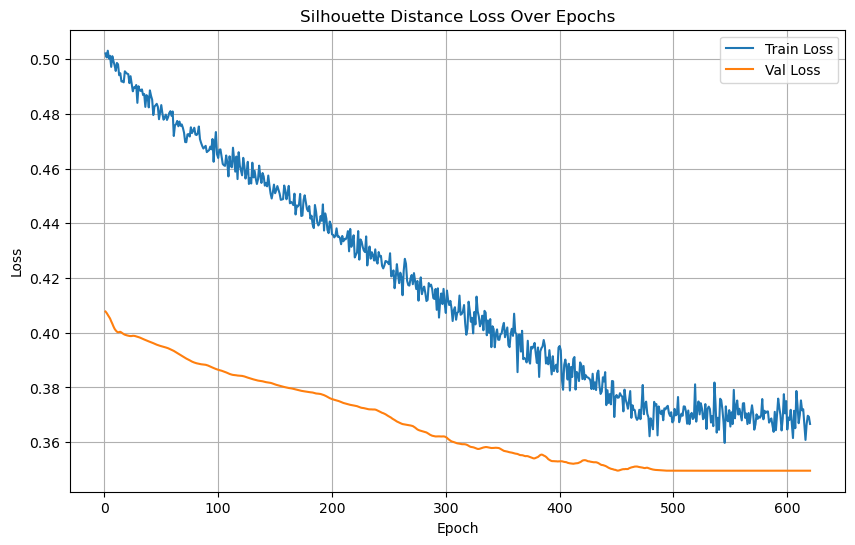

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/157], Loss: 0.3704
Test Batch [20/157], Loss: 0.3684
Test Batch [30/157], Loss: 0.3659
Test Batch [40/157], Loss: 0.3718


Test Batch [50/157], Loss: 0.4654
Test Batch [60/157], Loss: 0.4414
Test Batch [70/157], Loss: 0.2123


Test Batch [80/157], Loss: 0.2633
Test Batch [90/157], Loss: 0.2533
Test Batch [100/157], Loss: 0.2635
Test Batch [110/157], Loss: 0.2126
Test Batch [120/157], Loss: 0.1992
Test Batch [130/157], Loss: 0.1764


Test Batch [140/157], Loss: 0.4236
Test Batch [150/157], Loss: 0.3049

Test Loss: 0.3303


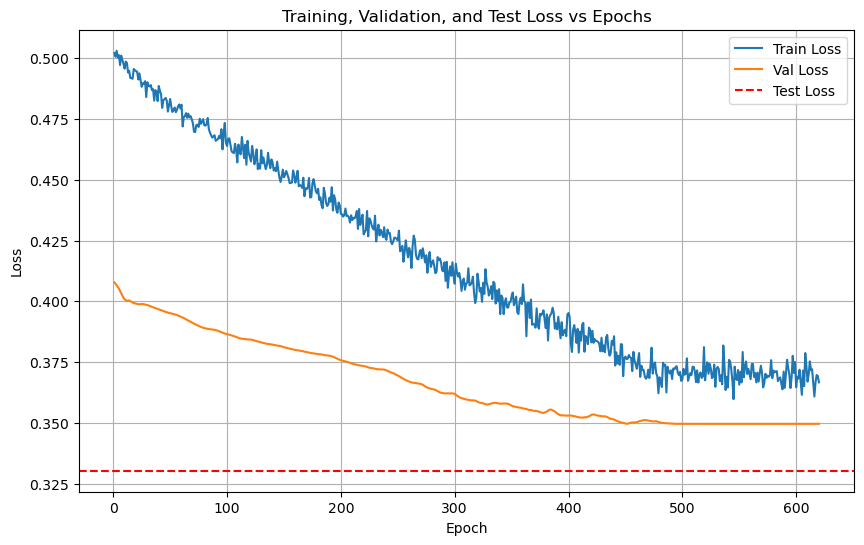

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/157 for test dataset.
  Processed batch 20/157 for test dataset.


  Processed batch 30/157 for test dataset.
  Processed batch 40/157 for test dataset.
  Processed batch 50/157 for test dataset.
  Processed batch 60/157 for test dataset.


  Processed batch 70/157 for test dataset.
  Processed batch 80/157 for test dataset.


  Processed batch 90/157 for test dataset.
  Processed batch 100/157 for test dataset.
  Processed batch 110/157 for test dataset.
  Processed batch 120/157 for test dataset.


  Processed batch 130/157 for test dataset.
  Processed batch 140/157 for test dataset.
  Processed batch 150/157 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.75      0.60      0.67         5
           4       0.38      0.60      0.46         5
           5       0.60      0.60      0.60         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.83      1.00      0.91         5
           9       0.60      0.60      0.60         5
          10       0.45      1.00      0.62         5
          11       0.25      0.20      0.22         5
          12       0.71      1.00      0.83         5
          13       0.2

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8336  |  Val Loss: 2.8645
Validation loss improved from inf to 2.8645.
[Epoch 2/1000] Train Loss: 2.8145  |  Val Loss: 2.8504
Validation loss improved from 2.8645 to 2.8504.
[Epoch 3/1000] Train Loss: 2.7935  |  Val Loss: 2.8367
Validation loss improved from 2.8504 to 2.8367.
[Epoch 4/1000] Train Loss: 2.7762  |  Val Loss: 2.8239
Validation loss improved from 2.8367 to 2.8239.
[Epoch 5/1000] Train Loss: 2.7598  |  Val Loss: 2.8114
Validation loss improved from 2.8239 to 2.8114.
[Epoch 6/1000] Train Loss: 2.7424  |  Val Loss: 2.7990
Validation loss improved from 2.8114 to 2.7990.
[Epoch 7/1000] Train Loss: 2.7263  |  Val Loss: 2.7875
Validation loss improved from 2.7990 to 2.7875.
[Epoch 8/1000] Train Loss: 2.7123  |  Val Loss: 2.7766
Validation loss improved from 2.7875 to 2.7766.
[Epoch 9/1000] Train Loss: 2.6974  |  Val Loss: 2.7657
Validation loss improved from 2.7766 to 2.7657.
[Epoch 10/1000] Train Loss: 2.6832  |  Val Loss: 2.7554
Validation loss impr

[Epoch 12/1000] Train Loss: 2.6563  |  Val Loss: 2.7346
Validation loss improved from 2.7450 to 2.7346.
[Epoch 13/1000] Train Loss: 2.6427  |  Val Loss: 2.7247
Validation loss improved from 2.7346 to 2.7247.
[Epoch 14/1000] Train Loss: 2.6299  |  Val Loss: 2.7150
Validation loss improved from 2.7247 to 2.7150.
[Epoch 15/1000] Train Loss: 2.6176  |  Val Loss: 2.7051
Validation loss improved from 2.7150 to 2.7051.
[Epoch 16/1000] Train Loss: 2.6053  |  Val Loss: 2.6955
Validation loss improved from 2.7051 to 2.6955.
[Epoch 17/1000] Train Loss: 2.5933  |  Val Loss: 2.6862
Validation loss improved from 2.6955 to 2.6862.
[Epoch 18/1000] Train Loss: 2.5817  |  Val Loss: 2.6770
Validation loss improved from 2.6862 to 2.6770.
[Epoch 19/1000] Train Loss: 2.5700  |  Val Loss: 2.6679
Validation loss improved from 2.6770 to 2.6679.
[Epoch 20/1000] Train Loss: 2.5588  |  Val Loss: 2.6590
Validation loss improved from 2.6679 to 2.6590.
[Epoch 21/1000] Train Loss: 2.5468  |  Val Loss: 2.6503
Validati

[Epoch 28/1000] Train Loss: 2.4709  |  Val Loss: 2.5897
Validation loss improved from 2.5981 to 2.5897.


[Epoch 29/1000] Train Loss: 2.4604  |  Val Loss: 2.5815
Validation loss improved from 2.5897 to 2.5815.
[Epoch 30/1000] Train Loss: 2.4499  |  Val Loss: 2.5732
Validation loss improved from 2.5815 to 2.5732.
[Epoch 31/1000] Train Loss: 2.4396  |  Val Loss: 2.5650
Validation loss improved from 2.5732 to 2.5650.
[Epoch 32/1000] Train Loss: 2.4293  |  Val Loss: 2.5570
Validation loss improved from 2.5650 to 2.5570.
[Epoch 33/1000] Train Loss: 2.4193  |  Val Loss: 2.5491
Validation loss improved from 2.5570 to 2.5491.
[Epoch 34/1000] Train Loss: 2.4090  |  Val Loss: 2.5413
Validation loss improved from 2.5491 to 2.5413.
[Epoch 35/1000] Train Loss: 2.3987  |  Val Loss: 2.5333
Validation loss improved from 2.5413 to 2.5333.
[Epoch 36/1000] Train Loss: 2.3883  |  Val Loss: 2.5254
Validation loss improved from 2.5333 to 2.5254.
[Epoch 37/1000] Train Loss: 2.3778  |  Val Loss: 2.5173
Validation loss improved from 2.5254 to 2.5173.
[Epoch 38/1000] Train Loss: 2.3671  |  Val Loss: 2.5093
Validati

[Epoch 43/1000] Train Loss: 2.3126  |  Val Loss: 2.4673
Validation loss improved from 2.4758 to 2.4673.
[Epoch 44/1000] Train Loss: 2.3014  |  Val Loss: 2.4587
Validation loss improved from 2.4673 to 2.4587.
[Epoch 45/1000] Train Loss: 2.2903  |  Val Loss: 2.4498
Validation loss improved from 2.4587 to 2.4498.
[Epoch 46/1000] Train Loss: 2.2785  |  Val Loss: 2.4409
Validation loss improved from 2.4498 to 2.4409.
[Epoch 47/1000] Train Loss: 2.2672  |  Val Loss: 2.4320
Validation loss improved from 2.4409 to 2.4320.
[Epoch 48/1000] Train Loss: 2.2558  |  Val Loss: 2.4230
Validation loss improved from 2.4320 to 2.4230.
[Epoch 49/1000] Train Loss: 2.2439  |  Val Loss: 2.4140
Validation loss improved from 2.4230 to 2.4140.
[Epoch 50/1000] Train Loss: 2.2320  |  Val Loss: 2.4047
Validation loss improved from 2.4140 to 2.4047.
[Epoch 51/1000] Train Loss: 2.2198  |  Val Loss: 2.3955
Validation loss improved from 2.4047 to 2.3955.
[Epoch 52/1000] Train Loss: 2.2077  |  Val Loss: 2.3863
Validati

[Epoch 56/1000] Train Loss: 2.1580  |  Val Loss: 2.3491
Validation loss improved from 2.3584 to 2.3491.
[Epoch 57/1000] Train Loss: 2.1453  |  Val Loss: 2.3399
Validation loss improved from 2.3491 to 2.3399.
[Epoch 58/1000] Train Loss: 2.1329  |  Val Loss: 2.3304
Validation loss improved from 2.3399 to 2.3304.
[Epoch 59/1000] Train Loss: 2.1197  |  Val Loss: 2.3212
Validation loss improved from 2.3304 to 2.3212.
[Epoch 60/1000] Train Loss: 2.1068  |  Val Loss: 2.3120
Validation loss improved from 2.3212 to 2.3120.
[Epoch 61/1000] Train Loss: 2.0940  |  Val Loss: 2.3028
Validation loss improved from 2.3120 to 2.3028.
[Epoch 62/1000] Train Loss: 2.0813  |  Val Loss: 2.2937
Validation loss improved from 2.3028 to 2.2937.
[Epoch 63/1000] Train Loss: 2.0680  |  Val Loss: 2.2847
Validation loss improved from 2.2937 to 2.2847.
[Epoch 64/1000] Train Loss: 2.0544  |  Val Loss: 2.2756
Validation loss improved from 2.2847 to 2.2756.
[Epoch 65/1000] Train Loss: 2.0415  |  Val Loss: 2.2664
Validati

[Epoch 69/1000] Train Loss: 1.9876  |  Val Loss: 2.2294
Validation loss improved from 2.2387 to 2.2294.
[Epoch 70/1000] Train Loss: 1.9743  |  Val Loss: 2.2199
Validation loss improved from 2.2294 to 2.2199.
[Epoch 71/1000] Train Loss: 1.9606  |  Val Loss: 2.2105
Validation loss improved from 2.2199 to 2.2105.
[Epoch 72/1000] Train Loss: 1.9472  |  Val Loss: 2.2009
Validation loss improved from 2.2105 to 2.2009.
[Epoch 73/1000] Train Loss: 1.9338  |  Val Loss: 2.1916
Validation loss improved from 2.2009 to 2.1916.
[Epoch 74/1000] Train Loss: 1.9198  |  Val Loss: 2.1823
Validation loss improved from 2.1916 to 2.1823.
[Epoch 75/1000] Train Loss: 1.9065  |  Val Loss: 2.1731
Validation loss improved from 2.1823 to 2.1731.
[Epoch 76/1000] Train Loss: 1.8927  |  Val Loss: 2.1640
Validation loss improved from 2.1731 to 2.1640.
[Epoch 77/1000] Train Loss: 1.8792  |  Val Loss: 2.1547
Validation loss improved from 2.1640 to 2.1547.
[Epoch 78/1000] Train Loss: 1.8648  |  Val Loss: 2.1456
Validati

[Epoch 81/1000] Train Loss: 1.8236  |  Val Loss: 2.1179
Validation loss improved from 2.1271 to 2.1179.
[Epoch 82/1000] Train Loss: 1.8098  |  Val Loss: 2.1086
Validation loss improved from 2.1179 to 2.1086.
[Epoch 83/1000] Train Loss: 1.7964  |  Val Loss: 2.0997
Validation loss improved from 2.1086 to 2.0997.
[Epoch 84/1000] Train Loss: 1.7822  |  Val Loss: 2.0908
Validation loss improved from 2.0997 to 2.0908.
[Epoch 85/1000] Train Loss: 1.7687  |  Val Loss: 2.0820
Validation loss improved from 2.0908 to 2.0820.
[Epoch 86/1000] Train Loss: 1.7555  |  Val Loss: 2.0733
Validation loss improved from 2.0820 to 2.0733.
[Epoch 87/1000] Train Loss: 1.7421  |  Val Loss: 2.0647
Validation loss improved from 2.0733 to 2.0647.
[Epoch 88/1000] Train Loss: 1.7282  |  Val Loss: 2.0564
Validation loss improved from 2.0647 to 2.0564.
[Epoch 89/1000] Train Loss: 1.7149  |  Val Loss: 2.0480
Validation loss improved from 2.0564 to 2.0480.
[Epoch 90/1000] Train Loss: 1.7014  |  Val Loss: 2.0398
Validati

[Epoch 99/1000] Train Loss: 1.5820  |  Val Loss: 1.9702
Validation loss improved from 1.9777 to 1.9702.
[Epoch 100/1000] Train Loss: 1.5692  |  Val Loss: 1.9624
Validation loss improved from 1.9702 to 1.9624.
[Epoch 101/1000] Train Loss: 1.5563  |  Val Loss: 1.9546
Validation loss improved from 1.9624 to 1.9546.
[Epoch 102/1000] Train Loss: 1.5439  |  Val Loss: 1.9470
Validation loss improved from 1.9546 to 1.9470.
[Epoch 103/1000] Train Loss: 1.5312  |  Val Loss: 1.9395
Validation loss improved from 1.9470 to 1.9395.
[Epoch 104/1000] Train Loss: 1.5188  |  Val Loss: 1.9323
Validation loss improved from 1.9395 to 1.9323.
[Epoch 105/1000] Train Loss: 1.5067  |  Val Loss: 1.9254
Validation loss improved from 1.9323 to 1.9254.
[Epoch 106/1000] Train Loss: 1.4943  |  Val Loss: 1.9186
Validation loss improved from 1.9254 to 1.9186.
[Epoch 107/1000] Train Loss: 1.4820  |  Val Loss: 1.9117
Validation loss improved from 1.9186 to 1.9117.
[Epoch 108/1000] Train Loss: 1.4699  |  Val Loss: 1.9047

[Epoch 111/1000] Train Loss: 1.4337  |  Val Loss: 1.8845
Validation loss improved from 1.8910 to 1.8845.
[Epoch 112/1000] Train Loss: 1.4219  |  Val Loss: 1.8778
Validation loss improved from 1.8845 to 1.8778.
[Epoch 113/1000] Train Loss: 1.4101  |  Val Loss: 1.8707
Validation loss improved from 1.8778 to 1.8707.
[Epoch 114/1000] Train Loss: 1.3986  |  Val Loss: 1.8640
Validation loss improved from 1.8707 to 1.8640.
[Epoch 115/1000] Train Loss: 1.3869  |  Val Loss: 1.8576
Validation loss improved from 1.8640 to 1.8576.
[Epoch 116/1000] Train Loss: 1.3757  |  Val Loss: 1.8514
Validation loss improved from 1.8576 to 1.8514.
[Epoch 117/1000] Train Loss: 1.3641  |  Val Loss: 1.8448
Validation loss improved from 1.8514 to 1.8448.
[Epoch 118/1000] Train Loss: 1.3531  |  Val Loss: 1.8389
Validation loss improved from 1.8448 to 1.8389.
[Epoch 119/1000] Train Loss: 1.3416  |  Val Loss: 1.8330
Validation loss improved from 1.8389 to 1.8330.
[Epoch 120/1000] Train Loss: 1.3309  |  Val Loss: 1.827

[Epoch 128/1000] Train Loss: 1.2464  |  Val Loss: 1.7838
Validation loss improved from 1.7890 to 1.7838.
[Epoch 129/1000] Train Loss: 1.2365  |  Val Loss: 1.7786
Validation loss improved from 1.7838 to 1.7786.
[Epoch 130/1000] Train Loss: 1.2262  |  Val Loss: 1.7731
Validation loss improved from 1.7786 to 1.7731.
[Epoch 131/1000] Train Loss: 1.2160  |  Val Loss: 1.7679
Validation loss improved from 1.7731 to 1.7679.
[Epoch 132/1000] Train Loss: 1.2056  |  Val Loss: 1.7632
Validation loss improved from 1.7679 to 1.7632.
[Epoch 133/1000] Train Loss: 1.1955  |  Val Loss: 1.7580
Validation loss improved from 1.7632 to 1.7580.
[Epoch 134/1000] Train Loss: 1.1854  |  Val Loss: 1.7527
Validation loss improved from 1.7580 to 1.7527.
[Epoch 135/1000] Train Loss: 1.1754  |  Val Loss: 1.7475
Validation loss improved from 1.7527 to 1.7475.
[Epoch 136/1000] Train Loss: 1.1651  |  Val Loss: 1.7422
Validation loss improved from 1.7475 to 1.7422.
[Epoch 137/1000] Train Loss: 1.1552  |  Val Loss: 1.736

[Epoch 142/1000] Train Loss: 1.1066  |  Val Loss: 1.7131
Validation loss improved from 1.7176 to 1.7131.
[Epoch 143/1000] Train Loss: 1.0969  |  Val Loss: 1.7086
Validation loss improved from 1.7131 to 1.7086.
[Epoch 144/1000] Train Loss: 1.0878  |  Val Loss: 1.7042
Validation loss improved from 1.7086 to 1.7042.
[Epoch 145/1000] Train Loss: 1.0783  |  Val Loss: 1.6997
Validation loss improved from 1.7042 to 1.6997.
[Epoch 146/1000] Train Loss: 1.0693  |  Val Loss: 1.6953
Validation loss improved from 1.6997 to 1.6953.
[Epoch 147/1000] Train Loss: 1.0602  |  Val Loss: 1.6911
Validation loss improved from 1.6953 to 1.6911.
[Epoch 148/1000] Train Loss: 1.0510  |  Val Loss: 1.6871
Validation loss improved from 1.6911 to 1.6871.
[Epoch 149/1000] Train Loss: 1.0424  |  Val Loss: 1.6826
Validation loss improved from 1.6871 to 1.6826.
[Epoch 150/1000] Train Loss: 1.0339  |  Val Loss: 1.6777
Validation loss improved from 1.6826 to 1.6777.
[Epoch 151/1000] Train Loss: 1.0247  |  Val Loss: 1.673

[Epoch 161/1000] Train Loss: 0.9408  |  Val Loss: 1.6328
Validation loss improved from 1.6361 to 1.6328.
[Epoch 162/1000] Train Loss: 0.9331  |  Val Loss: 1.6294
Validation loss improved from 1.6328 to 1.6294.
[Epoch 163/1000] Train Loss: 0.9252  |  Val Loss: 1.6261
Validation loss improved from 1.6294 to 1.6261.
[Epoch 164/1000] Train Loss: 0.9173  |  Val Loss: 1.6228
Validation loss improved from 1.6261 to 1.6228.
[Epoch 165/1000] Train Loss: 0.9096  |  Val Loss: 1.6195
Validation loss improved from 1.6228 to 1.6195.
[Epoch 166/1000] Train Loss: 0.9018  |  Val Loss: 1.6165
Validation loss improved from 1.6195 to 1.6165.
[Epoch 167/1000] Train Loss: 0.8943  |  Val Loss: 1.6140
Validation loss improved from 1.6165 to 1.6140.
[Epoch 168/1000] Train Loss: 0.8867  |  Val Loss: 1.6111
Validation loss improved from 1.6140 to 1.6111.
[Epoch 169/1000] Train Loss: 0.8790  |  Val Loss: 1.6082
Validation loss improved from 1.6111 to 1.6082.
[Epoch 170/1000] Train Loss: 0.8718  |  Val Loss: 1.605

[Epoch 175/1000] Train Loss: 0.8354  |  Val Loss: 1.5919
Validation loss improved from 1.5938 to 1.5919.
[Epoch 176/1000] Train Loss: 0.8282  |  Val Loss: 1.5893
Validation loss improved from 1.5919 to 1.5893.
[Epoch 177/1000] Train Loss: 0.8211  |  Val Loss: 1.5865
Validation loss improved from 1.5893 to 1.5865.
[Epoch 178/1000] Train Loss: 0.8143  |  Val Loss: 1.5840
Validation loss improved from 1.5865 to 1.5840.
[Epoch 179/1000] Train Loss: 0.8073  |  Val Loss: 1.5819
Validation loss improved from 1.5840 to 1.5819.
[Epoch 180/1000] Train Loss: 0.8005  |  Val Loss: 1.5805
Validation loss improved from 1.5819 to 1.5805.
[Epoch 181/1000] Train Loss: 0.7938  |  Val Loss: 1.5787
Validation loss improved from 1.5805 to 1.5787.
[Epoch 182/1000] Train Loss: 0.7873  |  Val Loss: 1.5764
Validation loss improved from 1.5787 to 1.5764.
[Epoch 183/1000] Train Loss: 0.7804  |  Val Loss: 1.5741
Validation loss improved from 1.5764 to 1.5741.
[Epoch 184/1000] Train Loss: 0.7739  |  Val Loss: 1.571

[Epoch 191/1000] Train Loss: 0.7291  |  Val Loss: 1.5595
Validation loss improved from 1.5610 to 1.5595.
[Epoch 192/1000] Train Loss: 0.7229  |  Val Loss: 1.5574
Validation loss improved from 1.5595 to 1.5574.
[Epoch 193/1000] Train Loss: 0.7166  |  Val Loss: 1.5558
Validation loss improved from 1.5574 to 1.5558.
[Epoch 194/1000] Train Loss: 0.7108  |  Val Loss: 1.5539
Validation loss improved from 1.5558 to 1.5539.
[Epoch 195/1000] Train Loss: 0.7046  |  Val Loss: 1.5518
Validation loss improved from 1.5539 to 1.5518.
[Epoch 196/1000] Train Loss: 0.6987  |  Val Loss: 1.5496
Validation loss improved from 1.5518 to 1.5496.
[Epoch 197/1000] Train Loss: 0.6927  |  Val Loss: 1.5473
Validation loss improved from 1.5496 to 1.5473.
[Epoch 198/1000] Train Loss: 0.6871  |  Val Loss: 1.5452
Validation loss improved from 1.5473 to 1.5452.
[Epoch 199/1000] Train Loss: 0.6814  |  Val Loss: 1.5437
Validation loss improved from 1.5452 to 1.5437.
[Epoch 200/1000] Train Loss: 0.6759  |  Val Loss: 1.542

[Epoch 204/1000] Train Loss: 0.6536  |  Val Loss: 1.5390
Validation loss improved from 1.5398 to 1.5390.
[Epoch 205/1000] Train Loss: 0.6481  |  Val Loss: 1.5381
Validation loss improved from 1.5390 to 1.5381.
[Epoch 206/1000] Train Loss: 0.6430  |  Val Loss: 1.5368
Validation loss improved from 1.5381 to 1.5368.
[Epoch 207/1000] Train Loss: 0.6378  |  Val Loss: 1.5361
Validation loss improved from 1.5368 to 1.5361.
[Epoch 208/1000] Train Loss: 0.6328  |  Val Loss: 1.5350
Validation loss improved from 1.5361 to 1.5350.
[Epoch 209/1000] Train Loss: 0.6274  |  Val Loss: 1.5352
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 0.6227  |  Val Loss: 1.5355
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 211/1000] Train Loss: 0.6175  |  Val Loss: 1.5360
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 212/1000] Train Loss: 0.6129  |  Val Loss: 1.5365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 213/1000] Train Loss: 0.

[Epoch 219/1000] Train Loss: 0.5799  |  Val Loss: 1.5317
Validation loss improved from 1.5325 to 1.5317.
[Epoch 220/1000] Train Loss: 0.5756  |  Val Loss: 1.5321
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 0.5713  |  Val Loss: 1.5323
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 222/1000] Train Loss: 0.5670  |  Val Loss: 1.5334
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 223/1000] Train Loss: 0.5627  |  Val Loss: 1.5340
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 224/1000] Train Loss: 0.5583  |  Val Loss: 1.5343
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 225/1000] Train Loss: 0.5542  |  Val Loss: 1.5355
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 226/1000] Train Loss: 0.5502  |  Val Loss: 1.5368
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 227/1000] Train Loss: 0.5462  |  Val Loss: 1.5373
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 229/1000] Train Loss: 0.5380  |  Val Loss: 1.5381
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 230/1000] Train Loss: 0.5341  |  Val Loss: 1.5384
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 231/1000] Train Loss: 0.5300  |  Val Loss: 1.5386
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 232/1000] Train Loss: 0.5262  |  Val Loss: 1.5387
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 233/1000] Train Loss: 0.5226  |  Val Loss: 1.5387
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 234/1000] Train Loss: 0.5190  |  Val Loss: 1.5390
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 235/1000] Train Loss: 0.5151  |  Val Loss: 1.5401
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 236/1000] Train Loss: 0.5116  |  Val Loss: 1.5413
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 237/1000] Train Loss: 0.5080  |  Val Loss: 1.5428
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 0.4668  |  Val Loss: 1.5526
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 250/1000] Train Loss: 0.4636  |  Val Loss: 1.5536
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 251/1000] Train Loss: 0.4603  |  Val Loss: 1.5559
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 252/1000] Train Loss: 0.4570  |  Val Loss: 1.5594
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 253/1000] Train Loss: 0.4544  |  Val Loss: 1.5628
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 254/1000] Train Loss: 0.4509  |  Val Loss: 1.5639
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 255/1000] Train Loss: 0.4477  |  Val Loss: 1.5647
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 256/1000] Train Loss: 0.4445  |  Val Loss: 1.5647
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 257/1000] Train Loss: 0.4415  |  Val Loss: 1.5640
!! Validation loss did NOT improve !! Patience:

[Epoch 259/1000] Train Loss: 0.4360  |  Val Loss: 1.5645
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 260/1000] Train Loss: 0.4328  |  Val Loss: 1.5656
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 261/1000] Train Loss: 0.4300  |  Val Loss: 1.5673
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 262/1000] Train Loss: 0.4271  |  Val Loss: 1.5694
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 263/1000] Train Loss: 0.4245  |  Val Loss: 1.5722
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 264/1000] Train Loss: 0.4217  |  Val Loss: 1.5740
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 265/1000] Train Loss: 0.4188  |  Val Loss: 1.5746
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 266/1000] Train Loss: 0.4159  |  Val Loss: 1.5753
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 267/1000] Train Loss: 0.4133  |  Val Loss: 1.5748
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 0.3873  |  Val Loss: 1.5890
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 278/1000] Train Loss: 0.3849  |  Val Loss: 1.5917
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 279/1000] Train Loss: 0.3824  |  Val Loss: 1.5925
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 280/1000] Train Loss: 0.3801  |  Val Loss: 1.5930
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 281/1000] Train Loss: 0.3777  |  Val Loss: 1.5954
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 282/1000] Train Loss: 0.3755  |  Val Loss: 1.5974
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 283/1000] Train Loss: 0.3732  |  Val Loss: 1.5987
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 284/1000] Train Loss: 0.3709  |  Val Loss: 1.6001
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 285/1000] Train Loss: 0.3687  |  Val Loss: 1.6012
!! Validation loss did NOT improve !! Patience:

[Epoch 286/1000] Train Loss: 0.3665  |  Val Loss: 1.6019
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 287/1000] Train Loss: 0.3643  |  Val Loss: 1.6029
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 288/1000] Train Loss: 0.3621  |  Val Loss: 1.6048
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 289/1000] Train Loss: 0.3600  |  Val Loss: 1.6072
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 290/1000] Train Loss: 0.3579  |  Val Loss: 1.6098
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 291/1000] Train Loss: 0.3558  |  Val Loss: 1.6111
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 292/1000] Train Loss: 0.3538  |  Val Loss: 1.6134
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 293/1000] Train Loss: 0.3516  |  Val Loss: 1.6158
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 294/1000] Train Loss: 0.3497  |  Val Loss: 1.6189
!! Validation loss did NOT improve !! Patience:

[Epoch 305/1000] Train Loss: 0.3287  |  Val Loss: 1.6400
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 306/1000] Train Loss: 0.3269  |  Val Loss: 1.6415
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 307/1000] Train Loss: 0.3251  |  Val Loss: 1.6443
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 308/1000] Train Loss: 0.3232  |  Val Loss: 1.6453
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 309/1000] Train Loss: 0.3214  |  Val Loss: 1.6471
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 310/1000] Train Loss: 0.3196  |  Val Loss: 1.6501
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 311/1000] Train Loss: 0.3178  |  Val Loss: 1.6525
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 312/1000] Train Loss: 0.3162  |  Val Loss: 1.6548
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 313/1000] Train Loss: 0.3145  |  Val Loss: 1.6557
!! Validation loss did NOT improve !! Patience:

[Epoch 316/1000] Train Loss: 0.3092  |  Val Loss: 1.6592
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 317/1000] Train Loss: 0.3077  |  Val Loss: 1.6604
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 318/1000] Train Loss: 0.3060  |  Val Loss: 1.6614
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 319/1000] Train Loss: 0.3042  |  Val Loss: 1.6612
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 319 !!
No improvement for 100 epochs.


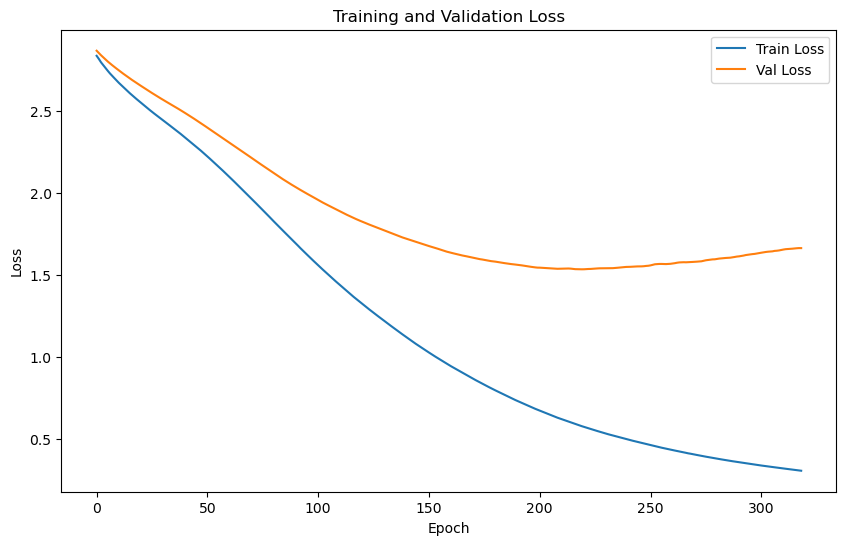

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.4536 | Test Accuracy: 44.10%


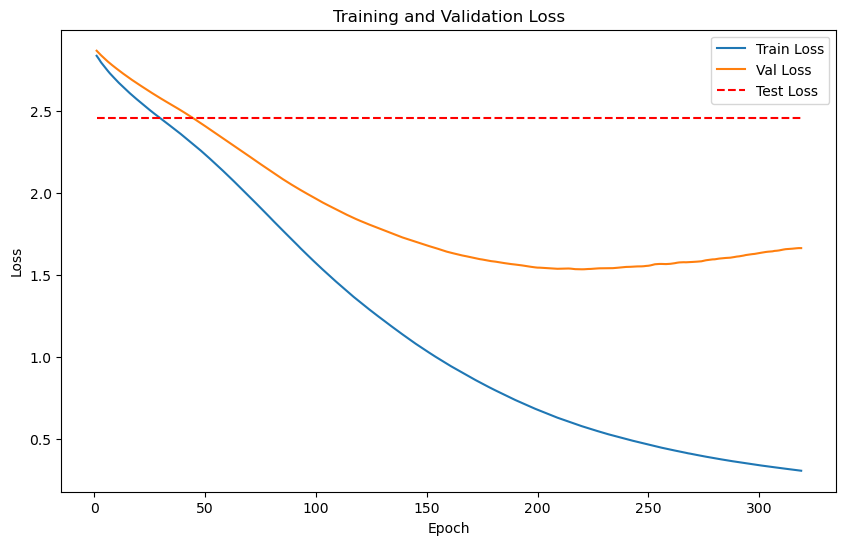

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


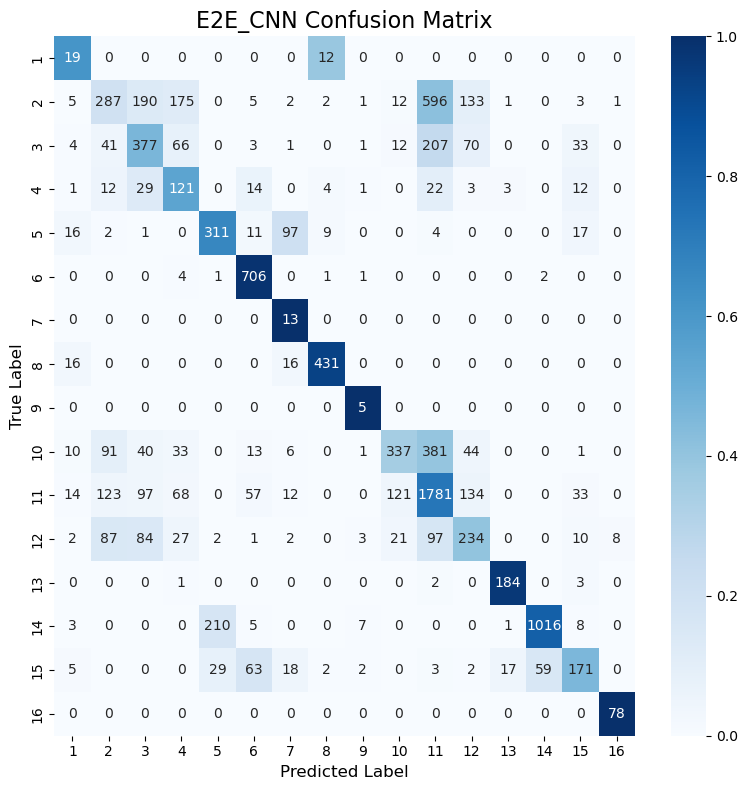

Classification Accuracy: 60.66%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


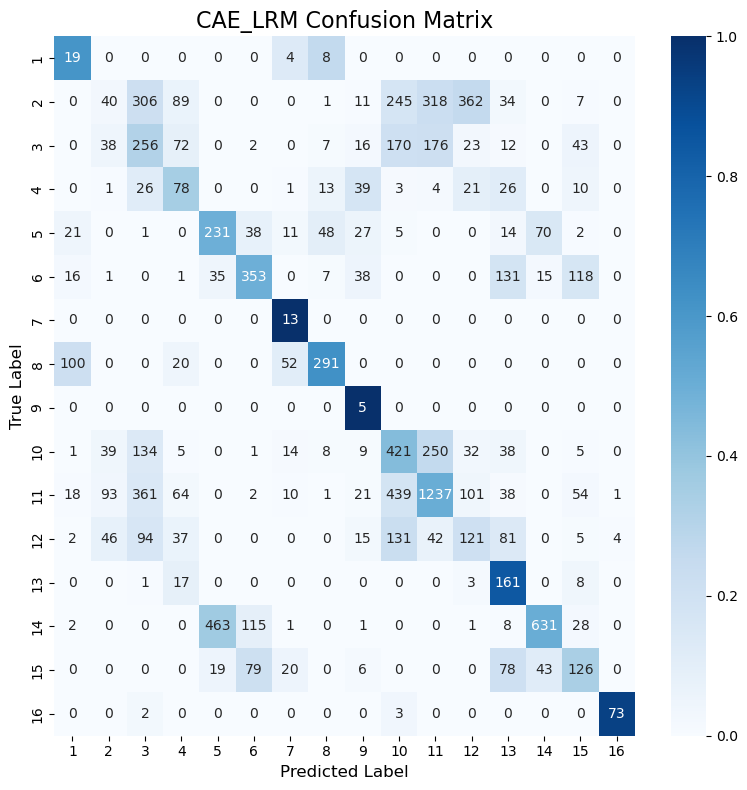

Classification Accuracy: 40.52%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


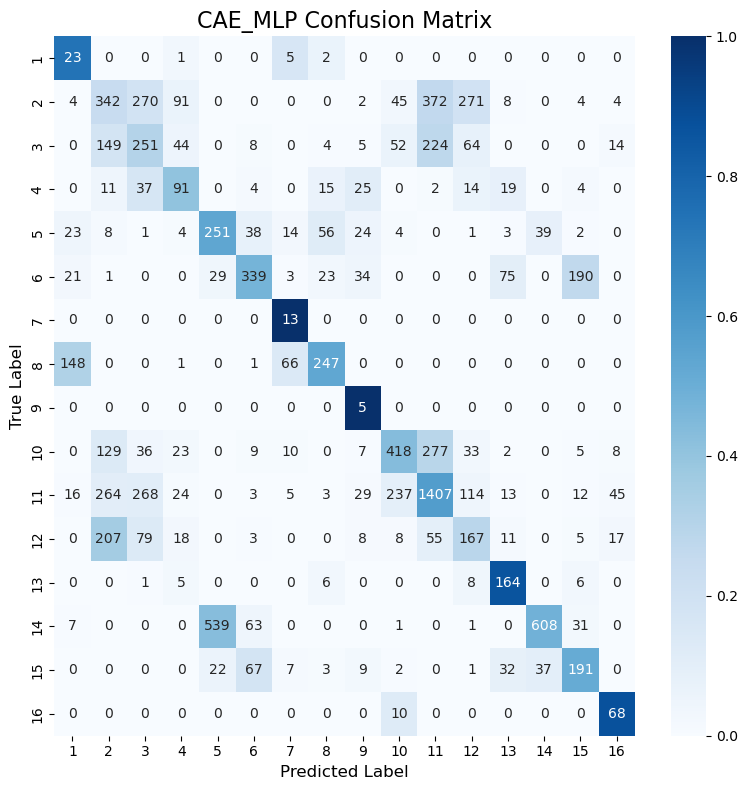

Classification Accuracy: 45.81%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


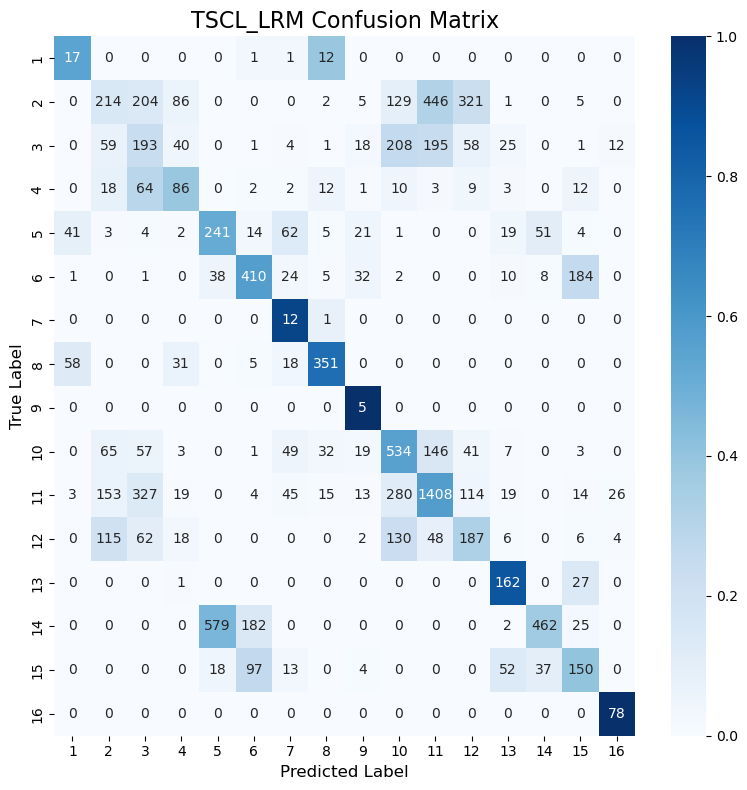

Classification Accuracy: 45.06%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


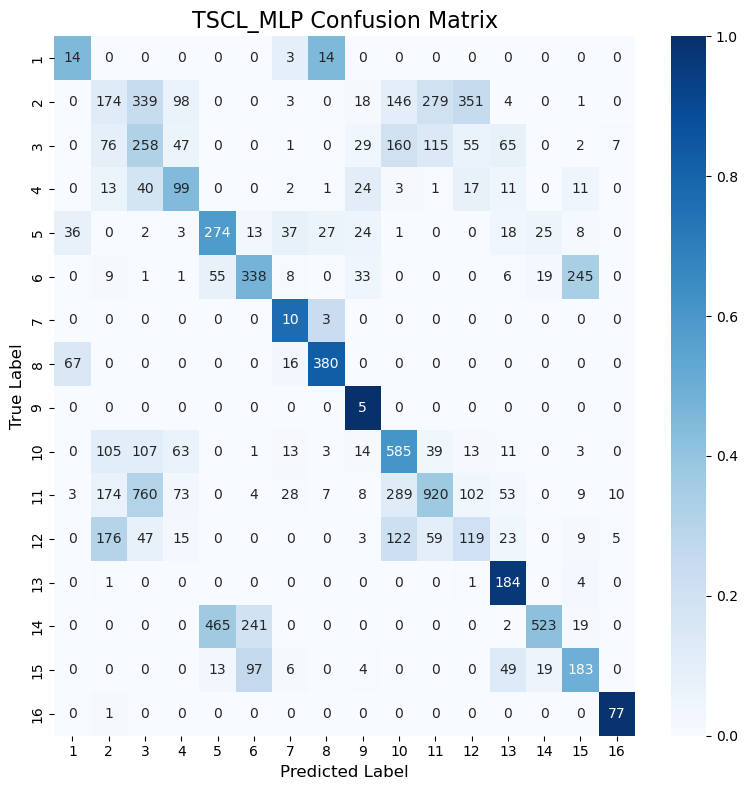

Classification Accuracy: 41.39%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


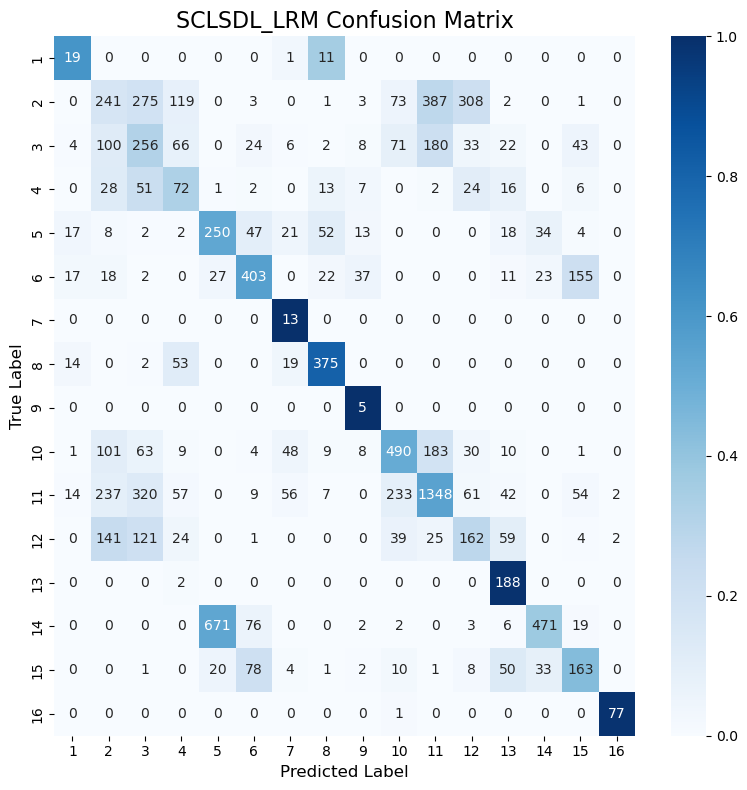

Classification Accuracy: 45.29%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


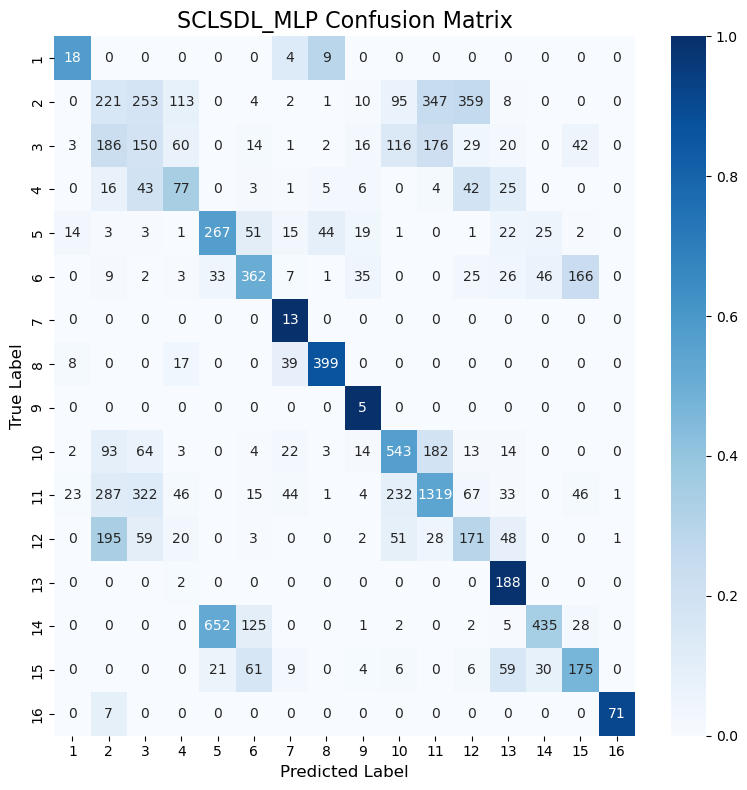

Classification Accuracy: 44.10%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          60.66
1    LRM (CAE)          40.52
2    MLP (CAE)          45.81
3     TSCL LRM          45.06
4     TSCL MLP          41.39
5  SCL_SDL LRM          45.29
6  SCL_SDL MLP          44.10

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          60.66
2    MLP (CAE)          45.81
5  SCL_SDL LRM          45.29
3     TSCL LRM          45.06
6  SCL_SDL MLP          44.10
4     TSCL MLP          41.39
1    LRM (CAE)          40.52
